# Score Table

This notebook estimates the diffusion t-mean for synthetic data compared to the estimation using bridge sampling. Further time-complexity is estimated in this note book

In [1]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics import Frechet_mean
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from models import models

2024-02-19 14:12:37.736057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
loss_type = 'dsm'
s2_approximation = True

In [3]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

In [4]:
def hess_TM(M, Fx, v, h):
    x = get_coords(M, Fx)
    
    val1 = jacfwdx(lambda x: M.invJF((M.F(x), M.F(x))))(x)
    val2 = M.invJF((M.F(x), M.F(x)))
    val3 = M.JF(x)
    
    term1 = jnp.einsum('ijk,j->ik', val1, v)
    term2 = val2.dot(h).dot(val3)
    
    return term1+term2
    

# Euclidean

## Defining Manifold and Loading Score

In [5]:
N = 2

In [648]:
M = Euclidean(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = (jnp.zeros(N), jnp.zeros(1))

using M.Exp for Logarithm


In [649]:

file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/R'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)

if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))

rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):

    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):

    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)

    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())

    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):

    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

    return ggrad

def ggrady_log_score(x,y,t):

    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

    return ggrad

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [650]:
loss = jnp.load('scores/R'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


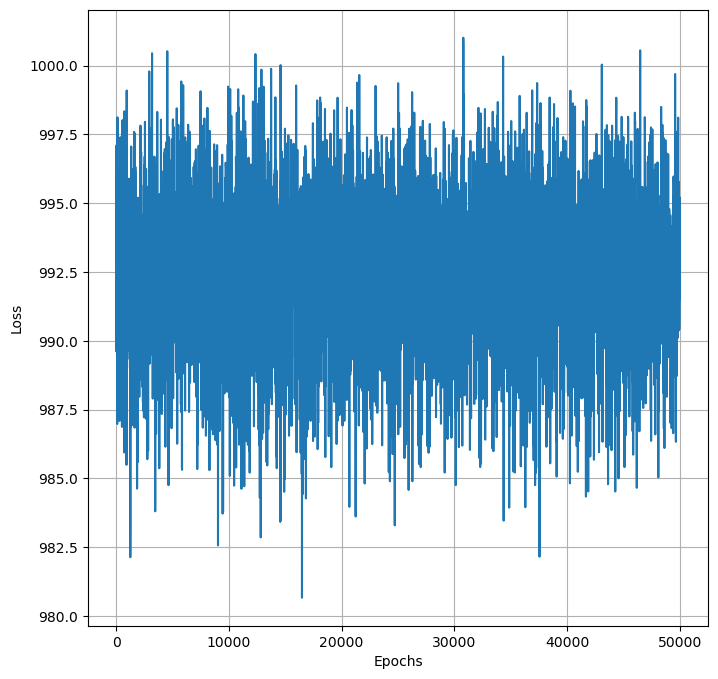

In [651]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [652]:
loss = jnp.load('scores/R'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  80


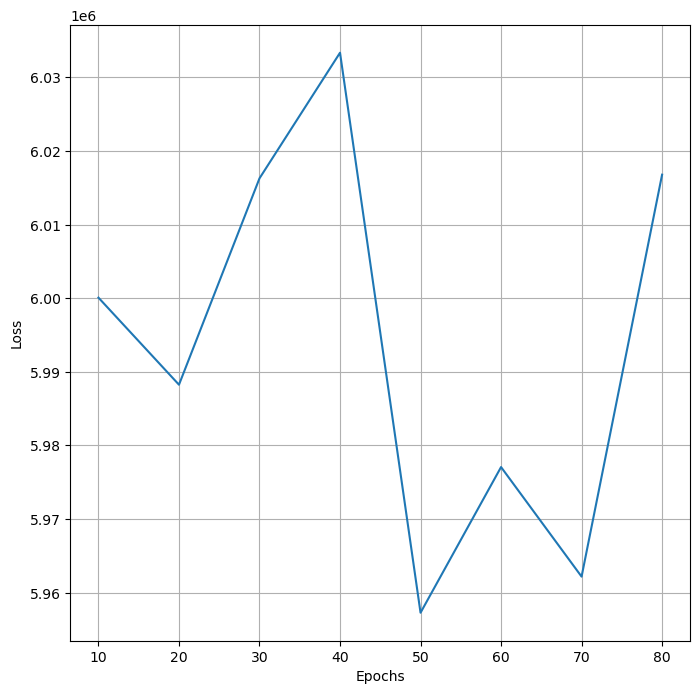

In [653]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [654]:
s2.apply(state_s2.params, rng_key, jnp.hstack((x0[0],x0[0],0.5)))

Array([[-1.8824924 ,  0.00582239],
       [ 0.00582239, -2.0718412 ]], dtype=float32)

## Estimating Diffusion t-Mean

In [655]:
xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

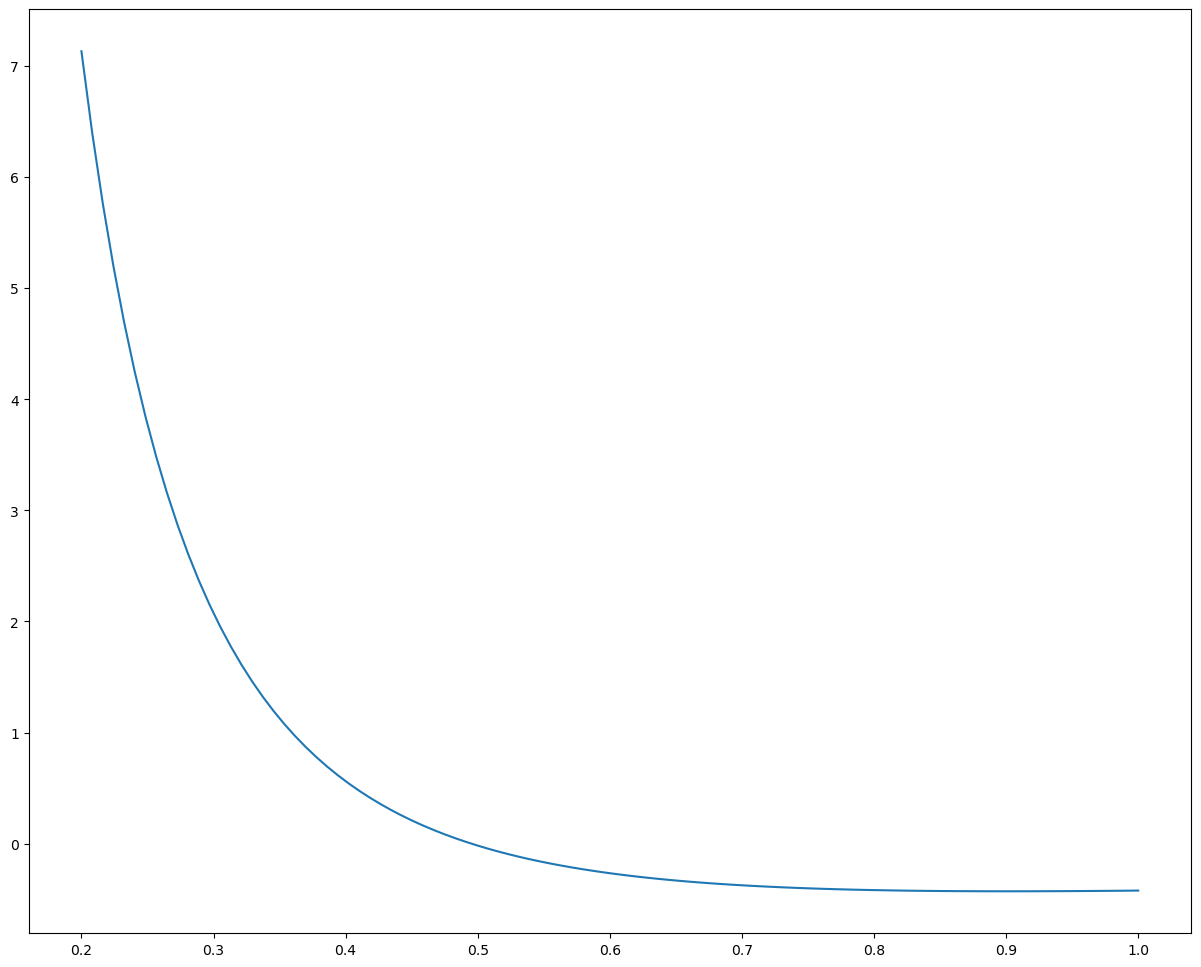

In [656]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [657]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                    step_size=0.01, max_iter=1000)

In [679]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.155812e+01 | T: ((Array([0.01136593, 0.09555456], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.042644e+01 | T: ((Array([0.00212493, 0.08565386], dtype=float32), Array(0.21992828, dtype=float32)), Array([0.], dtype=float32))
Final 1 | T: 1.042644e+01 | T: (Array([0.00212493, 0.08565386], dtype=float32), Array(0.21992828, dtype=float32))
Step 0 | T: 1.155812e+01 | T: ((Array([0.01136593, 0.09555456], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.042644e+01 | T: ((Array([0.00212493, 0.08565386], dtype=float32), Array(0.21992828, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.465787e+00 | T: ((Array([-0.0053882 ,  0.07591895], dtype=float32), Array(0.22974522, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.647336e+00 | T: ((Array([-0.01034314,  0.06641454], dtype=float32), Array(0.23941696, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.946887e+00

Step 55 | T: 2.574970e+00 | T: ((Array([-0.00011561,  0.00142795], dtype=float32), Array(0.48529682, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.565113e+00 | T: ((Array([-0.0003367 ,  0.00194029], dtype=float32), Array(0.48727754, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 2.555630e+00 | T: ((Array([-0.00050336,  0.00239471], dtype=float32), Array(0.48922145, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.546501e+00 | T: ((Array([-0.00061332,  0.00279325], dtype=float32), Array(0.49113026, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.537703e+00 | T: ((Array([-0.000667  ,  0.00313814], dtype=float32), Array(0.4930055, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.529217e+00 | T: ((Array([-0.00066722,  0.0034318 ], dtype=float32), Array(0.49484867, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.521026e+00 | T: ((Array([-0.00061887,  0.00367683], dtype=float32), Array(0.49666113, dtype=float32)), Array([

In [638]:
mu_opt, T_opt = M.mlxt_hk(X_obs)

In [639]:
T_opt

Array(0.48487148, dtype=float32)

In [658]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0003 -0.0150 )
T = 0.5083


In [641]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgex[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgex' is not defined

In [642]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[0]), ")")
print(f"T = {T_opt:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0004 -0.0167 )
T = 0.4849


In [485]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_sm[0][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_bridgex[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.00115 
 -T error = 0.00425


NameError: name 'mu_bridgex' is not defined

## Estimating Diffusion Mean

### Error Estimate

In [165]:
dims = [2,3,5,10,20,50]
rn_score_mu_error = []
rn_bridge_mu_error = []
rn_score_t_error = []
rn_bridge_t_error = []

for N in dims:
    M = Euclidean(N=N)
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    x0 = (jnp.zeros(N), jnp.zeros(1))
    
    file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/R'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
        s2_val = ggrady_log(x,y,t)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

        return ggrad

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))
    
    mu_opt, T_opt = M.mlxt_hk(X_obs)
    diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
    mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), \
                                           step_size=0.01, max_iter=100)

    (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)
    
    mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
    mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
    T_bridge = jnp.stack(T_bridge)
    
    rn_score_mu_error.append(jnp.linalg.norm(mu_opt[0]-mu_sm[0][-1])/N)
    rn_score_t_error.append(jnp.linalg.norm(T_opt-T_sm[-1]))
    
    rn_bridge_mu_error.append(jnp.linalg.norm(mu_opt[0]-mu_bridgex[-1])/N)
    rn_bridge_t_error.append(jnp.linalg.norm(T_opt-T_bridge[-1]))
    

using M.Exp for Logarithm
Step 0 | T: 1.166098e+01 | T: ((Array([-0.06693234, -0.1067147 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.050420e+01 | T: ((Array([-0.0570615 , -0.09680624], dtype=float32), Array(0.21992742, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.522740e+00 | T: ((Array([-0.04741303, -0.08704927], dtype=float32), Array(0.22974211, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.687511e+00 | T: ((Array([-0.03808192, -0.07750144], dtype=float32), Array(0.23940983, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.974337e+00 | T: ((Array([-0.02916122, -0.06821694], dtype=float32), Array(0.24890214, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.363166e+00 | T: ((Array([-0.02073769, -0.05924538], dtype=float32), Array(0.258196, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.837400e+00 | T: ((Array([-0.01288769, -0.05063091], dtype=float32), Array(0.26727322, dtype=

Step 58 | T: 2.548660e+00 | T: ((Array([-0.00439872,  0.00163471], dtype=float32), Array(0.49067655, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.539819e+00 | T: ((Array([-0.00404472,  0.00107641], dtype=float32), Array(0.49254972, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.531291e+00 | T: ((Array([-0.00367665,  0.00056577], dtype=float32), Array(0.4943909, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.523062e+00 | T: ((Array([-0.00329966,  0.00010165], dtype=float32), Array(0.49620146, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 2.515113e+00 | T: ((Array([-0.00291851, -0.00031728], dtype=float32), Array(0.4979827, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 2.507430e+00 | T: ((Array([-0.00253757, -0.00069251], dtype=float32), Array(0.49973586, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 2.500000e+00 | T: ((Array([-0.00216081, -0.0010257 ], dtype=float32), Array(0.5014621, dtype=float32)), Array([0.

Step 13 | T: 6.970240e+00 | T: ((Array([-0.06447908, -0.02558859, -0.03593795], dtype=float32), Array(0.32386607, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 6.693733e+00 | T: ((Array([-0.05843645, -0.0209549 , -0.04013822], dtype=float32), Array(0.3309456, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 6.447530e+00 | T: ((Array([-0.05277709, -0.01681913, -0.04381283], dtype=float32), Array(0.3377799, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 6.227522e+00 | T: ((Array([-0.04749687, -0.0131664 , -0.04698157], dtype=float32), Array(0.34437418, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 6.030237e+00 | T: ((Array([-0.04258958, -0.00997864, -0.04966757], dtype=float32), Array(0.35073435, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 5.852734e+00 | T: ((Array([-0.0380472 , -0.00723517, -0.05189658], dtype=float32), Array(0.35686693, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 5.692510e+00 | T: ((Array([-0.03386

Step 65 | T: 3.741400e+00 | T: ((Array([-0.02048375, -0.0307084 , -0.02351924], dtype=float32), Array(0.5023528, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 3.730901e+00 | T: ((Array([-0.02103437, -0.03084667, -0.02354147], dtype=float32), Array(0.5040246, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 3.720724e+00 | T: ((Array([-0.02156311, -0.0309502 , -0.02359258], dtype=float32), Array(0.50567275, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 3.710856e+00 | T: ((Array([-0.02206961, -0.03102149, -0.02366954], dtype=float32), Array(0.50729805, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 3.701281e+00 | T: ((Array([-0.0225537 , -0.03106303, -0.02376936], dtype=float32), Array(0.5089013, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 3.691987e+00 | T: ((Array([-0.02301527, -0.03107728, -0.02388918], dtype=float32), Array(0.5104834, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 3.682960e+00 | T: ((Array([-0.0234543

Step 15 | T: 1.003977e+01 | T: ((Array([ 0.00323198, -0.00698648, -0.02253832, -0.00284523, -0.11246986],      dtype=float32), Array(0.33781084, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 9.696223e+00 | T: ((Array([ 0.00371438, -0.00654469, -0.0246111 , -0.00117855, -0.10591454],      dtype=float32), Array(0.34439588, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 9.388270e+00 | T: ((Array([ 0.00369045, -0.00566922, -0.02618044,  0.00052092, -0.09963395],      dtype=float32), Array(0.35074395, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 9.111423e+00 | T: ((Array([ 0.00322678, -0.0044665 , -0.02728493,  0.002117  , -0.09362459],      dtype=float32), Array(0.3568615, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 8.861845e+00 | T: ((Array([ 0.00245562, -0.0030459 , -0.02796414,  0.00349917, -0.0878821 ],      dtype=float32), Array(0.36275533, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 8.636251e+00 | T: ((Array([ 0.0015419 

Step 59 | T: 6.024687e+00 | T: ((Array([0.00095212, 0.00221948, 0.00646087, 0.00043041, 0.00050966],      dtype=float32), Array(0.48973608, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 6.006170e+00 | T: ((Array([0.00107741, 0.00207066, 0.00629039, 0.00039985, 0.00087887],      dtype=float32), Array(0.49151486, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.988306e+00 | T: ((Array([0.00120744, 0.00189389, 0.00608875, 0.00042054, 0.00121468],      dtype=float32), Array(0.49326333, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 5.971061e+00 | T: ((Array([0.00132343, 0.00170015, 0.00586069, 0.00048651, 0.00151932],      dtype=float32), Array(0.4949828, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 5.954403e+00 | T: ((Array([0.00141031, 0.00150022, 0.00561072, 0.00058957, 0.00179489],      dtype=float32), Array(0.4966745, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 5.938299e+00 | T: ((Array([0.00145846, 0.00130422, 0.00534318, 0

Step 2 | T: 4.869793e+01 | T: ((Array([-0.07743602,  0.16002764, -0.18197322,  0.00133188, -0.05050664,
        0.08161609, -0.06966645, -0.05975447, -0.16574836, -0.05204767],      dtype=float32), Array(0.22974075, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 4.439170e+01 | T: ((Array([-0.06793538,  0.15035056, -0.17228241, -0.0063927 , -0.04117766,
        0.072078  , -0.06020235, -0.0503501 , -0.1560713 , -0.04270441],      dtype=float32), Array(0.2394067, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 4.071418e+01 | T: ((Array([-0.05872925,  0.14085455, -0.16276427, -0.01257719, -0.03226057,
        0.06280963, -0.05105724, -0.04130538, -0.14657535, -0.03376308],      dtype=float32), Array(0.24889627, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 3.756185e+01 | T: ((Array([-0.04987489,  0.1315702 , -0.15344752, -0.01704174, -0.02384253,
        0.05386212, -0.04229453, -0.03269405, -0.13729104, -0.02530826],      dtype=float32), Array(0.25818625, dt

Step 34 | T: 1.485080e+01 | T: ((Array([ 0.01871116, -0.01079145, -0.00404809, -0.0027597 ,  0.00309707,
       -0.02751182,  0.01524086,  0.00949956,  0.00505872,  0.00421126],      dtype=float32), Array(0.430005, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 1.470335e+01 | T: ((Array([ 0.01736625, -0.01206492, -0.00241538, -0.00371548,  0.00152669,
       -0.02644778,  0.0137243 ,  0.00786928,  0.0063316 ,  0.00261666],      dtype=float32), Array(0.43336222, dtype=float32)), Array([0.], dtype=float32))
Step 36 | T: 1.456526e+01 | T: ((Array([ 1.5991848e-02, -1.3192517e-02, -9.3016250e-04, -4.5620431e-03,
        4.9905386e-05, -2.5322746e-02,  1.2208407e-02,  6.2851110e-03,
        7.4586035e-03,  1.1076056e-03], dtype=float32), Array(0.4366145, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 1.443571e+01 | T: ((Array([ 0.01460143, -0.01418336,  0.00041593, -0.00528536, -0.00132564,
       -0.02415032,  0.01070605,  0.0047581 ,  0.00844886, -0.00030755],      dt

Step 66 | T: 1.252429e+01 | T: ((Array([-0.00680617, -0.01315116,  0.00677736, -0.00172271, -0.00467768,
       -0.00027077, -0.00714548, -0.00645059,  0.00740511, -0.0050346 ],      dtype=float32), Array(0.50410974, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 1.248972e+01 | T: ((Array([-0.00679733, -0.01276221,  0.00652081, -0.00189029, -0.00433325,
       -0.00010348, -0.00699564, -0.00615442,  0.00701598, -0.00468958],      dtype=float32), Array(0.5057616, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 1.245619e+01 | T: ((Array([-6.7604897e-03, -1.2375499e-02,  6.2589282e-03, -2.0696255e-03,
       -4.0055164e-03,  3.0027033e-05, -6.8264925e-03, -5.8556432e-03,
        6.6290968e-03, -4.3580076e-03], dtype=float32), Array(0.5073908, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 1.242365e+01 | T: ((Array([-0.00669852, -0.01199216,  0.00599302, -0.00225462, -0.0036964 ,
        0.00013199, -0.00664119, -0.00555725,  0.00624559, -0.00404205],      d

Step 97 | T: 1.178733e+01 | T: ((Array([-0.00278668, -0.00457142, -0.00029463, -0.00265216, -0.002355  ,
       -0.0022701 , -0.00231255, -0.00205804, -0.00117616, -0.0022698 ],      dtype=float32), Array(0.54737294, dtype=float32)), Array([0.], dtype=float32))
Step 98 | T: 1.177144e+01 | T: ((Array([-0.0027196 , -0.00443553, -0.00043791, -0.00263868, -0.00242721,
       -0.00236375, -0.00228573, -0.00209307, -0.00131203, -0.00233895],      dtype=float32), Array(0.5485604, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 1.175588e+01 | T: ((Array([-0.00266007, -0.00430703, -0.00057535, -0.00263321, -0.0024974 ,
       -0.00245193, -0.00226635, -0.00213216, -0.00144048, -0.0024072 ],      dtype=float32), Array(0.5497377, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 1.175588e+01 | T: (Array([-0.00266007, -0.00430703, -0.00057535, -0.00263321, -0.0024974 ,
       -0.00245193, -0.00226635, -0.00213216, -0.00144048, -0.0024072 ],      dtype=float32), Array(0.5497377, 

Step 18 | T: 3.748285e+01 | T: ((Array([-2.9474856e-02, -1.9976753e-05, -3.8930902e-03,  1.9998539e-03,
       -1.2102491e-02, -2.8265892e-02,  1.5354438e-02, -3.0444572e-02,
        1.8097619e-03, -1.2902173e-02,  1.6906692e-02,  1.4271993e-02,
        2.0813942e-02, -4.3976735e-03,  1.2271744e-03,  5.7084493e-02,
        1.9831132e-02, -8.2282862e-03,  1.9795202e-02, -3.7827462e-02],      dtype=float32), Array(0.35705248, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 3.645983e+01 | T: ((Array([-0.02868419, -0.00118606, -0.00595557,  0.00163512, -0.01530741,
       -0.02715632,  0.01799069, -0.0311531 ,  0.00127947, -0.01040459,
        0.01480631,  0.01700648,  0.02283019, -0.00804506, -0.00038318,
        0.05177958,  0.01801877, -0.00960249,  0.01797867, -0.03294197],      dtype=float32), Array(0.36297297, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 3.553403e+01 | T: ((Array([-0.02758663, -0.00234253, -0.00770964,  0.00086769, -0.01813244,
       -0.025769

Step 39 | T: 2.721436e+01 | T: ((Array([ 2.7376784e-03, -1.9815746e-03,  8.8121975e-05, -7.6815044e-04,
       -2.4603158e-02,  4.2619160e-03,  1.7536607e-02, -7.1612694e-03,
       -1.1090999e-03,  3.4923989e-03, -1.0283253e-02,  1.8143900e-02,
        1.3212581e-02, -2.5839245e-02,  4.9955619e-04, -5.1853321e-03,
       -1.0318881e-02,  2.0498761e-03, -1.0323253e-02,  1.3010370e-02],      dtype=float32), Array(0.44579673, dtype=float32)), Array([0.], dtype=float32))
Step 40 | T: 2.701509e+01 | T: ((Array([ 0.00344389, -0.00239905,  0.00067449, -0.00117499, -0.02364529,
        0.00476079,  0.01632892, -0.00584542, -0.00156516,  0.00266335,
       -0.00993527,  0.01697154,  0.01185265, -0.02515583,  0.00046016,
       -0.00625651, -0.01025295,  0.002127  , -0.01025348,  0.01351997],      dtype=float32), Array(0.4486624, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 2.682704e+01 | T: ((Array([ 0.00402193, -0.00274184,  0.00113898, -0.0016284 , -0.02265113,
        0.0051296

Step 59 | T: 2.464996e+01 | T: ((Array([ 7.0600573e-04, -2.0029647e-03, -2.7964085e-03, -1.5784061e-03,
       -5.9476695e-03, -3.8463660e-04, -1.7147970e-03,  3.2524990e-03,
       -1.7824393e-03, -4.6446137e-03,  7.8985977e-05, -1.1411350e-03,
       -4.7100219e-03, -9.1451127e-03, -2.3976697e-03, -1.2343762e-02,
       -9.5156656e-04, -3.7096532e-03, -9.3569118e-04,  1.1151694e-02],      dtype=float32), Array(0.49137092, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.457111e+01 | T: ((Array([ 0.00025657, -0.00216279, -0.00302233, -0.00174613, -0.00531397,
       -0.00082906, -0.00221017,  0.00309484, -0.00196718, -0.00444469,
        0.00023787, -0.00166444, -0.00500438, -0.00845557, -0.00217148,
       -0.01223002, -0.00065495, -0.00366544, -0.00064067,  0.01073064],      dtype=float32), Array(0.49318224, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.449504e+01 | T: ((Array([-0.00017807, -0.00229348, -0.00320146, -0.00192484, -0.00472022,
       -0.001247

Step 78 | T: 2.351342e+01 | T: ((Array([-3.5623333e-03, -1.9529031e-03, -1.8182112e-03, -1.8174544e-03,
        9.7955977e-05, -3.5769509e-03, -4.8465305e-03, -1.5567030e-03,
       -1.9122260e-03, -1.0743496e-03, -1.8190076e-03, -4.7924598e-03,
       -4.6407152e-03, -1.2208400e-03, -2.3009460e-03, -8.3996737e-03,
       -1.1848784e-03, -1.3379618e-03, -1.1926597e-03,  3.5274762e-03],      dtype=float32), Array(0.5215648, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 2.346927e+01 | T: ((Array([-0.00353619, -0.00201897, -0.00171652, -0.00187705,  0.00014547,
       -0.00349501, -0.00477024, -0.00174945, -0.00198497, -0.00106971,
       -0.00197086, -0.00473553, -0.00446928, -0.0010665 , -0.00233735,
       -0.00816655, -0.00134646, -0.00136613, -0.00135436,  0.00320729],      dtype=float32), Array(0.52295786, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 2.342625e+01 | T: ((Array([-0.00349417, -0.00207827, -0.00163217, -0.00194483,  0.00017603,
       -0.0034018

Step 98 | T: 2.280684e+01 | T: ((Array([-0.00195605, -0.0019999 , -0.00209653, -0.00195406, -0.00081097,
       -0.00172707, -0.00264242, -0.00279615, -0.00200404, -0.00225128,
       -0.00236836, -0.0027567 , -0.00192423, -0.00066008, -0.00190935,
       -0.0045965 , -0.00250855, -0.00226022, -0.00250775, -0.00083717],      dtype=float32), Array(0.54687804, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 2.277935e+01 | T: ((Array([-0.0019004 , -0.00202423, -0.00213313, -0.00197949, -0.00089348,
       -0.00169256, -0.00255184, -0.00275954, -0.00203083, -0.00227626,
       -0.00231467, -0.00266495, -0.00186042, -0.00070947, -0.00193893,
       -0.0044613 , -0.00247693, -0.00223772, -0.00247573, -0.00095651],      dtype=float32), Array(0.5480219, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 2.277935e+01 | T: (Array([-0.0019004 , -0.00202423, -0.00213313, -0.00197949, -0.00089348,
       -0.00169256, -0.00255184, -0.00275954, -0.00203083, -0.00227626,
       -0.00

Step 9 | T: 1.308273e+02 | T: ((Array([-0.05866491, -0.02827205, -0.04481573, -0.08551271, -0.03839166,
       -0.05528109, -0.01174953, -0.01272801, -0.04542357, -0.07608919,
       -0.14761779, -0.11122609, -0.05532022, -0.05519654, -0.04483988,
       -0.05323729, -0.04488259, -0.04269345, -0.04902675, -0.05204445,
        0.1159358 , -0.03728547, -0.05056218, -0.06864111, -0.02830951,
        0.03888453, -0.05428493, -0.07338068, -0.03913285,  0.03310096,
        0.03160112, -0.04057706, -0.03853062, -0.03943479, -0.0329366 ,
       -0.02844264,  0.02740016, -0.0105437 , -0.04924098,  0.06806059,
       -0.03661045,  0.07881528, -0.01333148, -0.03023514, -0.05380904,
       -0.02254464, -0.00623439, -0.03686861, -0.0466995 , -0.01769831],      dtype=float32), Array(0.2930485, dtype=float32)), Array([0.], dtype=float32))
Step 10 | T: 1.238718e+02 | T: ((Array([-0.05187608, -0.03425559, -0.04934879, -0.07813402, -0.03245736,
       -0.05642637, -0.01844711, -0.01939311, -0.04270235, 

Step 19 | T: 8.808487e+01 | T: ((Array([-0.01270869, -0.06229862, -0.06065257, -0.03001797, -0.00505122,
       -0.04227475, -0.05628811, -0.05676587, -0.02468109, -0.02335622,
       -0.08163042, -0.05018386, -0.04130469, -0.04336128, -0.06063949,
       -0.03074964, -0.06061621, -0.06162795, -0.05747958, -0.05349027,
        0.04682595, -0.03294739, -0.05571178, -0.01849242, -0.03778236,
       -0.02128588, -0.03342902, -0.02154147, -0.03014331, -0.02593474,
       -0.02712245, -0.00549869, -0.03125809, -0.06255952, -0.03632722,
       -0.03711279, -0.03040625, -0.05568282, -0.02593179,  0.00345223,
       -0.06292842,  0.01296632, -0.01897642, -0.03472   , -0.03206043,
       -0.04283793, -0.05338166, -0.02807997, -0.05947391, -0.04117398],      dtype=float32), Array(0.36276513, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 8.587349e+01 | T: ((Array([-0.01057927, -0.06300563, -0.05960629, -0.02661472, -0.00441976,
       -0.03981131, -0.05823809, -0.05865312, -0.02465927

Step 29 | T: 7.295102e+01 | T: ((Array([-0.00526715, -0.05718934, -0.04351917, -0.00970187, -0.0107668 ,
       -0.02534015, -0.06203477, -0.06192724, -0.03403827, -0.00703215,
       -0.04425575, -0.02120907, -0.0250356 , -0.02574549, -0.04349002,
       -0.02570893, -0.04343837, -0.04595355, -0.03786586, -0.03291579,
        0.00385185, -0.03295626, -0.03546586, -0.00570867, -0.03124103,
       -0.04884461, -0.02473498, -0.00646319, -0.03581259, -0.05168081,
       -0.05237602, -0.0096547 , -0.03366204, -0.04924261, -0.0322089 ,
       -0.03197592, -0.05422802, -0.06214064, -0.03015581, -0.03151947,
       -0.05170354, -0.02416519, -0.03890311, -0.0353102 , -0.02514612,
       -0.03306274, -0.06229063, -0.0383867 , -0.04113847, -0.03798692],      dtype=float32), Array(0.4111242, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 7.202719e+01 | T: ((Array([-0.0057905 , -0.05574486, -0.04163029, -0.00904799, -0.0122478 ,
       -0.02487114, -0.06137181, -0.06121701, -0.03512271,

Step 39 | T: 6.609953e+01 | T: ((Array([-0.01496326, -0.04188733, -0.02928246, -0.00986195, -0.02621714,
       -0.02820019, -0.05134114, -0.05090462, -0.03745836, -0.01049643,
       -0.0271999 , -0.01322838, -0.02869218, -0.02768479, -0.02926484,
       -0.03526529, -0.02923373, -0.03087675, -0.0265442 , -0.02541798,
       -0.0198404 , -0.03468348, -0.02582812, -0.01184955, -0.03533404,
       -0.05540653, -0.03348876, -0.01089721, -0.03255122, -0.05647554,
       -0.05670021, -0.024696  , -0.0350806 , -0.03342605, -0.03441598,
       -0.03471432, -0.05720789, -0.05185753, -0.03789175, -0.04586729,
       -0.03565258, -0.04094306, -0.04165098, -0.03161626, -0.03439958,
       -0.03021936, -0.05351038, -0.03274133, -0.02796095, -0.02974533],      dtype=float32), Array(0.44508603, dtype=float32)), Array([0.], dtype=float32))
Step 40 | T: 6.562944e+01 | T: ((Array([-0.01620973, -0.04050791, -0.0285436 , -0.01046274, -0.02758751,
       -0.02902693, -0.05004537, -0.0495939 , -0.0370096 

Step 49 | T: 6.238391e+01 | T: ((Array([-0.0266776 , -0.03152065, -0.02693259, -0.01767666, -0.0363716 ,
       -0.03542867, -0.03949719, -0.03903731, -0.0323987 , -0.02006528,
       -0.02190712, -0.0155427 , -0.03579147, -0.03498793, -0.02693394,
       -0.03695964, -0.02693643, -0.02695672, -0.02788639, -0.02984917,
       -0.03147023, -0.03318807, -0.02870414, -0.02256529, -0.03276484,
       -0.05203199, -0.03727981, -0.02091345, -0.03445988, -0.05183616,
       -0.05173498, -0.03536579, -0.03243477, -0.02744766, -0.03360426,
       -0.03324148, -0.05133843, -0.0400568 , -0.03443475, -0.04875183,
       -0.02820502, -0.04598363, -0.03499863, -0.0351529 , -0.03718486,
       -0.03527801, -0.04198174, -0.03257037, -0.02716657, -0.03269983],      dtype=float32), Array(0.4702408, dtype=float32)), Array([0.], dtype=float32))
Step 50 | T: 6.210566e+01 | T: ((Array([-0.02765571, -0.03092927, -0.02717871, -0.01855241, -0.03693232,
       -0.03583797, -0.03854385, -0.03809451, -0.03213227,

Step 59 | T: 6.007370e+01 | T: ((Array([-0.03412581, -0.02872509, -0.03088258, -0.02582483, -0.03886412,
       -0.03639235, -0.03247439, -0.03217747, -0.03276298, -0.02851258,
       -0.02230925, -0.02118488, -0.03627358, -0.03648369, -0.03089287,
       -0.03328172, -0.03091114, -0.03007163, -0.03303791, -0.03495447,
       -0.0363273 , -0.03394183, -0.03398739, -0.03087501, -0.03436736,
       -0.04579202, -0.03423589, -0.02935393, -0.03334871, -0.04494227,
       -0.04468447, -0.03862527, -0.03454081, -0.0291743 , -0.03366718,
       -0.03401349, -0.04388232, -0.032847  , -0.03205297, -0.04654047,
       -0.02870994, -0.04538654, -0.03124232, -0.03329683, -0.03375138,
       -0.03460052, -0.03422268, -0.03489679, -0.03175823, -0.03544195],      dtype=float32), Array(0.4901169, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 5.988939e+01 | T: ((Array([-0.03458612, -0.0287566 , -0.03133092, -0.02651972, -0.03880646,
       -0.03619419, -0.0320702 , -0.03179367, -0.03302252,

Step 69 | T: 5.848800e+01 | T: ((Array([-0.03679386, -0.03034402, -0.03442131, -0.03145393, -0.0370537 ,
       -0.0339012 , -0.03036414, -0.03026466, -0.03458282, -0.03354327,
       -0.02481831, -0.02660747, -0.03368092, -0.03415219, -0.03442876,
       -0.03253035, -0.03444192, -0.03375512, -0.03555392, -0.03584065,
       -0.03773332, -0.03379314, -0.03579414, -0.03510468, -0.03337872,
       -0.04016761, -0.03247219, -0.03412855, -0.03397909, -0.03916324,
       -0.03888248, -0.03731568, -0.03347991, -0.03275122, -0.03391088,
       -0.03363761, -0.03805731, -0.03049999, -0.03378464, -0.04286843,
       -0.03196286, -0.04274656, -0.03224411, -0.03364783, -0.03245859,
       -0.03289441, -0.03109216, -0.03347231, -0.03498047, -0.03390886],      dtype=float32), Array(0.5067263, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 5.835589e+01 | T: ((Array([-0.03686267, -0.03059692, -0.03462596, -0.03185516, -0.03679078,
       -0.03368686, -0.03034555, -0.03026326, -0.03459954,

Step 79 | T: 5.732417e+01 | T: ((Array([-0.036519  , -0.03277747, -0.0352689 , -0.03430647, -0.03458604,
       -0.03281052, -0.03104268, -0.03107754, -0.03384918, -0.03550355,
       -0.02761164, -0.03052038, -0.0327934 , -0.03285645, -0.03526969,
       -0.03390728, -0.03527105, -0.03513382, -0.03506579, -0.03434452,
       -0.03758185, -0.03364592, -0.03477326, -0.03618064, -0.03398197,
       -0.03631074, -0.03345551, -0.03578383, -0.0336363 , -0.03545556,
       -0.03522893, -0.03495337, -0.03373434, -0.03473475, -0.03361406,
       -0.03379446, -0.03459064, -0.0310116 , -0.03438247, -0.03945796,
       -0.03427499, -0.0398781 , -0.03408265, -0.03401911, -0.03368194,
       -0.03373867, -0.0310038 , -0.03351298, -0.03526995, -0.03310185],      dtype=float32), Array(0.52116954, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 5.722447e+01 | T: ((Array([-0.03641038, -0.03297843, -0.03523423, -0.03446677, -0.03438832,
       -0.03282423, -0.03117842, -0.0312218 , -0.03374591

Step 89 | T: 5.643246e+01 | T: ((Array([-0.03524768, -0.03420883, -0.0344914 , -0.03518735, -0.03321478,
       -0.03343998, -0.03247981, -0.03256264, -0.03341654, -0.03561286,
       -0.02993461, -0.03283291, -0.03353532, -0.03334063, -0.03448857,
       -0.03420798, -0.03448352, -0.0346949 , -0.03383495, -0.03326885,
       -0.03686673, -0.03383889, -0.03354063, -0.03565701, -0.03361774,
       -0.03417415, -0.03420425, -0.03566177, -0.03381118, -0.0335884 ,
       -0.033442  , -0.03344066, -0.03387311, -0.03483687, -0.03384749,
       -0.03375192, -0.03305044, -0.03238392, -0.03362348, -0.03690645,
       -0.03481315, -0.03752129, -0.03444359, -0.03354974, -0.03423024,
       -0.0340767 , -0.03210134, -0.03401551, -0.03423565, -0.03380544],      dtype=float32), Array(0.53404945, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 5.635474e+01 | T: ((Array([-0.03511821, -0.03428167, -0.03439188, -0.03520503, -0.03314974,
       -0.03352413, -0.03261432, -0.03269796, -0.03344595

Step 99 | T: 5.573044e+01 | T: ((Array([-0.03414136, -0.03448934, -0.03366894, -0.03504242, -0.03300638,
       -0.03401831, -0.03357204, -0.03364202, -0.03383923, -0.03498929,
       -0.03159843, -0.03393347, -0.03405403, -0.03396634, -0.03366654,
       -0.03369622, -0.0336623 , -0.03387947, -0.03331632, -0.03330438,
       -0.03606193, -0.03371953, -0.033267  , -0.03473309, -0.03383522,
       -0.03326872, -0.0338956 , -0.03491755, -0.03373086, -0.032947  ,
       -0.03287373, -0.03305015, -0.03364402, -0.03416826, -0.03370751,
       -0.03374081, -0.03269515, -0.03348628, -0.03355051, -0.03524841,
       -0.03435457, -0.03584997, -0.03389837, -0.03384843, -0.0337969 ,
       -0.03364022, -0.03319176, -0.03366835, -0.03348887, -0.03398443],      dtype=float32), Array(0.5457104, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 5.573044e+01 | T: (Array([-0.03414136, -0.03448934, -0.03366894, -0.03504242, -0.03300638,
       -0.03401831, -0.03357204, -0.03364202, -0.03383923,

The score diffusion mean error:
nan
0.04561
0.06279
0.03360
0.02813
0.01454
The score diffusion time error:
nan
0.01110
0.02940
0.00706
0.02777
0.00748
The bridge diffusion mean error:
0.00826
0.01777
0.01085
0.00441
0.00397
0.00612
The bridge diffusion time error:
0.06550
0.03441
0.04268
0.03494
0.04728
0.04911


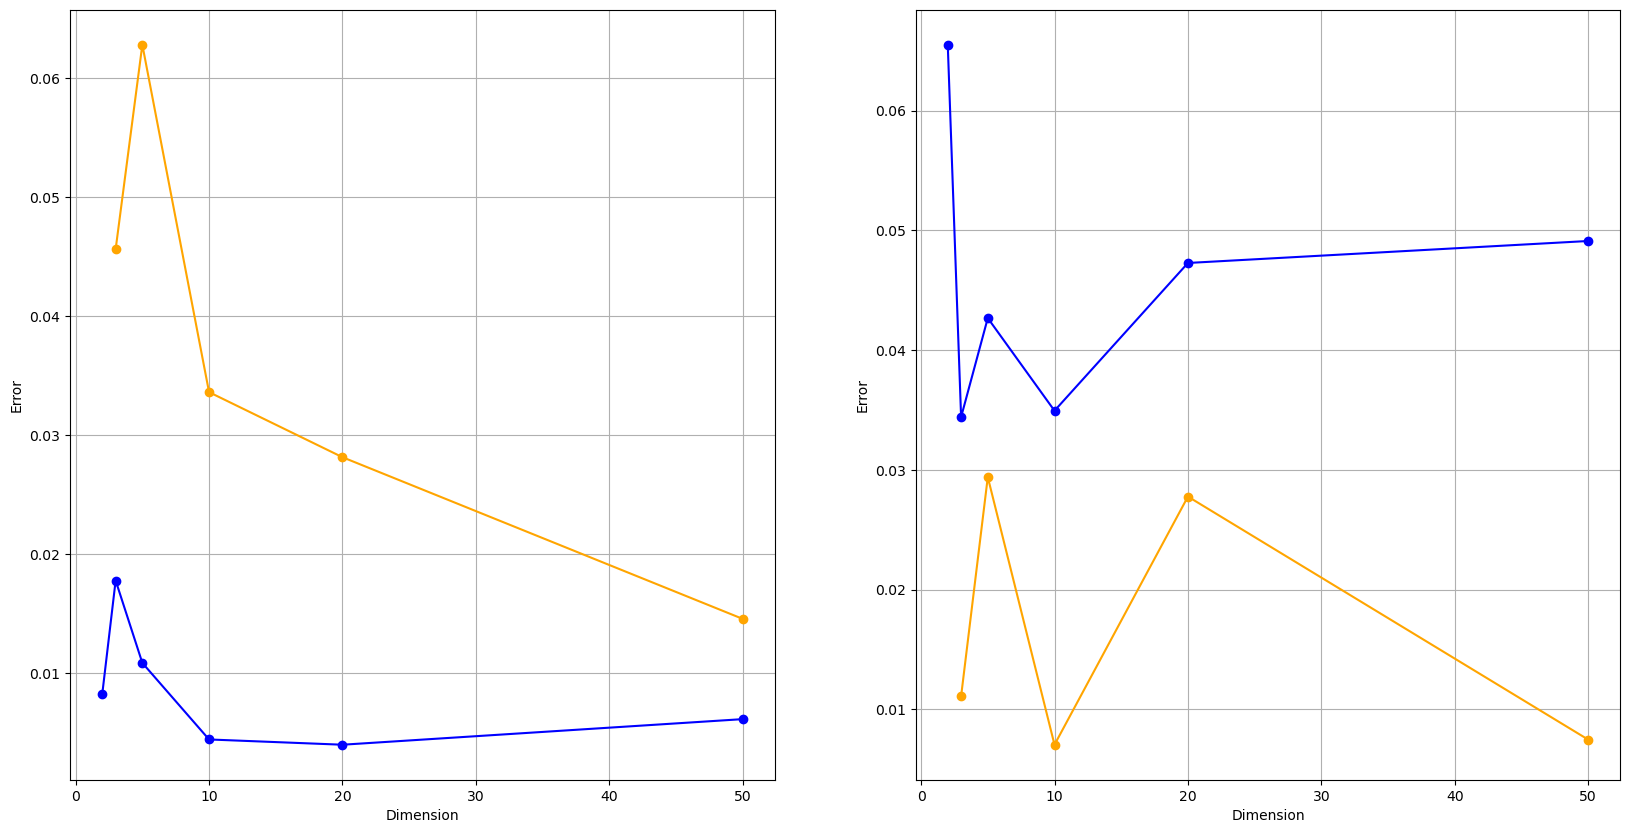

In [167]:
#Plotting time difference

rn_dims = jnp.array(dims)

rn_score_mu_error = jnp.array(rn_score_mu_error)
rn_bridge_mu_error = jnp.array(rn_bridge_mu_error)
rn_score_t_error = jnp.array(rn_score_t_error)
rn_bridge_t_error = jnp.array(rn_bridge_t_error)

print("The score diffusion mean error:")
for e in rn_score_mu_error:
    print(f"{e:.5f}")
print("The score diffusion time error:")
for e in rn_score_t_error:
    print(f"{e:.5f}")
print("The bridge diffusion mean error:")
for e in rn_bridge_mu_error:
    print(f"{e:.5f}")
print("The bridge diffusion time error:")
for e in rn_bridge_t_error:
    print(f"{e:.5f}")



fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(rn_dims, rn_score_mu_error, '-o',color='orange')
ax.plot(rn_dims, rn_bridge_mu_error, '-o', color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Error')
ax.grid(True)

ax = fig.add_subplot(122)
ax.plot(rn_dims, rn_score_t_error, '-o', color='orange')
ax.plot(rn_dims, rn_bridge_t_error, '-o', color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Error')
ax.grid(True)


### Time Estimate

In [168]:
dims = [2,3,5,10,20,50]
time_score = []
time_bridge = []

for N in dims:
    M = Euclidean(N=N)
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    x0 = (jnp.zeros(N), jnp.zeros(1))
    
    file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/R'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
        s2_val = ggrady_log(x,y,t)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

        return ggrad

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))
    
    diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
    result = %timeit -o M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), \
                                           step_size=0.01, max_iter=100)
    time_score.append(result)
    result = %timeit -o M.diffusion_mean(X_obs,num_steps=100, N=1)
    time_bridge.append(result)

using M.Exp for Logarithm
362 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Step 0 | T: 1.198213e+01 | T: ((Array([ 0.16134246, -0.11683634], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.077200e+01 | T: ((Array([ 0.15141438, -0.10692267], dtype=float32), Array(0.21992625, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.745660e+00 | T: ((Array([ 0.1416028 , -0.09715109], dtype=float32), Array(0.22973791, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.872603e+00 | T: ((Array([ 0.13194904, -0.08757468], dtype=float32), Array(0.23940013, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 8.127484e+00 | T: ((Array([ 0.12249079, -0.07824296], dtype=float32), Array(0.24888398, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.489311e+00 | T: ((Array([ 0.1132618 , -0.06920104], dtype=float32), Array(0.25816602, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.940728e+00 | T: ((Array(

Step 56 | T: 2.575804e+00 | T: ((Array([-0.01398228,  0.006155  ], dtype=float32), Array(0.48519132, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 2.566132e+00 | T: ((Array([-0.01340371,  0.00540836], dtype=float32), Array(0.48712212, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.556819e+00 | T: ((Array([-0.0128235 ,  0.00470223], dtype=float32), Array(0.48901838, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.547843e+00 | T: ((Array([-0.01224413,  0.00403697], dtype=float32), Array(0.49088168, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.539187e+00 | T: ((Array([-0.01166785,  0.00341268], dtype=float32), Array(0.49271342, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.530832e+00 | T: ((Array([-0.01109669,  0.00282919], dtype=float32), Array(0.494515, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 2.522762e+00 | T: ((Array([-0.01053248,  0.00228611], dtype=float32), Array(0.49628767, dtype=float32)), Array([0

Step 13 | T: 4.665671e+00 | T: ((Array([ 0.05039835, -0.0109366 ], dtype=float32), Array(0.32374138, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 4.478182e+00 | T: ((Array([ 0.04409868, -0.00564257], dtype=float32), Array(0.33079988, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 4.311496e+00 | T: ((Array([ 0.0381581 , -0.00079703], dtype=float32), Array(0.33761194, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 4.162790e+00 | T: ((Array([0.03257357, 0.00360881], dtype=float32), Array(0.344183, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 4.029674e+00 | T: ((Array([0.02734023, 0.00758646], dtype=float32), Array(0.3505191, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 3.910122e+00 | T: ((Array([0.02245157, 0.01114982], dtype=float32), Array(0.3566269, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 3.802405e+00 | T: ((Array([0.01789971, 0.0143146 ], dtype=float32), Array(0.36251345, dtype=float32)), Array([0.], dtype=

Step 70 | T: 2.466829e+00 | T: ((Array([-0.00642753, -0.00070624], dtype=float32), Array(0.5095589, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 2.460749e+00 | T: ((Array([-0.00597898, -0.0009292 ], dtype=float32), Array(0.5111179, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 2.454841e+00 | T: ((Array([-0.00554656, -0.00112333], dtype=float32), Array(0.5126572, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 2.449098e+00 | T: ((Array([-0.00513052, -0.00129018], dtype=float32), Array(0.5141776, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 2.443512e+00 | T: ((Array([-0.00473101, -0.00143132], dtype=float32), Array(0.51567966, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 2.438077e+00 | T: ((Array([-0.0043481 , -0.00154831], dtype=float32), Array(0.51716393, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 2.432787e+00 | T: ((Array([-0.00398179, -0.00164272], dtype=float32), Array(0.518631, dtype=float32)), Array([0.], 

Step 26 | T: 3.278866e+00 | T: ((Array([-0.00539271,  0.02686268], dtype=float32), Array(0.3981548, dtype=float32)), Array([0.], dtype=float32))
Step 27 | T: 3.226964e+00 | T: ((Array([-0.00763618,  0.02751963], dtype=float32), Array(0.40254247, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 3.179039e+00 | T: ((Array([-0.00964591,  0.02795192], dtype=float32), Array(0.4067763, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 3.134685e+00 | T: ((Array([-0.01143444,  0.02817846], dtype=float32), Array(0.4108633, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 3.093549e+00 | T: ((Array([-0.01301424,  0.02821763], dtype=float32), Array(0.41481024, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 3.055319e+00 | T: ((Array([-0.01439754,  0.02808715], dtype=float32), Array(0.4186237, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 3.019716e+00 | T: ((Array([-0.01559639,  0.02780404], dtype=float32), Array(0.42231, dtype=float32)), Array([0.], d

Step 84 | T: 2.395038e+00 | T: ((Array([-0.00162905, -0.00176538], dtype=float32), Array(0.5298047, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.390823e+00 | T: ((Array([-0.00140289, -0.00172261], dtype=float32), Array(0.53113717, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.386707e+00 | T: ((Array([-0.00119057, -0.00167116], dtype=float32), Array(0.5324565, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 2.382687e+00 | T: ((Array([-0.00099165, -0.00161213], dtype=float32), Array(0.53376305, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 2.378760e+00 | T: ((Array([-0.00080569, -0.00154658], dtype=float32), Array(0.535057, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 2.374923e+00 | T: ((Array([-0.00063223, -0.0014755 ], dtype=float32), Array(0.53633875, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 2.371172e+00 | T: ((Array([-0.00047078, -0.00139983], dtype=float32), Array(0.53760844, dtype=float32)), Array([0.]

Step 41 | T: 2.784893e+00 | T: ((Array([-0.01991083,  0.02082093], dtype=float32), Array(0.45069745, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 2.765701e+00 | T: ((Array([-0.01985283,  0.01977906], dtype=float32), Array(0.45341018, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 2.747512e+00 | T: ((Array([-0.0197193 ,  0.01872078], dtype=float32), Array(0.45605034, dtype=float32)), Array([0.], dtype=float32))
Step 44 | T: 2.730251e+00 | T: ((Array([-0.01951772,  0.01765389], dtype=float32), Array(0.45862156, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.713850e+00 | T: ((Array([-0.01925515,  0.0165855 ], dtype=float32), Array(0.4611273, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.698247e+00 | T: ((Array([-0.01893826,  0.01552204], dtype=float32), Array(0.46357086, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 2.683387e+00 | T: ((Array([-0.01857332,  0.01446931], dtype=float32), Array(0.46595535, dtype=float32)), Array([

Step 98 | T: 2.343991e+00 | T: ((Array([ 0.00044476, -0.00072185], dtype=float32), Array(0.5473616, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 2.340913e+00 | T: ((Array([ 0.0005192 , -0.00063727], dtype=float32), Array(0.54853326, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 2.340913e+00 | T: (Array([ 0.0005192 , -0.00063727], dtype=float32), Array(0.54853326, dtype=float32))
Step 0 | T: 1.198213e+01 | T: ((Array([ 0.16134246, -0.11683634], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.077200e+01 | T: ((Array([ 0.15141438, -0.10692267], dtype=float32), Array(0.21992625, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.745660e+00 | T: ((Array([ 0.1416028 , -0.09715109], dtype=float32), Array(0.22973791, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.872603e+00 | T: ((Array([ 0.13194904, -0.08757468], dtype=float32), Array(0.23940013, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 

Step 55 | T: 2.585858e+00 | T: ((Array([-0.01455647,  0.0069415 ], dtype=float32), Array(0.48322436, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.575804e+00 | T: ((Array([-0.01398228,  0.006155  ], dtype=float32), Array(0.48519132, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 2.566132e+00 | T: ((Array([-0.01340371,  0.00540836], dtype=float32), Array(0.48712212, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.556819e+00 | T: ((Array([-0.0128235 ,  0.00470223], dtype=float32), Array(0.48901838, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.547843e+00 | T: ((Array([-0.01224413,  0.00403697], dtype=float32), Array(0.49088168, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.539187e+00 | T: ((Array([-0.01166785,  0.00341268], dtype=float32), Array(0.49271342, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.530832e+00 | T: ((Array([-0.01109669,  0.00282919], dtype=float32), Array(0.494515, dtype=float32)), Array([0

Step 13 | T: 4.665671e+00 | T: ((Array([ 0.05039835, -0.0109366 ], dtype=float32), Array(0.32374138, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 4.478182e+00 | T: ((Array([ 0.04409868, -0.00564257], dtype=float32), Array(0.33079988, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 4.311496e+00 | T: ((Array([ 0.0381581 , -0.00079703], dtype=float32), Array(0.33761194, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 4.162790e+00 | T: ((Array([0.03257357, 0.00360881], dtype=float32), Array(0.344183, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 4.029674e+00 | T: ((Array([0.02734023, 0.00758646], dtype=float32), Array(0.3505191, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 3.910122e+00 | T: ((Array([0.02245157, 0.01114982], dtype=float32), Array(0.3566269, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 3.802405e+00 | T: ((Array([0.01789971, 0.0143146 ], dtype=float32), Array(0.36251345, dtype=float32)), Array([0.], dtype=

Step 71 | T: 2.460749e+00 | T: ((Array([-0.00597898, -0.0009292 ], dtype=float32), Array(0.5111179, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 2.454841e+00 | T: ((Array([-0.00554656, -0.00112333], dtype=float32), Array(0.5126572, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 2.449098e+00 | T: ((Array([-0.00513052, -0.00129018], dtype=float32), Array(0.5141776, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 2.443512e+00 | T: ((Array([-0.00473101, -0.00143132], dtype=float32), Array(0.51567966, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 2.438077e+00 | T: ((Array([-0.0043481 , -0.00154831], dtype=float32), Array(0.51716393, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 2.432787e+00 | T: ((Array([-0.00398179, -0.00164272], dtype=float32), Array(0.518631, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 2.427636e+00 | T: ((Array([-0.003632 , -0.0017161], dtype=float32), Array(0.52008134, dtype=float32)), Array([0.], d

Step 28 | T: 3.179039e+00 | T: ((Array([-0.00964591,  0.02795192], dtype=float32), Array(0.4067763, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 3.134685e+00 | T: ((Array([-0.01143444,  0.02817846], dtype=float32), Array(0.4108633, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 3.093549e+00 | T: ((Array([-0.01301424,  0.02821763], dtype=float32), Array(0.41481024, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 3.055319e+00 | T: ((Array([-0.01439754,  0.02808715], dtype=float32), Array(0.4186237, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 3.019716e+00 | T: ((Array([-0.01559639,  0.02780404], dtype=float32), Array(0.42231, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 2.986497e+00 | T: ((Array([-0.01662253,  0.02738463], dtype=float32), Array(0.4258753, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 2.955445e+00 | T: ((Array([-0.01748741,  0.02684444], dtype=float32), Array(0.42932546, dtype=float32)), Array([0.], d

Step 85 | T: 2.390823e+00 | T: ((Array([-0.00140289, -0.00172261], dtype=float32), Array(0.53113717, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.386707e+00 | T: ((Array([-0.00119057, -0.00167116], dtype=float32), Array(0.5324565, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 2.382687e+00 | T: ((Array([-0.00099165, -0.00161213], dtype=float32), Array(0.53376305, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 2.378760e+00 | T: ((Array([-0.00080569, -0.00154658], dtype=float32), Array(0.535057, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 2.374923e+00 | T: ((Array([-0.00063223, -0.0014755 ], dtype=float32), Array(0.53633875, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 2.371172e+00 | T: ((Array([-0.00047078, -0.00139983], dtype=float32), Array(0.53760844, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 2.367506e+00 | T: ((Array([-0.00032089, -0.00132045], dtype=float32), Array(0.5388664, dtype=float32)), Array([0.]

Step 41 | T: 2.784893e+00 | T: ((Array([-0.01991083,  0.02082093], dtype=float32), Array(0.45069745, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 2.765701e+00 | T: ((Array([-0.01985283,  0.01977906], dtype=float32), Array(0.45341018, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 2.747512e+00 | T: ((Array([-0.0197193 ,  0.01872078], dtype=float32), Array(0.45605034, dtype=float32)), Array([0.], dtype=float32))
Step 44 | T: 2.730251e+00 | T: ((Array([-0.01951772,  0.01765389], dtype=float32), Array(0.45862156, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.713850e+00 | T: ((Array([-0.01925515,  0.0165855 ], dtype=float32), Array(0.4611273, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.698247e+00 | T: ((Array([-0.01893826,  0.01552204], dtype=float32), Array(0.46357086, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 2.683387e+00 | T: ((Array([-0.01857332,  0.01446931], dtype=float32), Array(0.46595535, dtype=float32)), Array([

Step 98 | T: 2.343991e+00 | T: ((Array([ 0.00044476, -0.00072185], dtype=float32), Array(0.5473616, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 2.340913e+00 | T: ((Array([ 0.0005192 , -0.00063727], dtype=float32), Array(0.54853326, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 2.340913e+00 | T: (Array([ 0.0005192 , -0.00063727], dtype=float32), Array(0.54853326, dtype=float32))
15.2 s ± 328 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
using M.Exp for Logarithm
391 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Step 0 | T: 1.796741e+01 | T: ((Array([ 0.04440368,  0.21138896, -0.03716396], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.617466e+01 | T: ((Array([ 0.03452603,  0.20144887, -0.02802543], dtype=float32), Array(0.2199271, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 1.465337e+01 | T: ((Array([ 0.02485757,  0.19160455, -0.02086859], dtype=float32), Array(0.22974098, dty

Step 49 | T: 3.977552e+00 | T: ((Array([-0.02216204, -0.02260645, -0.02820365], dtype=float32), Array(0.47066098, dtype=float32)), Array([0.], dtype=float32))
Step 50 | T: 3.958457e+00 | T: ((Array([-0.0219226 , -0.02341196, -0.02781829], dtype=float32), Array(0.47287342, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 3.940191e+00 | T: ((Array([-0.02176079, -0.02415437, -0.02746019], dtype=float32), Array(0.47503772, dtype=float32)), Array([0.], dtype=float32))
Step 52 | T: 3.922697e+00 | T: ((Array([-0.02167113, -0.02483752, -0.02714365], dtype=float32), Array(0.47715622, dtype=float32)), Array([0.], dtype=float32))
Step 53 | T: 3.905925e+00 | T: ((Array([-0.02164791, -0.02546505, -0.02687973], dtype=float32), Array(0.47923115, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 3.889828e+00 | T: ((Array([-0.02168528, -0.02604043, -0.026676  ], dtype=float32), Array(0.4812646, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 3.874363e+00 | T: ((Array([-0.0217

Step 1 | T: 1.617466e+01 | T: ((Array([ 0.03452603,  0.20144887, -0.02802543], dtype=float32), Array(0.2199271, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 1.465337e+01 | T: ((Array([ 0.02485757,  0.19160455, -0.02086859], dtype=float32), Array(0.22974098, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 1.335792e+01 | T: ((Array([ 0.01548596,  0.18188848, -0.01653136], dtype=float32), Array(0.23940718, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 1.225019e+01 | T: ((Array([ 0.00649658,  0.1723297 , -0.01489631], dtype=float32), Array(0.248897, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 1.129900e+01 | T: ((Array([-0.00203104,  0.16295375, -0.01531214], dtype=float32), Array(0.2581871, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 1.047906e+01 | T: ((Array([-0.01002649,  0.15378273, -0.01711705], dtype=float32), Array(0.26725894, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 9.769620e+00 | T: ((Array([-0.01743134,  0.1

Step 53 | T: 3.905925e+00 | T: ((Array([-0.02164791, -0.02546505, -0.02687973], dtype=float32), Array(0.47923115, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 3.889828e+00 | T: ((Array([-0.02168528, -0.02604043, -0.026676  ], dtype=float32), Array(0.4812646, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 3.874363e+00 | T: ((Array([-0.02177735, -0.02656693, -0.02653651], dtype=float32), Array(0.48325855, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 3.859490e+00 | T: ((Array([-0.0219182 , -0.02704768, -0.02646194], dtype=float32), Array(0.48521483, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 3.845176e+00 | T: ((Array([-0.02210199, -0.02748563, -0.02644985], dtype=float32), Array(0.4871352, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 3.831386e+00 | T: ((Array([-0.02232298, -0.02788359, -0.02649508], dtype=float32), Array(0.48902127, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 3.818089e+00 | T: ((Array([-0.02257

Step 4 | T: 1.225019e+01 | T: ((Array([ 0.00649658,  0.1723297 , -0.01489631], dtype=float32), Array(0.248897, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 1.129900e+01 | T: ((Array([-0.00203104,  0.16295375, -0.01531214], dtype=float32), Array(0.2581871, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 1.047906e+01 | T: ((Array([-0.01002649,  0.15378273, -0.01711705], dtype=float32), Array(0.26725894, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 9.769620e+00 | T: ((Array([-0.01743134,  0.14483537, -0.01977624], dtype=float32), Array(0.27609846, dtype=float32)), Array([0.], dtype=float32))
Step 8 | T: 9.153522e+00 | T: ((Array([-0.02420101,  0.13612735, -0.02286492], dtype=float32), Array(0.28469527, dtype=float32)), Array([0.], dtype=float32))
Step 9 | T: 8.616492e+00 | T: ((Array([-0.03030575,  0.12767144, -0.0260378 ], dtype=float32), Array(0.29304227, dtype=float32)), Array([0.], dtype=float32))
Step 10 | T: 8.146615e+00 | T: ((Array([-0.03573048,  0

Step 57 | T: 3.845176e+00 | T: ((Array([-0.02210199, -0.02748563, -0.02644985], dtype=float32), Array(0.4871352, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 3.831386e+00 | T: ((Array([-0.02232298, -0.02788359, -0.02649508], dtype=float32), Array(0.48902127, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 3.818089e+00 | T: ((Array([-0.0225756 , -0.0282442 , -0.02659025], dtype=float32), Array(0.4908746, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 3.805259e+00 | T: ((Array([-0.02285446, -0.02856998, -0.02672632], dtype=float32), Array(0.4926966, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 3.792869e+00 | T: ((Array([-0.02315443, -0.0288633 , -0.02689313], dtype=float32), Array(0.49448872, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 3.780896e+00 | T: ((Array([-0.0234706 , -0.02912639, -0.02707999], dtype=float32), Array(0.49625215, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 3.769317e+00 | T: ((Array([-0.023798

Step 10 | T: 8.146615e+00 | T: ((Array([-0.03573048,  0.11947776, -0.02901522], dtype=float32), Array(0.30113518, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 7.733926e+00 | T: ((Array([-0.04047395,  0.11155396, -0.03158319], dtype=float32), Array(0.30897212, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 7.370089e+00 | T: ((Array([-0.044547  ,  0.1039055 , -0.03359736], dtype=float32), Array(0.31655315, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 7.048117e+00 | T: ((Array([-0.04797062,  0.09653586, -0.03498293], dtype=float32), Array(0.32388005, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 6.762149e+00 | T: ((Array([-0.0507739 ,  0.08944675, -0.03572719], dtype=float32), Array(0.33095592, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 6.507272e+00 | T: ((Array([-0.05299199,  0.0826383 , -0.03586665], dtype=float32), Array(0.33778504, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 6.279349e+00 | T: ((Array([-0.054

Step 62 | T: 3.780896e+00 | T: ((Array([-0.0234706 , -0.02912639, -0.02707999], dtype=float32), Array(0.49625215, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 3.769317e+00 | T: ((Array([-0.0237984 , -0.02936136, -0.02727628], dtype=float32), Array(0.49798813, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 3.758113e+00 | T: ((Array([-0.02413353, -0.02957021, -0.02747185], dtype=float32), Array(0.49969777, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 3.747264e+00 | T: ((Array([-0.02447202, -0.02975481, -0.02765756], dtype=float32), Array(0.5013822, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 3.736752e+00 | T: ((Array([-0.02481022, -0.02991694, -0.02782553], dtype=float32), Array(0.5030423, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 3.726561e+00 | T: ((Array([-0.02514485, -0.03005825, -0.02796946], dtype=float32), Array(0.5046791, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 3.716676e+00 | T: ((Array([-0.025472

Step 14 | T: 6.762149e+00 | T: ((Array([-0.0507739 ,  0.08944675, -0.03572719], dtype=float32), Array(0.33095592, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 6.507272e+00 | T: ((Array([-0.05299199,  0.0826383 , -0.03586665], dtype=float32), Array(0.33778504, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 6.279349e+00 | T: ((Array([-0.05466432,  0.07610924, -0.0354726 ], dtype=float32), Array(0.34437254, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 6.074888e+00 | T: ((Array([-0.05583303,  0.06985712, -0.03463813], dtype=float32), Array(0.3507243, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 5.890931e+00 | T: ((Array([-0.0565417 ,  0.0638784 , -0.03346777], dtype=float32), Array(0.35684678, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 5.724956e+00 | T: ((Array([-0.05683436,  0.05816866, -0.03206962], dtype=float32), Array(0.36274683, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 5.574803e+00 | T: ((Array([-0.0567

Step 66 | T: 3.736752e+00 | T: ((Array([-0.02481022, -0.02991694, -0.02782553], dtype=float32), Array(0.5030423, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 3.726561e+00 | T: ((Array([-0.02514485, -0.03005825, -0.02796946], dtype=float32), Array(0.5046791, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 3.716676e+00 | T: ((Array([-0.02547293, -0.03018032, -0.02808476], dtype=float32), Array(0.5062934, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 3.707082e+00 | T: ((Array([-0.02579183, -0.0302846 , -0.02816861], dtype=float32), Array(0.5078861, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 3.697767e+00 | T: ((Array([-0.02609926, -0.03037249, -0.02821994], dtype=float32), Array(0.50945795, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 3.688716e+00 | T: ((Array([-0.02639325, -0.03044527, -0.02823932], dtype=float32), Array(0.5110097, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 3.679919e+00 | T: ((Array([-0.02667212

Step 17 | T: 6.074888e+00 | T: ((Array([-0.05583303,  0.06985712, -0.03463813], dtype=float32), Array(0.3507243, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 5.890931e+00 | T: ((Array([-0.0565417 ,  0.0638784 , -0.03346777], dtype=float32), Array(0.35684678, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 5.724956e+00 | T: ((Array([-0.05683436,  0.05816866, -0.03206962], dtype=float32), Array(0.36274683, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 5.574803e+00 | T: ((Array([-0.05675466,  0.05272271, -0.03054944], dtype=float32), Array(0.3684317, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 5.438614e+00 | T: ((Array([-0.0563453 ,  0.04753468, -0.02900593], dtype=float32), Array(0.37390873, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 5.314784e+00 | T: ((Array([-0.05564761,  0.04259819, -0.02752692], dtype=float32), Array(0.37918553, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 5.201918e+00 | T: ((Array([-0.05470

Step 69 | T: 3.707082e+00 | T: ((Array([-0.02579183, -0.0302846 , -0.02816861], dtype=float32), Array(0.5078861, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 3.697767e+00 | T: ((Array([-0.02609926, -0.03037249, -0.02821994], dtype=float32), Array(0.50945795, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 3.688716e+00 | T: ((Array([-0.02639325, -0.03044527, -0.02823932], dtype=float32), Array(0.5110097, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 3.679919e+00 | T: ((Array([-0.02667212, -0.03050417, -0.0282288 ], dtype=float32), Array(0.512542, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 3.671365e+00 | T: ((Array([-0.02693454, -0.03055032, -0.02819164], dtype=float32), Array(0.51405555, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 3.663043e+00 | T: ((Array([-0.02717943, -0.03058479, -0.02813209], dtype=float32), Array(0.515551, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 3.654943e+00 | T: ((Array([-0.02740599,

Step 20 | T: 5.574803e+00 | T: ((Array([-0.05675466,  0.05272271, -0.03054944], dtype=float32), Array(0.3684317, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 5.438614e+00 | T: ((Array([-0.0563453 ,  0.04753468, -0.02900593], dtype=float32), Array(0.37390873, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 5.314784e+00 | T: ((Array([-0.05564761,  0.04259819, -0.02752692], dtype=float32), Array(0.37918553, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 5.201918e+00 | T: ((Array([-0.05470117,  0.0379064 , -0.02618641], dtype=float32), Array(0.3842697, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 5.098804e+00 | T: ((Array([-0.05354363,  0.03345212, -0.02504246], dtype=float32), Array(0.38916892, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 5.004379e+00 | T: ((Array([-0.05221056,  0.02922788, -0.02413602], dtype=float32), Array(0.3938907, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 4.917719e+00 | T: ((Array([-0.050735

Step 73 | T: 3.671365e+00 | T: ((Array([-0.02693454, -0.03055032, -0.02819164], dtype=float32), Array(0.51405555, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 3.663043e+00 | T: ((Array([-0.02717943, -0.03058479, -0.02813209], dtype=float32), Array(0.515551, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 3.654943e+00 | T: ((Array([-0.02740599, -0.03060857, -0.02805505], dtype=float32), Array(0.5170288, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 3.647057e+00 | T: ((Array([-0.02761368, -0.0306226 , -0.02796583], dtype=float32), Array(0.5184896, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 3.639377e+00 | T: ((Array([-0.0278022 , -0.03062775, -0.02786981], dtype=float32), Array(0.5199339, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 3.631893e+00 | T: ((Array([-0.02797145, -0.03062483, -0.02777222], dtype=float32), Array(0.5213621, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 3.624599e+00 | T: ((Array([-0.02812155,

Step 24 | T: 5.098804e+00 | T: ((Array([-0.05354363,  0.03345212, -0.02504246], dtype=float32), Array(0.38916892, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 5.004379e+00 | T: ((Array([-0.05221056,  0.02922788, -0.02413602], dtype=float32), Array(0.3938907, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 4.917719e+00 | T: ((Array([-0.05073529,  0.02522605, -0.02349088], dtype=float32), Array(0.3984426, dtype=float32)), Array([0.], dtype=float32))
Step 27 | T: 4.838012e+00 | T: ((Array([-0.04914894,  0.02143881, -0.02311443], dtype=float32), Array(0.40283197, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 4.764542e+00 | T: ((Array([-0.04748029,  0.01785828, -0.02299936], dtype=float32), Array(0.40706605, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 4.696685e+00 | T: ((Array([-0.04575585,  0.01447657, -0.02312583], dtype=float32), Array(0.4111519, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 4.633886e+00 | T: ((Array([-0.043999

Step 77 | T: 3.639377e+00 | T: ((Array([-0.0278022 , -0.03062775, -0.02786981], dtype=float32), Array(0.5199339, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 3.631893e+00 | T: ((Array([-0.02797145, -0.03062483, -0.02777222], dtype=float32), Array(0.5213621, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 3.624599e+00 | T: ((Array([-0.02812155, -0.0306146 , -0.02767788], dtype=float32), Array(0.5227748, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 3.617487e+00 | T: ((Array([-0.02825279, -0.03059776, -0.02759098], dtype=float32), Array(0.52417237, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 3.610552e+00 | T: ((Array([-0.02836563, -0.03057499, -0.02751501], dtype=float32), Array(0.5255552, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 3.603785e+00 | T: ((Array([-0.02846065, -0.03054688, -0.02745259], dtype=float32), Array(0.52692366, dtype=float32)), Array([0.], dtype=float32))
Step 83 | T: 3.597181e+00 | T: ((Array([-0.0285385

Step 24 | T: 7.918550e+00 | T: ((Array([-0.00810439,  0.02032851,  0.02843641,  0.00415475, -0.03413749],      dtype=float32), Array(0.38892734, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 7.778515e+00 | T: ((Array([-0.00829075,  0.02201794,  0.02731393,  0.00212717, -0.03035651],      dtype=float32), Array(0.39362937, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 7.650052e+00 | T: ((Array([-0.00819733,  0.02344039,  0.02602761,  0.00026291, -0.02681146],      dtype=float32), Array(0.39816082, dtype=float32)), Array([0.], dtype=float32))
Step 27 | T: 7.531944e+00 | T: ((Array([-0.00785491,  0.02461305,  0.02460789, -0.0014189 , -0.02349334],      dtype=float32), Array(0.4025291, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 7.423114e+00 | T: ((Array([-0.0072978 ,  0.02555298,  0.02308321, -0.00290461, -0.02039308],      dtype=float32), Array(0.4067414, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 7.322626e+00 | T: ((Array([-0.00656246,

Step 67 | T: 5.894586e+00 | T: ((Array([-0.00016671,  0.00358471, -0.00194163,  0.00305142,  0.0096308 ],      dtype=float32), Array(0.5030348, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 5.880376e+00 | T: ((Array([-8.1116334e-05,  3.1491776e-03, -1.6337575e-03,  2.8485514e-03,
        9.4513763e-03], dtype=float32), Array(0.5046059, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 5.866600e+00 | T: ((Array([ 2.9288683e-05,  2.7441401e-03, -1.3280089e-03,  2.6366080e-03,
        9.2640733e-03], dtype=float32), Array(0.5061551, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 5.853236e+00 | T: ((Array([ 0.00015937,  0.00236888, -0.00102706,  0.00242002,  0.00907017],      dtype=float32), Array(0.50768316, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 5.840268e+00 | T: ((Array([ 0.00030396,  0.00202259, -0.00073331,  0.00220287,  0.00887086],      dtype=float32), Array(0.50919086, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 5.8276

Step 10 | T: 1.248116e+01 | T: ((Array([ 0.01932155, -0.04000381,  0.00656129,  0.02387493, -0.11594483],      dtype=float32), Array(0.30109164, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.186027e+01 | T: ((Array([ 0.01758849, -0.03308949,  0.01155841,  0.02515914, -0.10817933],      dtype=float32), Array(0.30891967, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 1.131320e+01 | T: ((Array([ 0.01538357, -0.02659369,  0.01590853,  0.02566261, -0.10071196],      dtype=float32), Array(0.316491, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 1.082945e+01 | T: ((Array([ 0.01286356, -0.02051985,  0.01962798,  0.02549018, -0.09354652],      dtype=float32), Array(0.3238074, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 1.040023e+01 | T: ((Array([ 0.01016638, -0.01486776,  0.02274089,  0.02474501, -0.08668482],      dtype=float32), Array(0.3308719, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 1.001815e+01 | T: ((Array([ 0.00741235, -

Step 54 | T: 6.131213e+00 | T: ((Array([ 0.00228606,  0.01209486, -0.00442217,  0.00268255,  0.01044694],      dtype=float32), Array(0.48014998, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 6.108654e+00 | T: ((Array([ 0.0018783 ,  0.01126543, -0.00445043,  0.00301727,  0.0105424 ],      dtype=float32), Array(0.48210567, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 6.086987e+00 | T: ((Array([ 0.00149066,  0.01046071, -0.00442363,  0.00329072,  0.01060155],      dtype=float32), Array(0.48402324, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 6.066157e+00 | T: ((Array([ 0.00113117,  0.00968259, -0.00434706,  0.0035039 ,  0.01062754],      dtype=float32), Array(0.48590443, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 6.046115e+00 | T: ((Array([ 0.00080643,  0.00893267, -0.00422598,  0.00365876,  0.01062331],      dtype=float32), Array(0.4877509, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 6.026813e+00 | T: ((Array([ 0.00052154

Step 97 | T: 5.600195e+00 | T: ((Array([ 0.00117587, -0.00021184,  0.00200155,  0.00095965,  0.00399207],      dtype=float32), Array(0.54290754, dtype=float32)), Array([0.], dtype=float32))
Step 98 | T: 5.593629e+00 | T: ((Array([ 0.00113088, -0.0001627 ,  0.00195989,  0.00102001,  0.0038564 ],      dtype=float32), Array(0.5440373, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 5.587206e+00 | T: ((Array([ 0.00109183, -0.00011096,  0.00191473,  0.00107766,  0.00372544],      dtype=float32), Array(0.5451569, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 5.587206e+00 | T: (Array([ 0.00109183, -0.00011096,  0.00191473,  0.00107766,  0.00372544],      dtype=float32), Array(0.5451569, dtype=float32))
Step 0 | T: 2.739413e+01 | T: ((Array([-0.02445745, -0.12823029, -0.07455275, -0.04084851, -0.20727393],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.465546e+01 | T: ((Array([-0.01477871, -0.11831155, -0.06467036, -0.03

Step 40 | T: 6.586139e+00 | T: ((Array([ 0.00368306,  0.02429309,  0.00419655, -0.00609389,  0.00303639],      dtype=float32), Array(0.44747984, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 6.541560e+00 | T: ((Array([ 0.00418386,  0.02354711,  0.0029922 , -0.00549307,  0.00409075],      dtype=float32), Array(0.45022765, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 6.499451e+00 | T: ((Array([ 0.00456334,  0.02275373,  0.00187977, -0.00483471,  0.00504145],      dtype=float32), Array(0.45289806, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 6.459619e+00 | T: ((Array([ 0.00482286,  0.02192155,  0.00086148, -0.00413521,  0.00589492],      dtype=float32), Array(0.45549503, dtype=float32)), Array([0.], dtype=float32))
Step 44 | T: 6.421888e+00 | T: ((Array([ 4.9667209e-03,  2.1058558e-02, -6.1577128e-05, -3.4101526e-03,
        6.6573322e-03], dtype=float32), Array(0.4580223, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 6.386098e+00 | T: ((A

Step 83 | T: 5.709938e+00 | T: ((Array([ 0.00170162, -0.00023988,  0.00172489,  0.00049985,  0.00637606],      dtype=float32), Array(0.52591306, dtype=float32)), Array([0.], dtype=float32))
Step 84 | T: 5.700820e+00 | T: ((Array([ 0.00172285, -0.00030401,  0.00182463,  0.00046631,  0.00617846],      dtype=float32), Array(0.5272072, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 5.691927e+00 | T: ((Array([ 0.00172818, -0.00035416,  0.00190889,  0.00044848,  0.00598439],      dtype=float32), Array(0.52848786, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 5.683251e+00 | T: ((Array([ 0.00171897, -0.00039137,  0.00197832,  0.00044519,  0.00579409],      dtype=float32), Array(0.52975535, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 5.674782e+00 | T: ((Array([ 0.00169681, -0.00041664,  0.00203362,  0.00045514,  0.00560778],      dtype=float32), Array(0.53101003, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 5.666515e+00 | T: ((Array([ 0.0016635 

Step 27 | T: 7.531944e+00 | T: ((Array([-0.00785491,  0.02461305,  0.02460789, -0.0014189 , -0.02349334],      dtype=float32), Array(0.4025291, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 7.423114e+00 | T: ((Array([-0.0072978 ,  0.02555298,  0.02308321, -0.00290461, -0.02039308],      dtype=float32), Array(0.4067414, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 7.322626e+00 | T: ((Array([-0.00656246,  0.02627689,  0.02147993, -0.00418571, -0.01750156],      dtype=float32), Array(0.41080484, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 7.229650e+00 | T: ((Array([-0.00568626,  0.02680116,  0.01982236, -0.00525838, -0.01480969],      dtype=float32), Array(0.41472626, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.143456e+00 | T: ((Array([-0.00470642,  0.02714172,  0.01813277, -0.00612304, -0.01230848],      dtype=float32), Array(0.41851228, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 7.063394e+00 | T: ((Array([-0.00365908,

Step 71 | T: 5.840268e+00 | T: ((Array([ 0.00030396,  0.00202259, -0.00073331,  0.00220287,  0.00887086],      dtype=float32), Array(0.50919086, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 5.827675e+00 | T: ((Array([ 0.00045799,  0.00170439, -0.00044885,  0.00198891,  0.00866723],      dtype=float32), Array(0.5106789, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 5.815444e+00 | T: ((Array([ 0.0006166 ,  0.00141332, -0.0001755 ,  0.00178146,  0.00846029],      dtype=float32), Array(0.5121479, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 5.803556e+00 | T: ((Array([7.7527884e-04, 1.1483951e-03, 8.5185282e-05, 1.5834565e-03,
       8.2509434e-03], dtype=float32), Array(0.5135985, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 5.791999e+00 | T: ((Array([0.0009299 , 0.00090856, 0.00033191, 0.00139738, 0.00804005],      dtype=float32), Array(0.51503134, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 5.780757e+00 | T: ((Array([0.0010

Step 14 | T: 1.040023e+01 | T: ((Array([ 0.01016638, -0.01486776,  0.02274089,  0.02474501, -0.08668482],      dtype=float32), Array(0.3308719, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 1.001815e+01 | T: ((Array([ 0.00741235, -0.009634  ,  0.02527747,  0.02352562, -0.08012684],      dtype=float32), Array(0.33768883, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 9.676936e+00 | T: ((Array([ 0.00470496, -0.0048123 ,  0.02727237,  0.02192438, -0.07387105],      dtype=float32), Array(0.34426332, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 9.371289e+00 | T: ((Array([ 0.00213131, -0.00039397,  0.0287633 ,  0.02002684, -0.06791452],      dtype=float32), Array(0.35060123, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 9.096689e+00 | T: ((Array([-0.00023776,  0.0036318 ,  0.02978981,  0.01791145, -0.06225308],      dtype=float32), Array(0.35670903, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 8.849262e+00 | T: ((Array([-0.00234735

Step 58 | T: 6.046115e+00 | T: ((Array([ 0.00080643,  0.00893267, -0.00422598,  0.00365876,  0.01062331],      dtype=float32), Array(0.4877509, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 6.026813e+00 | T: ((Array([ 0.00052154,  0.00821225, -0.0040656 ,  0.00375802,  0.01059164],      dtype=float32), Array(0.48956418, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 6.008209e+00 | T: ((Array([ 0.00028011,  0.00752234, -0.00387101,  0.00380511,  0.01053514],      dtype=float32), Array(0.49134576, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.990264e+00 | T: ((Array([ 8.4341897e-05,  6.8637170e-03, -3.6471679e-03,  3.8040264e-03,
        1.0456253e-02], dtype=float32), Array(0.493097, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 5.972944e+00 | T: ((Array([-6.4957596e-05,  6.2369090e-03, -3.3988510e-03,  3.7591970e-03,
        1.0357262e-02], dtype=float32), Array(0.49481922, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 5.9562

Step 0 | T: 2.739413e+01 | T: ((Array([-0.02445745, -0.12823029, -0.07455275, -0.04084851, -0.20727393],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.465546e+01 | T: ((Array([-0.01477871, -0.11831155, -0.06467036, -0.03104497, -0.1973374 ],      dtype=float32), Array(0.21992666, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 2.233430e+01 | T: ((Array([-0.00573912, -0.10852581, -0.05498809, -0.02160071, -0.18750273],      dtype=float32), Array(0.22973937, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 2.036107e+01 | T: ((Array([ 0.00229567, -0.09892187, -0.04558865, -0.01269404, -0.17780489],      dtype=float32), Array(0.2394035, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 1.867775e+01 | T: ((Array([ 0.00899225, -0.08954494, -0.03655222, -0.00450379, -0.1682754 ],      dtype=float32), Array(0.24889027, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 1.723618e+01 | T: ((Array([ 0.0141443 , -0.0

Step 44 | T: 6.421888e+00 | T: ((Array([ 4.9667209e-03,  2.1058558e-02, -6.1577128e-05, -3.4101526e-03,
        6.6573322e-03], dtype=float32), Array(0.4580223, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 6.386098e+00 | T: ((Array([ 0.00500181,  0.02017216, -0.00088934, -0.00267408,  0.0073346 ],      dtype=float32), Array(0.46048337, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 6.352105e+00 | T: ((Array([ 0.00493715,  0.0192692 , -0.00162266, -0.0019404 ,  0.00793235],      dtype=float32), Array(0.4628816, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 6.319775e+00 | T: ((Array([ 0.0047835 ,  0.01835593, -0.00226322, -0.00122122,  0.00845599],      dtype=float32), Array(0.46522015, dtype=float32)), Array([0.], dtype=float32))
Step 48 | T: 6.288990e+00 | T: ((Array([ 0.00455289,  0.0174381 , -0.00281344, -0.00052729,  0.00891065],      dtype=float32), Array(0.467502, dtype=float32)), Array([0.], dtype=float32))
Step 49 | T: 6.259640e+00 | T: ((Arra

Step 87 | T: 5.674782e+00 | T: ((Array([ 0.00169681, -0.00041664,  0.00203362,  0.00045514,  0.00560778],      dtype=float32), Array(0.53101003, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 5.666515e+00 | T: ((Array([ 0.0016635 , -0.00043098,  0.0020756 ,  0.00047693,  0.00542566],      dtype=float32), Array(0.53225213, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 5.658443e+00 | T: ((Array([ 0.00162096, -0.00043532,  0.0021051 ,  0.00050906,  0.00524787],      dtype=float32), Array(0.53348196, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 5.650561e+00 | T: ((Array([ 0.00157117, -0.00043058,  0.00212301,  0.00055001,  0.00507454],      dtype=float32), Array(0.5346998, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.642860e+00 | T: ((Array([ 0.00151613, -0.00041764,  0.00213024,  0.00059826,  0.00490577],      dtype=float32), Array(0.53590584, dtype=float32)), Array([0.], dtype=float32))
Step 92 | T: 5.635337e+00 | T: ((Array([ 0.00145778

Step 31 | T: 7.143456e+00 | T: ((Array([-0.00470642,  0.02714172,  0.01813277, -0.00612304, -0.01230848],      dtype=float32), Array(0.41851228, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 7.063394e+00 | T: ((Array([-0.00365908,  0.02731399,  0.01643139, -0.00678388, -0.00998899],      dtype=float32), Array(0.4221694, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 6.988888e+00 | T: ((Array([-0.00257849,  0.02733286,  0.01473649, -0.00724836, -0.00784248],      dtype=float32), Array(0.42570376, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 6.919427e+00 | T: ((Array([-0.00149635,  0.02721265,  0.01306438, -0.00752672, -0.00586032],      dtype=float32), Array(0.42912138, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 6.854558e+00 | T: ((Array([-0.00044131,  0.02696703,  0.01142951, -0.00763149, -0.00403412],      dtype=float32), Array(0.43242797, dtype=float32)), Array([0.], dtype=float32))
Step 36 | T: 6.793867e+00 | T: ((Array([ 0.00056151

Step 75 | T: 5.791999e+00 | T: ((Array([0.0009299 , 0.00090856, 0.00033191, 0.00139738, 0.00804005],      dtype=float32), Array(0.51503134, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 5.780757e+00 | T: ((Array([0.00107684, 0.00069274, 0.00056365, 0.00122529, 0.00782837],      dtype=float32), Array(0.5164469, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 5.769820e+00 | T: ((Array([0.001213  , 0.00049982, 0.0007796 , 0.00106884, 0.00761662],      dtype=float32), Array(0.5178457, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 5.759175e+00 | T: ((Array([0.00133584, 0.00032868, 0.00097917, 0.00092922, 0.00740542],      dtype=float32), Array(0.5192283, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 5.748809e+00 | T: ((Array([0.00144341, 0.0001782 , 0.001162  , 0.00080727, 0.00719536],      dtype=float32), Array(0.5205951, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 5.738711e+00 | T: ((Array([1.5343354e-03, 4.7229507e-05, 1.3279086

Step 18 | T: 9.096689e+00 | T: ((Array([-0.00023776,  0.0036318 ,  0.02978981,  0.01791145, -0.06225308],      dtype=float32), Array(0.35670903, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 8.849262e+00 | T: ((Array([-0.00234735,  0.00727755,  0.03039233,  0.01564957, -0.05688157],      dtype=float32), Array(0.36259365, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 8.625700e+00 | T: ((Array([-0.004158  ,  0.01055724,  0.03061139,  0.01330552, -0.05179393],      dtype=float32), Array(0.3682623, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 8.423145e+00 | T: ((Array([-0.00564478,  0.01348594,  0.030487  ,  0.01093672, -0.04698336],      dtype=float32), Array(0.37372237, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 8.239142e+00 | T: ((Array([-0.00679618,  0.01607961,  0.03005817,  0.00859378, -0.04244245],      dtype=float32), Array(0.37898147, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 8.071557e+00 | T: ((Array([-0.00761254

Step 62 | T: 5.972944e+00 | T: ((Array([-6.4957596e-05,  6.2369090e-03, -3.3988510e-03,  3.7591970e-03,
        1.0357262e-02], dtype=float32), Array(0.49481922, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 5.956211e+00 | T: ((Array([-0.00016823,  0.00564224, -0.00313063,  0.00367539,  0.01024031],      dtype=float32), Array(0.4965136, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 5.940037e+00 | T: ((Array([-0.00022706,  0.00507982, -0.00284684,  0.0035576 ,  0.01010738],      dtype=float32), Array(0.4981813, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 5.924392e+00 | T: ((Array([-0.00024403,  0.0045496 , -0.00255157,  0.00341094,  0.00996036],      dtype=float32), Array(0.49982342, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 5.909250e+00 | T: ((Array([-0.00022255,  0.00405135, -0.00224866,  0.00324052,  0.00980096],      dtype=float32), Array(0.50144094, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 5.894586e+00 | T: ((Ar

Step 4 | T: 4.042913e+01 | T: ((Array([-4.5966250e-03,  1.7082598e-04,  2.8878988e-03, -1.6100710e-02,
       -8.1140576e-03, -7.5597405e-02,  1.0059109e-02, -1.7990997e-01,
       -1.1126596e-01, -7.1147710e-02], dtype=float32), Array(0.24891116, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 3.734303e+01 | T: ((Array([-0.01106257,  0.00642058,  0.00064484, -0.01665004, -0.00605327,
       -0.06659563,  0.01218215, -0.170565  , -0.1020821 , -0.06217928],      dtype=float32), Array(0.25821018, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 3.467998e+01 | T: ((Array([-0.016259  ,  0.01133983, -0.00231382, -0.01562436, -0.00327927,
       -0.05793926,  0.01255729, -0.1614362 , -0.09317409, -0.05356918],      dtype=float32), Array(0.26729357, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 3.237291e+01 | T: ((Array([-0.02016503,  0.01492538, -0.00507212, -0.01353052, -0.00071653,
       -0.04966488,  0.01160388, -0.15254371, -0.08456956, -0.04535565],      dty

Step 35 | T: 1.468212e+01 | T: ((Array([ 0.00437038, -0.00926321, -0.00137912, -0.00569135, -0.00386835,
        0.02221767,  0.00156256, -0.01294754,  0.01998238,  0.02136383],      dtype=float32), Array(0.4339085, dtype=float32)), Array([0.], dtype=float32))
Step 36 | T: 1.454432e+01 | T: ((Array([ 0.00359204, -0.00838362, -0.00170008, -0.00500252, -0.00341692,
        0.02130152,  0.00140272, -0.01112857,  0.020172  ,  0.02031553],      dtype=float32), Array(0.43717307, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 1.441498e+01 | T: ((Array([ 0.00275084, -0.00746501, -0.00212836, -0.00428463, -0.00293785,
        0.02031957,  0.00110202, -0.00944913,  0.02024214,  0.01921262],      dtype=float32), Array(0.44033754, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 1.429340e+01 | T: ((Array([ 0.00187013, -0.00653093, -0.00260435, -0.00357113, -0.00249365,
        0.01928433,  0.00068454, -0.00790176,  0.0202035 ,  0.01806766],      dtype=float32), Array(0.44340688

Step 66 | T: 1.250807e+01 | T: ((Array([-0.00299233, -0.00321338, -0.002862  , -0.00347358, -0.00313059,
       -0.00405913, -0.00203597,  0.00455808,  0.00391456, -0.00496714],      dtype=float32), Array(0.5048698, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 1.247374e+01 | T: ((Array([-0.00275416, -0.0034172 , -0.00274746, -0.00331137, -0.00316819,
       -0.00433823, -0.0019873 ,  0.00446618,  0.00338554, -0.0051791 ],      dtype=float32), Array(0.5065246, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 1.244044e+01 | T: ((Array([-0.00254062, -0.00359045, -0.00265805, -0.00314571, -0.00316559,
       -0.00458239, -0.00197509,  0.00436217,  0.00287823, -0.00535661],      dtype=float32), Array(0.5081566, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 1.240813e+01 | T: ((Array([-0.00235379, -0.00373226, -0.00260177, -0.00298396, -0.00312683,
       -0.00479337, -0.00199641,  0.00424746,  0.00239287, -0.00550172],      dtype=float32), Array(0.5097665, d

Step 98 | T: 1.176083e+01 | T: ((Array([-3.2133104e-03, -2.5269685e-03, -2.9444871e-03, -2.9457756e-03,
       -2.8701292e-03, -3.8053540e-03, -2.7306625e-03, -6.5261411e-05,
       -3.6804092e-03, -3.5569961e-03], dtype=float32), Array(0.5493688, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 1.174539e+01 | T: ((Array([-0.00320923, -0.00254911, -0.00293221, -0.00290908, -0.0028928 ,
       -0.00371426, -0.00271299, -0.00018435, -0.00370467, -0.00346601],      dtype=float32), Array(0.5505466, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 1.174539e+01 | T: (Array([-0.00320923, -0.00254911, -0.00293221, -0.00290908, -0.0028928 ,
       -0.00371426, -0.00271299, -0.00018435, -0.00370467, -0.00346601],      dtype=float32), Array(0.5505466, dtype=float32))
Step 0 | T: 5.893629e+01 | T: ((Array([ 0.03064671, -0.0347865 , -0.01102921,  0.00882683,  0.00466583,
       -0.11413623, -0.01836604, -0.2189252 , -0.15005489, -0.10964127],      dtype=float32), Array(0.20999993

Step 28 | T: 1.596353e+01 | T: ((Array([ 0.00599698, -0.01213576, -0.00401377, -0.00682537, -0.00251152,
        0.02555269, -0.00233486, -0.03025989,  0.01431058,  0.02591473],      dtype=float32), Array(0.40778556, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 1.573813e+01 | T: ((Array([ 0.00633893, -0.01226082, -0.00328271, -0.00725963, -0.00321462,
        0.0255214 , -0.00124221, -0.0272375 ,  0.01567553,  0.02568167],      dtype=float32), Array(0.41191006, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 1.552921e+01 | T: ((Array([ 0.00645365, -0.01216581, -0.00256727, -0.00746056, -0.00381072,
        0.02531211, -0.00030828, -0.02441248,  0.01683338,  0.025279  ],      dtype=float32), Array(0.41589305, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 1.533519e+01 | T: ((Array([ 0.00636053, -0.01187413, -0.00195211, -0.00744167, -0.00423254,
        0.02494344,  0.00044642, -0.02177612,  0.01779779,  0.02472601],      dtype=float32), Array(0.4197411

Step 59 | T: 1.278241e+01 | T: ((Array([-0.00501439, -0.00117846, -0.00321896, -0.00386036, -0.00241721,
       -0.0009982 , -0.00336286,  0.00472021,  0.00817581, -0.00235889],      dtype=float32), Array(0.49256274, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 1.273910e+01 | T: ((Array([-0.00472566, -0.00150165, -0.00330152, -0.00393288, -0.00246317,
       -0.00156324, -0.0030921 ,  0.00476217,  0.00751379, -0.00286398],      dtype=float32), Array(0.4944062, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 1.269729e+01 | T: ((Array([-0.00442611, -0.00182389, -0.00332735, -0.00395407, -0.00255549,
       -0.00208388, -0.00283855,  0.00477886,  0.00686751, -0.00332237],      dtype=float32), Array(0.4962192, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 1.265690e+01 | T: ((Array([-0.00412283, -0.00213845, -0.00329871, -0.00392773, -0.00267851,
       -0.00256105, -0.00260973,  0.00477256,  0.00623838, -0.00373543],      dtype=float32), Array(0.498003, d

Step 91 | T: 1.187874e+01 | T: ((Array([-0.00300291, -0.00259213, -0.00280688, -0.00311127, -0.00282454,
       -0.00450895, -0.00303346,  0.00086494, -0.00329414, -0.00430759],      dtype=float32), Array(0.54082835, dtype=float32)), Array([0.], dtype=float32))
Step 92 | T: 1.186076e+01 | T: ((Array([-0.00306092, -0.00255387, -0.00283997, -0.00310988, -0.00280281,
       -0.00440459, -0.00297848,  0.0007221 , -0.00337659, -0.00419063],      dtype=float32), Array(0.5420815, dtype=float32)), Array([0.], dtype=float32))
Step 93 | T: 1.184318e+01 | T: ((Array([-0.00310948, -0.0025262 , -0.00287382, -0.00309834, -0.00279209,
       -0.0043006 , -0.00292483,  0.00058245, -0.00344894, -0.00407617],      dtype=float32), Array(0.5433233, dtype=float32)), Array([0.], dtype=float32))
Step 94 | T: 1.182599e+01 | T: ((Array([-0.00314849, -0.00250871, -0.00290435, -0.0030781 , -0.00279269,
       -0.00419759, -0.00287435,  0.00044608, -0.00351181, -0.00396474],      dtype=float32), Array(0.5445539, 

Step 21 | T: 1.819034e+01 | T: ((Array([-0.00346556, -0.00398111, -0.00301277,  0.00146286, -0.0020482 ,
        0.01908639, -0.01090262, -0.05767518, -0.00222892,  0.02101457],      dtype=float32), Array(0.37436092, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 1.778238e+01 | T: ((Array([-1.3808806e-03, -5.9378073e-03, -4.0211249e-03,  1.8237624e-06,
       -1.2281252e-03,  2.0875040e-02, -9.9742422e-03, -5.3028386e-02,
        9.8142098e-04,  2.2571348e-02], dtype=float32), Array(0.37967497, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 1.741023e+01 | T: ((Array([ 0.00048315, -0.0076457 , -0.00478848, -0.0014663 , -0.00071461,
        0.02233926, -0.00884008, -0.04863882,  0.00388593,  0.02380413],      dtype=float32), Array(0.38479686, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 1.706990e+01 | T: ((Array([ 0.00210443, -0.00908761, -0.0052394 , -0.00287001, -0.00054789,
        0.02350086, -0.00756819, -0.04449845,  0.00649836,  0.02473623],     

Step 52 | T: 1.313605e+01 | T: ((Array([-0.00607414,  0.00042871, -0.00216674, -0.00206721, -0.00339629,
        0.00422626, -0.00487455,  0.00349507,  0.01308183,  0.00255178],      dtype=float32), Array(0.47867814, dtype=float32)), Array([0.], dtype=float32))
Step 53 | T: 1.307930e+01 | T: ((Array([-0.00608105,  0.00033026, -0.00222005, -0.00241355, -0.00321721,
        0.00334583, -0.00477949,  0.00379093,  0.01236965,  0.00170126],      dtype=float32), Array(0.48077866, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 1.302485e+01 | T: ((Array([-0.00602256,  0.00017344, -0.00234293, -0.00274737, -0.00301222,
        0.00250881, -0.00462514,  0.00404106,  0.01165628,  0.00089999],      dtype=float32), Array(0.48283705, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 1.297255e+01 | T: ((Array([-5.9058475e-03, -3.3091696e-05, -2.5149996e-03, -3.0557809e-03,
       -2.8089236e-03,  1.7163238e-03, -4.4224551e-03,  4.2488989e-03,
        1.0945003e-02,  1.4857081e-04],

Step 84 | T: 1.201681e+01 | T: ((Array([-0.00239449, -0.00313874, -0.0028727 , -0.00280409, -0.00299355,
       -0.00518443, -0.00326588,  0.00194092, -0.00237877, -0.00513852],      dtype=float32), Array(0.5317171, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 1.199567e+01 | T: ((Array([-0.00249435, -0.00303611, -0.00282489, -0.0028771 , -0.0029989 ,
       -0.00510026, -0.00326501,  0.00178049, -0.0025505 , -0.00502443],      dtype=float32), Array(0.5330569, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 1.197503e+01 | T: ((Array([-0.00259262, -0.00293965, -0.00278723, -0.00294302, -0.00298781,
       -0.00501027, -0.00324984,  0.00162188, -0.00270743, -0.00490719],      dtype=float32), Array(0.53438354, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 1.195488e+01 | T: ((Array([-0.00268742, -0.00285088, -0.00276321, -0.00299968, -0.00296323,
       -0.00491556, -0.00322227,  0.00146539, -0.00285026, -0.00478785],      dtype=float32), Array(0.5356972, 

Step 14 | T: 2.254083e+01 | T: ((Array([-0.02040253,  0.01313311, -0.00110543,  0.00440369, -0.00496048,
       -0.00423855, -0.00679317, -0.09796965, -0.03427362, -0.00081554],      dtype=float32), Array(0.3311695, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 2.170383e+01 | T: ((Array([-1.8191159e-02,  1.0768432e-02,  3.3754390e-05,  5.3265905e-03,
       -5.8443639e-03,  3.7856679e-04, -8.7594604e-03, -9.1344312e-02,
       -2.8600965e-02,  3.6140587e-03], dtype=float32), Array(0.33802944, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 2.095511e+01 | T: ((Array([-0.01577518,  0.00824285,  0.00060917,  0.00569168, -0.00614303,
        0.00454126, -0.01025417, -0.08501509, -0.02330627,  0.00757765],      dtype=float32), Array(0.3446491, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 2.028325e+01 | T: ((Array([-0.0132463 ,  0.00564827,  0.0006041 ,  0.00554893, -0.00588255,
        0.00826305, -0.01126067, -0.07897919, -0.01838338,  0.01109044],      d

Step 45 | T: 1.361276e+01 | T: ((Array([-0.00380333, -0.00107909, -0.00366284, -0.00062151, -0.00259124,
        0.01141409, -0.00334172, -0.00019102,  0.01768429,  0.00973605],      dtype=float32), Array(0.46260163, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 1.353464e+01 | T: ((Array([-0.00437907, -0.00059853, -0.00338969, -0.00061235, -0.00290482,
        0.01030053, -0.00380438,  0.00053953,  0.01710223,  0.00859758],      dtype=float32), Array(0.4650635, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 1.346026e+01 | T: ((Array([-0.00487206, -0.00020953, -0.00308243, -0.00069883, -0.00318598,
        0.00920898, -0.00419174,  0.00119416,  0.01648583,  0.00749036],      dtype=float32), Array(0.4674656, dtype=float32)), Array([0.], dtype=float32))
Step 48 | T: 1.338937e+01 | T: ((Array([-5.2798265e-03,  8.8004366e-05, -2.7792440e-03, -8.6857076e-04,
       -3.4030317e-03,  8.1441849e-03, -4.4968012e-03,  1.7778580e-03,
        1.5841022e-02,  6.4186756e-03], d

Step 76 | T: 1.220612e+01 | T: ((Array([-0.00182617, -0.00391147, -0.0029493 , -0.00236409, -0.00267883,
       -0.00549274, -0.00269752,  0.00324407, -0.00039289, -0.00578322],      dtype=float32), Array(0.52048033, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 1.218029e+01 | T: ((Array([-0.0018502 , -0.00384511, -0.00300776, -0.00237067, -0.00268784,
       -0.00550322, -0.00281559,  0.00308375, -0.00070648, -0.00574246],      dtype=float32), Array(0.52193904, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 1.215512e+01 | T: ((Array([-0.00189303, -0.00376414, -0.00304503, -0.00239811, -0.00271924,
       -0.00549658, -0.00292465,  0.00292157, -0.00100023, -0.00568708],      dtype=float32), Array(0.5233814, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 1.213060e+01 | T: ((Array([-0.00195202, -0.00367163, -0.00305875, -0.0024433 , -0.00276699,
       -0.00547444, -0.00302155,  0.00275814, -0.00127468, -0.0056188 ],      dtype=float32), Array(0.52480793

Step 6 | T: 3.467998e+01 | T: ((Array([-0.016259  ,  0.01133983, -0.00231382, -0.01562436, -0.00327927,
       -0.05793926,  0.01255729, -0.1614362 , -0.09317409, -0.05356918],      dtype=float32), Array(0.26729357, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 3.237291e+01 | T: ((Array([-0.02016503,  0.01492538, -0.00507212, -0.01353052, -0.00071653,
       -0.04966488,  0.01160388, -0.15254371, -0.08456956, -0.04535565],      dtype=float32), Array(0.27614728, dtype=float32)), Array([0.], dtype=float32))
Step 8 | T: 3.036640e+01 | T: ((Array([-0.02283995,  0.017258  , -0.00695901, -0.01078189,  0.0009681 ,
       -0.04180299,  0.00970163, -0.14390442, -0.07629178, -0.03757046],      dtype=float32), Array(0.28476086, dtype=float32)), Array([0.], dtype=float32))
Step 9 | T: 2.861447e+01 | T: ((Array([-0.0243966 ,  0.01847034, -0.0076826 , -0.00771637,  0.00150676,
       -0.03437786,  0.00717246, -0.13553208, -0.0683597 , -0.03023871],      dtype=float32), Array(0.29312718, d

Step 37 | T: 1.441498e+01 | T: ((Array([ 0.00275084, -0.00746501, -0.00212836, -0.00428463, -0.00293785,
        0.02031957,  0.00110202, -0.00944913,  0.02024214,  0.01921262],      dtype=float32), Array(0.44033754, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 1.429340e+01 | T: ((Array([ 0.00187013, -0.00653093, -0.00260435, -0.00357113, -0.00249365,
        0.01928433,  0.00068454, -0.00790176,  0.0202035 ,  0.01806766],      dtype=float32), Array(0.44340688, dtype=float32)), Array([0.], dtype=float32))
Step 39 | T: 1.417894e+01 | T: ((Array([ 0.00097181, -0.00560298, -0.00306858, -0.00289212, -0.00213658,
        0.01820739,  0.00017629, -0.00647921,  0.02006633,  0.01689225],      dtype=float32), Array(0.44638586, dtype=float32)), Array([0.], dtype=float32))
Step 40 | T: 1.407101e+01 | T: ((Array([ 7.6082593e-05, -4.7005937e-03, -3.4685200e-03, -2.2733787e-03,
       -1.9031182e-03,  1.7099511e-02, -3.9592205e-04, -5.1744804e-03,
        1.9840356e-02,  1.5697049e-02],

Step 68 | T: 1.244044e+01 | T: ((Array([-0.00254062, -0.00359045, -0.00265805, -0.00314571, -0.00316559,
       -0.00458239, -0.00197509,  0.00436217,  0.00287823, -0.00535661],      dtype=float32), Array(0.5081566, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 1.240813e+01 | T: ((Array([-0.00235379, -0.00373226, -0.00260177, -0.00298396, -0.00312683,
       -0.00479337, -0.00199641,  0.00424746,  0.00239287, -0.00550172],      dtype=float32), Array(0.5097665, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 1.237676e+01 | T: ((Array([-0.00219502, -0.00384252, -0.00258206, -0.0028326 , -0.00306008,
       -0.00497294, -0.00204738,  0.00412338,  0.00192958, -0.00561651],      dtype=float32), Array(0.5113552, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 1.234629e+01 | T: ((Array([-0.00206495, -0.0039218 , -0.0025978 , -0.00269712, -0.00297625,
       -0.00512292, -0.00212342,  0.00399113,  0.00148837, -0.00570305],      dtype=float32), Array(0.5129234, d

Step 99 | T: 1.174539e+01 | T: ((Array([-0.00320923, -0.00254911, -0.00293221, -0.00290908, -0.0028928 ,
       -0.00371426, -0.00271299, -0.00018435, -0.00370467, -0.00346601],      dtype=float32), Array(0.5505466, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 1.174539e+01 | T: (Array([-0.00320923, -0.00254911, -0.00293221, -0.00290908, -0.0028928 ,
       -0.00371426, -0.00271299, -0.00018435, -0.00370467, -0.00346601],      dtype=float32), Array(0.5505466, dtype=float32))
Step 0 | T: 5.893629e+01 | T: ((Array([ 0.03064671, -0.0347865 , -0.01102921,  0.00882683,  0.00466583,
       -0.11413623, -0.01836604, -0.2189252 , -0.15005489, -0.10964127],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 5.314234e+01 | T: ((Array([ 2.0891702e-02, -2.5043817e-02, -5.4281014e-03, -4.6229549e-04,
       -6.7975838e-05, -1.0422553e-01, -8.9050243e-03, -2.0898768e-01,
       -1.4013036e-01, -9.9733025e-02], dtype=float32), Array(0.21992807

Step 29 | T: 1.573813e+01 | T: ((Array([ 0.00633893, -0.01226082, -0.00328271, -0.00725963, -0.00321462,
        0.0255214 , -0.00124221, -0.0272375 ,  0.01567553,  0.02568167],      dtype=float32), Array(0.41191006, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 1.552921e+01 | T: ((Array([ 0.00645365, -0.01216581, -0.00256727, -0.00746056, -0.00381072,
        0.02531211, -0.00030828, -0.02441248,  0.01683338,  0.025279  ],      dtype=float32), Array(0.41589305, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 1.533519e+01 | T: ((Array([ 0.00636053, -0.01187413, -0.00195211, -0.00744167, -0.00423254,
        0.02494344,  0.00044642, -0.02177612,  0.01779779,  0.02472601],      dtype=float32), Array(0.41974115, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 1.515466e+01 | T: ((Array([ 0.00608149, -0.0114112 , -0.00150138, -0.00722485, -0.00444221,
        0.02443317,  0.00101031, -0.01931984,  0.01858212,  0.02404106],      dtype=float32), Array(0.4234607

Step 60 | T: 1.273910e+01 | T: ((Array([-0.00472566, -0.00150165, -0.00330152, -0.00393288, -0.00246317,
       -0.00156324, -0.0030921 ,  0.00476217,  0.00751379, -0.00286398],      dtype=float32), Array(0.4944062, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 1.269729e+01 | T: ((Array([-0.00442611, -0.00182389, -0.00332735, -0.00395407, -0.00255549,
       -0.00208388, -0.00283855,  0.00477886,  0.00686751, -0.00332237],      dtype=float32), Array(0.4962192, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 1.265690e+01 | T: ((Array([-0.00412283, -0.00213845, -0.00329871, -0.00392773, -0.00267851,
       -0.00256105, -0.00260973,  0.00477256,  0.00623838, -0.00373543],      dtype=float32), Array(0.498003, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 1.261785e+01 | T: ((Array([-0.00382231, -0.00243936, -0.00322388, -0.00385937, -0.00281417,
       -0.00299583, -0.00241159,  0.0047454 ,  0.0056276 , -0.0041047 ],      dtype=float32), Array(0.49975887, d

Step 92 | T: 1.186076e+01 | T: ((Array([-0.00306092, -0.00255387, -0.00283997, -0.00310988, -0.00280281,
       -0.00440459, -0.00297848,  0.0007221 , -0.00337659, -0.00419063],      dtype=float32), Array(0.5420815, dtype=float32)), Array([0.], dtype=float32))
Step 93 | T: 1.184318e+01 | T: ((Array([-0.00310948, -0.0025262 , -0.00287382, -0.00309834, -0.00279209,
       -0.0043006 , -0.00292483,  0.00058245, -0.00344894, -0.00407617],      dtype=float32), Array(0.5433233, dtype=float32)), Array([0.], dtype=float32))
Step 94 | T: 1.182599e+01 | T: ((Array([-0.00314849, -0.00250871, -0.00290435, -0.0030781 , -0.00279269,
       -0.00419759, -0.00287435,  0.00044608, -0.00351181, -0.00396474],      dtype=float32), Array(0.5445539, dtype=float32)), Array([0.], dtype=float32))
Step 95 | T: 1.180917e+01 | T: ((Array([-0.00317802, -0.00250084, -0.00292826, -0.00305087, -0.00280348,
       -0.0040961 , -0.00282862,  0.00031306, -0.0035658 , -0.00385675],      dtype=float32), Array(0.54577357, 

Step 22 | T: 1.778238e+01 | T: ((Array([-1.3808806e-03, -5.9378073e-03, -4.0211249e-03,  1.8237624e-06,
       -1.2281252e-03,  2.0875040e-02, -9.9742422e-03, -5.3028386e-02,
        9.8142098e-04,  2.2571348e-02], dtype=float32), Array(0.37967497, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 1.741023e+01 | T: ((Array([ 0.00048315, -0.0076457 , -0.00478848, -0.0014663 , -0.00071461,
        0.02233926, -0.00884008, -0.04863882,  0.00388593,  0.02380413],      dtype=float32), Array(0.38479686, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 1.706990e+01 | T: ((Array([ 0.00210443, -0.00908761, -0.0052394 , -0.00287001, -0.00054789,
        0.02350086, -0.00756819, -0.04449845,  0.00649836,  0.02473623],      dtype=float32), Array(0.38973415, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 1.675792e+01 | T: ((Array([ 0.00346921, -0.010255  , -0.00534853, -0.00414894, -0.00071494,
        0.02438165, -0.00622409, -0.04059897,  0.00883277,  0.02539079],     

Step 53 | T: 1.307930e+01 | T: ((Array([-0.00608105,  0.00033026, -0.00222005, -0.00241355, -0.00321721,
        0.00334583, -0.00477949,  0.00379093,  0.01236965,  0.00170126],      dtype=float32), Array(0.48077866, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 1.302485e+01 | T: ((Array([-0.00602256,  0.00017344, -0.00234293, -0.00274737, -0.00301222,
        0.00250881, -0.00462514,  0.00404106,  0.01165628,  0.00089999],      dtype=float32), Array(0.48283705, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 1.297255e+01 | T: ((Array([-5.9058475e-03, -3.3091696e-05, -2.5149996e-03, -3.0557809e-03,
       -2.8089236e-03,  1.7163238e-03, -4.4224551e-03,  4.2488989e-03,
        1.0945003e-02,  1.4857081e-04], dtype=float32), Array(0.48485532, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 1.292227e+01 | T: ((Array([-0.00573861, -0.00028042, -0.0027121 , -0.00332814, -0.00263222,
        0.00096914, -0.0041831 ,  0.00441774,  0.01023879, -0.00055276],     

Step 85 | T: 1.199567e+01 | T: ((Array([-0.00249435, -0.00303611, -0.00282489, -0.0028771 , -0.0029989 ,
       -0.00510026, -0.00326501,  0.00178049, -0.0025505 , -0.00502443],      dtype=float32), Array(0.5330569, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 1.197503e+01 | T: ((Array([-0.00259262, -0.00293965, -0.00278723, -0.00294302, -0.00298781,
       -0.00501027, -0.00324984,  0.00162188, -0.00270743, -0.00490719],      dtype=float32), Array(0.53438354, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 1.195488e+01 | T: ((Array([-0.00268742, -0.00285088, -0.00276321, -0.00299968, -0.00296323,
       -0.00491556, -0.00322227,  0.00146539, -0.00285026, -0.00478785],      dtype=float32), Array(0.5356972, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 1.193518e+01 | T: ((Array([-0.0027771 , -0.00277099, -0.00275435, -0.00304551, -0.00292954,
       -0.00481715, -0.00318448,  0.00131124, -0.00297967, -0.00466738],      dtype=float32), Array(0.5369983, 

Step 15 | T: 2.170383e+01 | T: ((Array([-1.8191159e-02,  1.0768432e-02,  3.3754390e-05,  5.3265905e-03,
       -5.8443639e-03,  3.7856679e-04, -8.7594604e-03, -9.1344312e-02,
       -2.8600965e-02,  3.6140587e-03], dtype=float32), Array(0.33802944, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 2.095511e+01 | T: ((Array([-0.01577518,  0.00824285,  0.00060917,  0.00569168, -0.00614303,
        0.00454126, -0.01025417, -0.08501509, -0.02330627,  0.00757765],      dtype=float32), Array(0.3446491, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 2.028325e+01 | T: ((Array([-0.0132463 ,  0.00564827,  0.0006041 ,  0.00554893, -0.00588255,
        0.00826305, -0.01126067, -0.07897919, -0.01838338,  0.01109044],      dtype=float32), Array(0.3510342, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 1.967855e+01 | T: ((Array([-1.0685470e-02,  3.0650361e-03,  9.2111528e-05,  4.9689729e-03,
       -5.1740105e-03,  1.1559891e-02, -1.1789373e-02, -7.3232643e-02,
       -1

Step 46 | T: 1.353464e+01 | T: ((Array([-0.00437907, -0.00059853, -0.00338969, -0.00061235, -0.00290482,
        0.01030053, -0.00380438,  0.00053953,  0.01710223,  0.00859758],      dtype=float32), Array(0.4650635, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 1.346026e+01 | T: ((Array([-0.00487206, -0.00020953, -0.00308243, -0.00069883, -0.00318598,
        0.00920898, -0.00419174,  0.00119416,  0.01648583,  0.00749036],      dtype=float32), Array(0.4674656, dtype=float32)), Array([0.], dtype=float32))
Step 48 | T: 1.338937e+01 | T: ((Array([-5.2798265e-03,  8.8004366e-05, -2.7792440e-03, -8.6857076e-04,
       -3.4030317e-03,  8.1441849e-03, -4.4968012e-03,  1.7778580e-03,
        1.5841022e-02,  6.4186756e-03], dtype=float32), Array(0.4698109, dtype=float32)), Array([0.], dtype=float32))
Step 49 | T: 1.332172e+01 | T: ((Array([-0.00560185,  0.00029613, -0.00251438, -0.00110683, -0.0035351 ,
        0.00711025, -0.00471614,  0.00229539,  0.01517331,  0.00538619],      dt

Step 77 | T: 1.218029e+01 | T: ((Array([-0.0018502 , -0.00384511, -0.00300776, -0.00237067, -0.00268784,
       -0.00550322, -0.00281559,  0.00308375, -0.00070648, -0.00574246],      dtype=float32), Array(0.52193904, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 1.215512e+01 | T: ((Array([-0.00189303, -0.00376414, -0.00304503, -0.00239811, -0.00271924,
       -0.00549658, -0.00292465,  0.00292157, -0.00100023, -0.00568708],      dtype=float32), Array(0.5233814, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 1.213060e+01 | T: ((Array([-0.00195202, -0.00367163, -0.00305875, -0.0024433 , -0.00276699,
       -0.00547444, -0.00302155,  0.00275814, -0.00127468, -0.0056188 ],      dtype=float32), Array(0.52480793, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 1.210670e+01 | T: ((Array([-0.00202446, -0.00357066, -0.00304952, -0.00250265, -0.00282357,
       -0.00543838, -0.00310391,  0.00259406, -0.00153042, -0.00553927],      dtype=float32), Array(0.526219, 

Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.00150921, -0.0054392 ,  0.05876327,  0.08947085, -0.02979797,
        0.0024773 , -0.07574767, -0.0611046 , -0.00128061, -0.01120214],      dtype=float32), Array(0.25819835, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.557745e+01 | T: ((Array([-0.06828415,  0.00884931, -0.05337097,  0.02095284, -0.00242809,
       -0.01244955, -0.02315599, -0.12742282, -0.01450293,  0.00713986,
       -0.00807564, -0.00251574,  0.05013712,  0.0806043 , -0.02174007,
        0.00838882, -0.06700169, -0.05249677,  0.00514665, -0.00840912],      dtype=float32), Array(0.26727614, dtype=float32)), Array([0.], dtype=float32))
Step 7 | T: 6.123523e+01 | T: ((Array([-0.05987856,  0.00626092, -0.04514766,  0.01335171,  0.00063025,
       -0.01719839, -0.01561748, -0.11863816, -0.00733069,  0.01216623,
       -0.0136

Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.00199886,  0.02289467, -0.01073538,  0.01783019, -0.00443341,
       -0.00344545,  0.00013886, -0.03044304, -0.01980658,  0.02221207,
       -0.00598409,  0.02314814,  0.02667854, -0.0019426 , -0.00625579],      dtype=float32), Array(0.39881617, dtype=float32)), Array([0.], dtype=float32))
Step 27 | T: 3.098516e+01 | T: ((Array([ 0.02361172,  0.00242127,  0.02674541, -0.026404  , -0.00088717,
        0.003388

Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.00082277, -0.00472466,  0.01339415, -0.00803834, -0.00427263,
        0.0024058 , -0.00162733, -0.01403203, -0.02154418, -0.00535285,
       -0.00323346,  0.01431305,  0.00933156, -0.00573625, -0.00255553],      dtype=float32), Array(0.46432698, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 2.588779e+01 | T: ((Array([ 0.01365795, -0.00353055,  0.00858068,  0.00056838, -0.00265317,
       -0.001510

Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.00207436, -0.00400815,  0.00173254, -0.00252849,
       -0.00343888, -0.00550324,  0.00825454, -0.00364863, -0.00020443,
       -0.00428065, -0.00210083, -0.00017817, -0.00720112, -0.00526959,
       -0.00057635, -0.00094095, -0.0041798 ,  0.00016164, -0.00139117],      dtype=float32), Array(0.50352764, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 2.408618e+01 | T: ((Array([-1.0461870e-03, -2.2312878e-03, -4.2288504e-03,  1.4517957e-03,
       -2.5015993e-

Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.0634071e-04, -2.7785301e-03, -1.4095440e-03, -2.1230879e-03,
        5.9460035e-05, -1.3224756e-03, -1.1425713e-03, -2.7341878e-03,
       -4.0047085e-03, -4.0298440e-03, -2.7105233e-03, -1.9154501e-03],      dtype=float32), Array(0.53238547, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 2.315120e+01 | T: ((Array([-3.9307619e-03, -1.7346159e-03, -3.9440859e-03, -2.6637129e-03,
       -2.1532478e

Step 4 | T: 7.643330e+01 | T: ((Array([-0.08611424,  0.01083517, -0.07096227,  0.03773216, -0.0089595 ,
        0.00046154, -0.0398536 , -0.14575307, -0.03072156, -0.00616863,
        0.00598715, -0.00765304,  0.06774325,  0.0986246 , -0.03837029,
       -0.0045336 , -0.08481412, -0.07007138, -0.00867473, -0.01300291],      dtype=float32), Array(0.24890381, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.00150921, -0.0054392 ,  0.05876327,  0.08947085, -0.02979797,
        0.0024773 , -0.07574767, -0.0611046 , -0.00128061, -0.01120214],      dtype=float32), Array(0.25819835, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.557745e+01 | T: ((Array([-0.06828415,  0.00884931, -0.05337097,  0.02095284, -0.00242809,
       -0.01244955, -0.02315599, -0.12742282, -0.01450293,  0.00713986,
       -0.0080

Step 24 | T: 3.259571e+01 | T: ((Array([ 0.02015682,  0.00026529,  0.02542476, -0.0298915 , -0.003781  ,
       -0.00143388,  0.02528434, -0.01705664,  0.02119786, -0.00073483,
       -0.00754176,  0.00037114, -0.02923944, -0.01593608,  0.02476991,
       -0.00254337,  0.0207058 ,  0.0256487 ,  0.00204538, -0.00663305],      dtype=float32), Array(0.38950044, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.001998

Step 44 | T: 2.631985e+01 | T: ((Array([ 0.01663943, -0.00430719,  0.0119868 , -0.00184131, -0.00346894,
        0.00067771, -0.00315172,  0.0130883 , -0.00722685, -0.00577586,
        0.00374937, -0.00109634, -0.01632167, -0.02297234, -0.00388461,
       -0.00473471,  0.01633559,  0.01163976, -0.00715766, -0.00171569],      dtype=float32), Array(0.45939526, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.000822

Step 64 | T: 2.427907e+01 | T: ((Array([ 2.9829628e-04, -1.7098363e-03, -3.4549083e-03,  2.2647667e-03,
       -2.4661585e-03, -3.9240550e-03, -6.0912278e-03,  9.0343775e-03,
       -4.3800292e-03,  1.9784746e-04, -4.4279988e-03, -1.8463152e-03,
       -7.5671310e-04, -8.3121788e-03, -5.8960468e-03, -9.3045368e-05,
       -3.4362893e-05, -3.6550972e-03,  4.0414141e-04, -1.2915651e-03],      dtype=float32), Array(0.5002095, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.0

Step 84 | T: 2.326220e+01 | T: ((Array([-0.00395777, -0.00177167, -0.00428789, -0.00238869, -0.00202431,
       -0.00119935, -0.00142576,  0.00221094, -0.00075439, -0.00281053,
       -0.0015198 , -0.00205549,  0.00027599, -0.00155667, -0.00127266,
       -0.0028282 , -0.00403263, -0.00426682, -0.00264677, -0.00203209],      dtype=float32), Array(0.5297857, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.06340

Step 3 | T: 8.323359e+01 | T: ((Array([-0.09546749,  0.00904961, -0.08024825,  0.04679224, -0.01107264,
        0.00844633, -0.04889112, -0.15524906, -0.03962716, -0.01426673,
        0.01429757, -0.00801762,  0.07703339,  0.10803181, -0.04738921,
       -0.01252163, -0.09416238, -0.07935268, -0.01691755, -0.01307638],      dtype=float32), Array(0.23941083, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.643330e+01 | T: ((Array([-0.08611424,  0.01083517, -0.07096227,  0.03773216, -0.0089595 ,
        0.00046154, -0.0398536 , -0.14575307, -0.03072156, -0.00616863,
        0.00598715, -0.00765304,  0.06774325,  0.0986246 , -0.03837029,
       -0.0045336 , -0.08481412, -0.07007138, -0.00867473, -0.01300291],      dtype=float32), Array(0.24890381, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.0015

Step 24 | T: 3.259571e+01 | T: ((Array([ 0.02015682,  0.00026529,  0.02542476, -0.0298915 , -0.003781  ,
       -0.00143388,  0.02528434, -0.01705664,  0.02119786, -0.00073483,
       -0.00754176,  0.00037114, -0.02923944, -0.01593608,  0.02476991,
       -0.00254337,  0.0207058 ,  0.0256487 ,  0.00204538, -0.00663305],      dtype=float32), Array(0.38950044, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.001998

Step 44 | T: 2.631985e+01 | T: ((Array([ 0.01663943, -0.00430719,  0.0119868 , -0.00184131, -0.00346894,
        0.00067771, -0.00315172,  0.0130883 , -0.00722685, -0.00577586,
        0.00374937, -0.00109634, -0.01632167, -0.02297234, -0.00388461,
       -0.00473471,  0.01633559,  0.01163976, -0.00715766, -0.00171569],      dtype=float32), Array(0.45939526, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.000822

Step 64 | T: 2.427907e+01 | T: ((Array([ 2.9829628e-04, -1.7098363e-03, -3.4549083e-03,  2.2647667e-03,
       -2.4661585e-03, -3.9240550e-03, -6.0912278e-03,  9.0343775e-03,
       -4.3800292e-03,  1.9784746e-04, -4.4279988e-03, -1.8463152e-03,
       -7.5671310e-04, -8.3121788e-03, -5.8960468e-03, -9.3045368e-05,
       -3.4362893e-05, -3.6550972e-03,  4.0414141e-04, -1.2915651e-03],      dtype=float32), Array(0.5002095, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.0

Step 84 | T: 2.326220e+01 | T: ((Array([-0.00395777, -0.00177167, -0.00428789, -0.00238869, -0.00202431,
       -0.00119935, -0.00142576,  0.00221094, -0.00075439, -0.00281053,
       -0.0015198 , -0.00205549,  0.00027599, -0.00155667, -0.00127266,
       -0.0028282 , -0.00403263, -0.00426682, -0.00264677, -0.00203209],      dtype=float32), Array(0.5297857, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.06340

Step 3 | T: 8.323359e+01 | T: ((Array([-0.09546749,  0.00904961, -0.08024825,  0.04679224, -0.01107264,
        0.00844633, -0.04889112, -0.15524906, -0.03962716, -0.01426673,
        0.01429757, -0.00801762,  0.07703339,  0.10803181, -0.04738921,
       -0.01252163, -0.09416238, -0.07935268, -0.01691755, -0.01307638],      dtype=float32), Array(0.23941083, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.643330e+01 | T: ((Array([-0.08611424,  0.01083517, -0.07096227,  0.03773216, -0.0089595 ,
        0.00046154, -0.0398536 , -0.14575307, -0.03072156, -0.00616863,
        0.00598715, -0.00765304,  0.06774325,  0.0986246 , -0.03837029,
       -0.0045336 , -0.08481412, -0.07007138, -0.00867473, -0.01300291],      dtype=float32), Array(0.24890381, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.0015

Step 24 | T: 3.259571e+01 | T: ((Array([ 0.02015682,  0.00026529,  0.02542476, -0.0298915 , -0.003781  ,
       -0.00143388,  0.02528434, -0.01705664,  0.02119786, -0.00073483,
       -0.00754176,  0.00037114, -0.02923944, -0.01593608,  0.02476991,
       -0.00254337,  0.0207058 ,  0.0256487 ,  0.00204538, -0.00663305],      dtype=float32), Array(0.38950044, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.001998

Step 44 | T: 2.631985e+01 | T: ((Array([ 0.01663943, -0.00430719,  0.0119868 , -0.00184131, -0.00346894,
        0.00067771, -0.00315172,  0.0130883 , -0.00722685, -0.00577586,
        0.00374937, -0.00109634, -0.01632167, -0.02297234, -0.00388461,
       -0.00473471,  0.01633559,  0.01163976, -0.00715766, -0.00171569],      dtype=float32), Array(0.45939526, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.000822

Step 64 | T: 2.427907e+01 | T: ((Array([ 2.9829628e-04, -1.7098363e-03, -3.4549083e-03,  2.2647667e-03,
       -2.4661585e-03, -3.9240550e-03, -6.0912278e-03,  9.0343775e-03,
       -4.3800292e-03,  1.9784746e-04, -4.4279988e-03, -1.8463152e-03,
       -7.5671310e-04, -8.3121788e-03, -5.8960468e-03, -9.3045368e-05,
       -3.4362893e-05, -3.6550972e-03,  4.0414141e-04, -1.2915651e-03],      dtype=float32), Array(0.5002095, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.0

Step 84 | T: 2.326220e+01 | T: ((Array([-0.00395777, -0.00177167, -0.00428789, -0.00238869, -0.00202431,
       -0.00119935, -0.00142576,  0.00221094, -0.00075439, -0.00281053,
       -0.0015198 , -0.00205549,  0.00027599, -0.00155667, -0.00127266,
       -0.0028282 , -0.00403263, -0.00426682, -0.00264677, -0.00203209],      dtype=float32), Array(0.5297857, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.06340

Step 3 | T: 8.323359e+01 | T: ((Array([-0.09546749,  0.00904961, -0.08024825,  0.04679224, -0.01107264,
        0.00844633, -0.04889112, -0.15524906, -0.03962716, -0.01426673,
        0.01429757, -0.00801762,  0.07703339,  0.10803181, -0.04738921,
       -0.01252163, -0.09416238, -0.07935268, -0.01691755, -0.01307638],      dtype=float32), Array(0.23941083, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.643330e+01 | T: ((Array([-0.08611424,  0.01083517, -0.07096227,  0.03773216, -0.0089595 ,
        0.00046154, -0.0398536 , -0.14575307, -0.03072156, -0.00616863,
        0.00598715, -0.00765304,  0.06774325,  0.0986246 , -0.03837029,
       -0.0045336 , -0.08481412, -0.07007138, -0.00867473, -0.01300291],      dtype=float32), Array(0.24890381, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.0015

Step 24 | T: 3.259571e+01 | T: ((Array([ 0.02015682,  0.00026529,  0.02542476, -0.0298915 , -0.003781  ,
       -0.00143388,  0.02528434, -0.01705664,  0.02119786, -0.00073483,
       -0.00754176,  0.00037114, -0.02923944, -0.01593608,  0.02476991,
       -0.00254337,  0.0207058 ,  0.0256487 ,  0.00204538, -0.00663305],      dtype=float32), Array(0.38950044, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.001998

Step 44 | T: 2.631985e+01 | T: ((Array([ 0.01663943, -0.00430719,  0.0119868 , -0.00184131, -0.00346894,
        0.00067771, -0.00315172,  0.0130883 , -0.00722685, -0.00577586,
        0.00374937, -0.00109634, -0.01632167, -0.02297234, -0.00388461,
       -0.00473471,  0.01633559,  0.01163976, -0.00715766, -0.00171569],      dtype=float32), Array(0.45939526, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.000822

Step 64 | T: 2.427907e+01 | T: ((Array([ 2.9829628e-04, -1.7098363e-03, -3.4549083e-03,  2.2647667e-03,
       -2.4661585e-03, -3.9240550e-03, -6.0912278e-03,  9.0343775e-03,
       -4.3800292e-03,  1.9784746e-04, -4.4279988e-03, -1.8463152e-03,
       -7.5671310e-04, -8.3121788e-03, -5.8960468e-03, -9.3045368e-05,
       -3.4362893e-05, -3.6550972e-03,  4.0414141e-04, -1.2915651e-03],      dtype=float32), Array(0.5002095, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.0

Step 84 | T: 2.326220e+01 | T: ((Array([-0.00395777, -0.00177167, -0.00428789, -0.00238869, -0.00202431,
       -0.00119935, -0.00142576,  0.00221094, -0.00075439, -0.00281053,
       -0.0015198 , -0.00205549,  0.00027599, -0.00155667, -0.00127266,
       -0.0028282 , -0.00403263, -0.00426682, -0.00264677, -0.00203209],      dtype=float32), Array(0.5297857, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.06340

Step 3 | T: 8.323359e+01 | T: ((Array([-0.09546749,  0.00904961, -0.08024825,  0.04679224, -0.01107264,
        0.00844633, -0.04889112, -0.15524906, -0.03962716, -0.01426673,
        0.01429757, -0.00801762,  0.07703339,  0.10803181, -0.04738921,
       -0.01252163, -0.09416238, -0.07935268, -0.01691755, -0.01307638],      dtype=float32), Array(0.23941083, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.643330e+01 | T: ((Array([-0.08611424,  0.01083517, -0.07096227,  0.03773216, -0.0089595 ,
        0.00046154, -0.0398536 , -0.14575307, -0.03072156, -0.00616863,
        0.00598715, -0.00765304,  0.06774325,  0.0986246 , -0.03837029,
       -0.0045336 , -0.08481412, -0.07007138, -0.00867473, -0.01300291],      dtype=float32), Array(0.24890381, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.0015

Step 24 | T: 3.259571e+01 | T: ((Array([ 0.02015682,  0.00026529,  0.02542476, -0.0298915 , -0.003781  ,
       -0.00143388,  0.02528434, -0.01705664,  0.02119786, -0.00073483,
       -0.00754176,  0.00037114, -0.02923944, -0.01593608,  0.02476991,
       -0.00254337,  0.0207058 ,  0.0256487 ,  0.00204538, -0.00663305],      dtype=float32), Array(0.38950044, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.001998

Step 44 | T: 2.631985e+01 | T: ((Array([ 0.01663943, -0.00430719,  0.0119868 , -0.00184131, -0.00346894,
        0.00067771, -0.00315172,  0.0130883 , -0.00722685, -0.00577586,
        0.00374937, -0.00109634, -0.01632167, -0.02297234, -0.00388461,
       -0.00473471,  0.01633559,  0.01163976, -0.00715766, -0.00171569],      dtype=float32), Array(0.45939526, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.000822

Step 64 | T: 2.427907e+01 | T: ((Array([ 2.9829628e-04, -1.7098363e-03, -3.4549083e-03,  2.2647667e-03,
       -2.4661585e-03, -3.9240550e-03, -6.0912278e-03,  9.0343775e-03,
       -4.3800292e-03,  1.9784746e-04, -4.4279988e-03, -1.8463152e-03,
       -7.5671310e-04, -8.3121788e-03, -5.8960468e-03, -9.3045368e-05,
       -3.4362893e-05, -3.6550972e-03,  4.0414141e-04, -1.2915651e-03],      dtype=float32), Array(0.5002095, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.0

Step 84 | T: 2.326220e+01 | T: ((Array([-0.00395777, -0.00177167, -0.00428789, -0.00238869, -0.00202431,
       -0.00119935, -0.00142576,  0.00221094, -0.00075439, -0.00281053,
       -0.0015198 , -0.00205549,  0.00027599, -0.00155667, -0.00127266,
       -0.0028282 , -0.00403263, -0.00426682, -0.00264677, -0.00203209],      dtype=float32), Array(0.5297857, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.06340

Step 3 | T: 8.323359e+01 | T: ((Array([-0.09546749,  0.00904961, -0.08024825,  0.04679224, -0.01107264,
        0.00844633, -0.04889112, -0.15524906, -0.03962716, -0.01426673,
        0.01429757, -0.00801762,  0.07703339,  0.10803181, -0.04738921,
       -0.01252163, -0.09416238, -0.07935268, -0.01691755, -0.01307638],      dtype=float32), Array(0.23941083, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.643330e+01 | T: ((Array([-0.08611424,  0.01083517, -0.07096227,  0.03773216, -0.0089595 ,
        0.00046154, -0.0398536 , -0.14575307, -0.03072156, -0.00616863,
        0.00598715, -0.00765304,  0.06774325,  0.0986246 , -0.03837029,
       -0.0045336 , -0.08481412, -0.07007138, -0.00867473, -0.01300291],      dtype=float32), Array(0.24890381, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.0015

Step 24 | T: 3.259571e+01 | T: ((Array([ 0.02015682,  0.00026529,  0.02542476, -0.0298915 , -0.003781  ,
       -0.00143388,  0.02528434, -0.01705664,  0.02119786, -0.00073483,
       -0.00754176,  0.00037114, -0.02923944, -0.01593608,  0.02476991,
       -0.00254337,  0.0207058 ,  0.0256487 ,  0.00204538, -0.00663305],      dtype=float32), Array(0.38950044, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.001998

Step 44 | T: 2.631985e+01 | T: ((Array([ 0.01663943, -0.00430719,  0.0119868 , -0.00184131, -0.00346894,
        0.00067771, -0.00315172,  0.0130883 , -0.00722685, -0.00577586,
        0.00374937, -0.00109634, -0.01632167, -0.02297234, -0.00388461,
       -0.00473471,  0.01633559,  0.01163976, -0.00715766, -0.00171569],      dtype=float32), Array(0.45939526, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.000822

Step 64 | T: 2.427907e+01 | T: ((Array([ 2.9829628e-04, -1.7098363e-03, -3.4549083e-03,  2.2647667e-03,
       -2.4661585e-03, -3.9240550e-03, -6.0912278e-03,  9.0343775e-03,
       -4.3800292e-03,  1.9784746e-04, -4.4279988e-03, -1.8463152e-03,
       -7.5671310e-04, -8.3121788e-03, -5.8960468e-03, -9.3045368e-05,
       -3.4362893e-05, -3.6550972e-03,  4.0414141e-04, -1.2915651e-03],      dtype=float32), Array(0.5002095, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.0

Step 84 | T: 2.326220e+01 | T: ((Array([-0.00395777, -0.00177167, -0.00428789, -0.00238869, -0.00202431,
       -0.00119935, -0.00142576,  0.00221094, -0.00075439, -0.00281053,
       -0.0015198 , -0.00205549,  0.00027599, -0.00155667, -0.00127266,
       -0.0028282 , -0.00403263, -0.00426682, -0.00264677, -0.00203209],      dtype=float32), Array(0.5297857, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.06340

Step 3 | T: 8.323359e+01 | T: ((Array([-0.09546749,  0.00904961, -0.08024825,  0.04679224, -0.01107264,
        0.00844633, -0.04889112, -0.15524906, -0.03962716, -0.01426673,
        0.01429757, -0.00801762,  0.07703339,  0.10803181, -0.04738921,
       -0.01252163, -0.09416238, -0.07935268, -0.01691755, -0.01307638],      dtype=float32), Array(0.23941083, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.643330e+01 | T: ((Array([-0.08611424,  0.01083517, -0.07096227,  0.03773216, -0.0089595 ,
        0.00046154, -0.0398536 , -0.14575307, -0.03072156, -0.00616863,
        0.00598715, -0.00765304,  0.06774325,  0.0986246 , -0.03837029,
       -0.0045336 , -0.08481412, -0.07007138, -0.00867473, -0.01300291],      dtype=float32), Array(0.24890381, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.060024e+01 | T: ((Array([-0.07704037,  0.01055134, -0.0619885 ,  0.02909764, -0.00582119,
       -0.0065445 , -0.03125317, -0.13646875, -0.02232094,  0.00100736,
       -0.0015

Step 24 | T: 3.259571e+01 | T: ((Array([ 0.02015682,  0.00026529,  0.02542476, -0.0298915 , -0.003781  ,
       -0.00143388,  0.02528434, -0.01705664,  0.02119786, -0.00073483,
       -0.00754176,  0.00037114, -0.02923944, -0.01593608,  0.02476991,
       -0.00254337,  0.0207058 ,  0.0256487 ,  0.00204538, -0.00663305],      dtype=float32), Array(0.38950044, dtype=float32)), Array([0.], dtype=float32))
Step 25 | T: 3.201304e+01 | T: ((Array([ 2.1567900e-02,  1.2391055e-03,  2.6113238e-02, -2.8893381e-02,
       -2.7586115e-03,  3.8712937e-04,  2.4171619e-02, -1.3771798e-02,
        1.9565657e-02, -2.6767133e-03, -5.4289401e-03,  4.1167505e-04,
       -2.9969508e-02, -1.8004259e-02,  2.3568867e-02, -4.3680547e-03,
        2.2059588e-02,  2.6290927e-02, -2.2946391e-05, -6.5805549e-03],      dtype=float32), Array(0.39424345, dtype=float32)), Array([0.], dtype=float32))
Step 26 | T: 3.147784e+01 | T: ((Array([ 0.02271335,  0.00196172,  0.02654607, -0.02772089, -0.00176962,
        0.001998

Step 44 | T: 2.631985e+01 | T: ((Array([ 0.01663943, -0.00430719,  0.0119868 , -0.00184131, -0.00346894,
        0.00067771, -0.00315172,  0.0130883 , -0.00722685, -0.00577586,
        0.00374937, -0.00109634, -0.01632167, -0.02297234, -0.00388461,
       -0.00473471,  0.01633559,  0.01163976, -0.00715766, -0.00171569],      dtype=float32), Array(0.45939526, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.616844e+01 | T: ((Array([ 1.5649049e-02, -4.1219699e-03,  1.0824842e-02, -9.4774272e-04,
       -3.2566984e-03, -9.0087880e-05, -3.9850879e-03,  1.3275799e-02,
       -7.6833060e-03, -5.0155697e-03,  3.0875450e-03, -1.3329723e-03,
       -1.5165288e-02, -2.2273846e-02, -4.6666986e-03, -3.9667669e-03,
        1.5325874e-02,  1.0472225e-02, -6.4507741e-03, -2.1598137e-03],      dtype=float32), Array(0.46189275, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.602461e+01 | T: ((Array([ 0.01465321, -0.00385657,  0.00968778, -0.00014482, -0.00297609,
       -0.000822

Step 64 | T: 2.427907e+01 | T: ((Array([ 2.9829628e-04, -1.7098363e-03, -3.4549083e-03,  2.2647667e-03,
       -2.4661585e-03, -3.9240550e-03, -6.0912278e-03,  9.0343775e-03,
       -4.3800292e-03,  1.9784746e-04, -4.4279988e-03, -1.8463152e-03,
       -7.5671310e-04, -8.3121788e-03, -5.8960468e-03, -9.3045368e-05,
       -3.4362893e-05, -3.6550972e-03,  4.0414141e-04, -1.2915651e-03],      dtype=float32), Array(0.5002095, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.421268e+01 | T: ((Array([-1.8456735e-04, -1.8981844e-03, -3.7508064e-03,  2.0047235e-03,
       -2.5176648e-03, -3.6855431e-03, -5.8013438e-03,  8.6446693e-03,
       -4.0076505e-03,  5.2917312e-06, -4.3703127e-03, -1.9775731e-03,
       -4.4816188e-04, -7.7437037e-03, -5.5853161e-03, -3.3048791e-04,
       -5.0541235e-04, -3.9367108e-03,  2.9677566e-04, -1.3235854e-03],      dtype=float32), Array(0.501881, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.414843e+01 | T: ((Array([-0.00063247, -0.0

Step 84 | T: 2.326220e+01 | T: ((Array([-0.00395777, -0.00177167, -0.00428789, -0.00238869, -0.00202431,
       -0.00119935, -0.00142576,  0.00221094, -0.00075439, -0.00281053,
       -0.0015198 , -0.00205549,  0.00027599, -0.00155667, -0.00127266,
       -0.0028282 , -0.00403263, -0.00426682, -0.00264677, -0.00203209],      dtype=float32), Array(0.5297857, dtype=float32)), Array([0.], dtype=float32))
Step 85 | T: 2.322430e+01 | T: ((Array([-0.00395941, -0.00174423, -0.00417641, -0.00249467, -0.00207778,
       -0.00124204, -0.00133787,  0.00195933, -0.00077456, -0.00280108,
       -0.00145721, -0.00209618,  0.00016972, -0.00143229, -0.00120025,
       -0.00278638, -0.00402393, -0.00414979, -0.00268613, -0.00196956],      dtype=float32), Array(0.5310922, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.318731e+01 | T: ((Array([-3.9500478e-03, -1.7321686e-03, -4.0614549e-03, -2.5861685e-03,
       -2.1215195e-03, -1.2949982e-03, -1.2647063e-03,  1.7175284e-03,
       -8.06340

Step 2 | T: 2.219483e+02 | T: ((Array([ 0.01820569,  0.077923  , -0.04453997, -0.04146526, -0.01654424,
        0.20514089,  0.04897324,  0.00345467, -0.02875911,  0.05724103,
        0.02049955,  0.13880299,  0.00423004, -0.02643546, -0.03274358,
       -0.04276737, -0.06529552,  0.0913061 ,  0.05965696,  0.02270783,
       -0.04121823, -0.03128465,  0.06162052,  0.02162887, -0.04265326,
        0.10959568, -0.04233726,  0.02837606,  0.02967951, -0.02940337,
       -0.11973898,  0.06636885, -0.040291  ,  0.05257758, -0.00310853,
        0.07461206, -0.02930963,  0.04102529,  0.04446267,  0.20152955,
        0.12795772,  0.07103813,  0.13250841, -0.1518472 , -0.10434484,
        0.13709025,  0.16699147, -0.02930241,  0.00391876, -0.02927858],      dtype=float32), Array(0.22974023, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 2.024077e+02 | T: ((Array([ 0.0088385 ,  0.06831516, -0.03618488, -0.0393537 , -0.02525097,
        0.19541553,  0.03944118, -0.00575213, -0.02335924, 

Step 12 | T: 1.126377e+02 | T: ((Array([-0.05096295, -0.00421506, -0.01567813, -0.03386359, -0.05624126,
        0.11698372, -0.02910454, -0.05741663, -0.03703949, -0.0222585 ,
       -0.04963571,  0.05263133, -0.05718965, -0.03278214, -0.04010059,
       -0.02904267, -0.00893303,  0.00793189, -0.02021119, -0.04829556,
       -0.02696611, -0.03291234, -0.01853354, -0.04895765, -0.01745913,
        0.02491571, -0.02623864, -0.04461034, -0.04371864, -0.03757286,
       -0.04106914, -0.01443033, -0.03602641, -0.02615281, -0.0586695 ,
       -0.00717193, -0.03797125, -0.03539953, -0.03271649,  0.11345038,
        0.04227429, -0.01033813,  0.04661199, -0.0690807 , -0.02893276,
        0.05099137,  0.07980791, -0.04492918, -0.05728258, -0.04496006],      dtype=float32), Array(0.31651565, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 1.078423e+02 | T: ((Array([-0.05434017, -0.01033489, -0.0177097 , -0.03556864, -0.05518531,
        0.10951111, -0.03432851, -0.05927347, -0.03918925

Step 22 | T: 8.214922e+01 | T: ((Array([-0.06159071, -0.04751994, -0.03884868, -0.03267754, -0.03513302,
        0.0541337 , -0.06061839, -0.0542037 , -0.03709349, -0.05774424,
       -0.06220584, -0.00358151, -0.05474768, -0.03550195, -0.02459305,
       -0.03697195, -0.01780632, -0.03922038, -0.05675503, -0.06267437,
       -0.03537393, -0.04061619, -0.055906  , -0.06246028, -0.04040892,
       -0.02641156, -0.03776878, -0.06335532, -0.06341201, -0.03256258,
       -0.0079225 , -0.05369718, -0.03122757, -0.05946812, -0.0489095 ,
       -0.04939537, -0.03210441, -0.06251769, -0.06181078,  0.05086297,
       -0.01232764, -0.0513282 , -0.00869138, -0.02383341, -0.00438854,
       -0.00498063,  0.0202267 , -0.02465999, -0.05453141, -0.02466694],      dtype=float32), Array(0.37904903, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 8.048286e+01 | T: ((Array([-0.06060594, -0.04987207, -0.04029136, -0.03184889, -0.03306064,
        0.04923023, -0.06161024, -0.0522957 , -0.03562903

Step 32 | T: 7.044167e+01 | T: ((Array([-0.04619198, -0.05951552, -0.04133578, -0.0344676 , -0.02456972,
        0.01453534, -0.05994709, -0.03500482, -0.02930742, -0.0609913 ,
       -0.04774964, -0.03295244, -0.03560828, -0.03250797, -0.03484904,
       -0.03131535, -0.03673808, -0.05602082, -0.06110571, -0.04917762,
       -0.03566975, -0.02972873, -0.06113849, -0.04848902, -0.04016177,
       -0.04879099, -0.03295852, -0.05249156, -0.05317838, -0.0342427 ,
       -0.00702592, -0.06100366, -0.03551974, -0.06053007, -0.03014866,
       -0.06009944, -0.03464369, -0.05792299, -0.05892619,  0.01168366,
       -0.03933995, -0.06059115, -0.0367244 , -0.00945284, -0.01107903,
       -0.03399569, -0.01423673, -0.03124996, -0.03536566, -0.03122575],      dtype=float32), Array(0.422282, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 6.969874e+01 | T: ((Array([-0.04446067, -0.05960365, -0.04051437, -0.03496816, -0.02471168,
        0.0115958 , -0.05898357, -0.03350921, -0.02962889, 

Step 42 | T: 6.481819e+01 | T: ((Array([-0.03218939, -0.05552885, -0.03243945, -0.03340739, -0.03075117,
       -0.00858919, -0.04809182, -0.02637918, -0.03513521, -0.0511718 ,
       -0.0334029 , -0.0447056 , -0.02654993, -0.03452133, -0.0372075 ,
       -0.03536285, -0.04169956, -0.05588101, -0.05192951, -0.03460428,
       -0.03142926, -0.0327482 , -0.05249681, -0.03401407, -0.03131586,
       -0.0536206 , -0.03278778, -0.03775383, -0.03847832, -0.03348781,
       -0.01811527, -0.05368789, -0.03261454, -0.04952541, -0.02584023,
       -0.05515208, -0.03317216, -0.04447418, -0.04611126, -0.01094852,
       -0.04867518, -0.05461047, -0.047096  , -0.0115825 , -0.02515905,
       -0.04537885, -0.03147914, -0.03775012, -0.02647896, -0.03774767],      dtype=float32), Array(0.4530397, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 6.442121e+01 | T: ((Array([-0.03130966, -0.05473775, -0.03182871, -0.03307939, -0.03157357,
       -0.0102476 , -0.04684808, -0.02624309, -0.03551439,

Step 52 | T: 6.162964e+01 | T: ((Array([-0.02770256, -0.0468675 , -0.03062164, -0.03388894, -0.03644635,
       -0.0213802 , -0.03736138, -0.02864578, -0.03472292, -0.04050665,
       -0.02803081, -0.04693952, -0.02845107, -0.03330177, -0.03255283,
       -0.03287797, -0.0369819 , -0.04933348, -0.04137988, -0.02844352,
       -0.03480542, -0.0357388 , -0.04206891, -0.02823065, -0.0310692 ,
       -0.05039417, -0.03496426, -0.02986846, -0.03025804, -0.03391273,
       -0.02888593, -0.04364711, -0.03447095, -0.03875577, -0.03088793,
       -0.0460424 , -0.03414685, -0.03426395, -0.03559726, -0.02324807,
       -0.04890627, -0.04506152, -0.04817377, -0.01928183, -0.03481994,
       -0.04730013, -0.03859222, -0.03441722, -0.0285273 , -0.03443051],      dtype=float32), Array(0.4762686, dtype=float32)), Array([0.], dtype=float32))
Step 53 | T: 6.138576e+01 | T: ((Array([-0.02770168, -0.04600746, -0.03086617, -0.03410442, -0.03662415,
       -0.02227214, -0.03655636, -0.0291389 , -0.03438026,

Step 62 | T: 5.957990e+01 | T: ((Array([-0.02967508, -0.03930295, -0.0338331 , -0.03371856, -0.0357036 ,
       -0.02813693, -0.03172657, -0.0333754 , -0.0326933 , -0.03379015,
       -0.02935917, -0.04500596, -0.03313949, -0.03402054, -0.03269649,
       -0.03412743, -0.03250024, -0.04229161, -0.03443486, -0.02913676,
       -0.03384002, -0.0333586 , -0.03496585, -0.02923537, -0.03447347,
       -0.04491783, -0.0330309 , -0.02892954, -0.02895315, -0.03366484,
       -0.03500359, -0.03625968, -0.03331045, -0.03259103, -0.03523257,
       -0.03846072, -0.03349736, -0.03012257, -0.03075542, -0.02956169,
       -0.04557129, -0.03752036, -0.04541882, -0.02667887, -0.03800042,
       -0.04514128, -0.04044   , -0.03218034, -0.0332342 , -0.03218091],      dtype=float32), Array(0.49496776, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 5.941385e+01 | T: ((Array([-0.03001272, -0.03869994, -0.03409931, -0.03357967, -0.03543952,
       -0.02859516, -0.03143637, -0.0337342 , -0.03273974

Step 72 | T: 5.813903e+01 | T: ((Array([-0.03291232, -0.03464074, -0.03494307, -0.03375208, -0.03330683,
       -0.03153868, -0.03046138, -0.03544647, -0.03398215, -0.03123948,
       -0.03246538, -0.04188757, -0.03536826, -0.03359503, -0.03444051,
       -0.03366091, -0.03185345, -0.03713692, -0.03155135, -0.03205727,
       -0.03329765, -0.03316823, -0.03182788, -0.0322534 , -0.03481595,
       -0.03999354, -0.03395612, -0.03116198, -0.0309942 , -0.0337986 ,
       -0.03679973, -0.03256831, -0.03402516, -0.03074003, -0.03562225,
       -0.03402257, -0.03391572, -0.03024029, -0.0302648 , -0.03259123,
       -0.04163222, -0.03337256, -0.04180685, -0.0316567 , -0.03714105,
       -0.04188428, -0.03992516, -0.03363138, -0.0354009 , -0.03362491],      dtype=float32), Array(0.5108156, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 5.801775e+01 | T: ((Array([-0.03317163, -0.03433306, -0.03488346, -0.03383987, -0.03316287,
       -0.03176165, -0.03049185, -0.03548059, -0.0340856 ,

Step 82 | T: 5.706460e+01 | T: ((Array([-0.03463944, -0.03260699, -0.03386452, -0.03376681, -0.03290254,
       -0.03314848, -0.03139943, -0.03492839, -0.03401737, -0.03127825,
       -0.03439473, -0.03898218, -0.03498368, -0.03385193, -0.03398681,
       -0.03372403, -0.03320305, -0.03421358, -0.03132273, -0.03413208,
       -0.03407377, -0.03414013, -0.03138386, -0.03426317, -0.03355167,
       -0.03654413, -0.03383625, -0.03339552, -0.03322338, -0.03373758,
       -0.0362087 , -0.0316179 , -0.03359211, -0.03129329, -0.03418029,
       -0.03227272, -0.03365692, -0.03192265, -0.03164898, -0.03390453,
       -0.03835955, -0.03195442, -0.03866764, -0.03417025, -0.03516525,
       -0.03890994, -0.03860435, -0.03435037, -0.03496246, -0.03435064],      dtype=float32), Array(0.52472544, dtype=float32)), Array([0.], dtype=float32))
Step 83 | T: 5.697196e+01 | T: ((Array([-0.03470918, -0.03251186, -0.03375728, -0.03371217, -0.03296177,
       -0.03324872, -0.03153815, -0.03481373, -0.03394096

Step 92 | T: 5.623302e+01 | T: ((Array([-0.03473032, -0.03223183, -0.0333271 , -0.03374208, -0.03369004,
       -0.03383896, -0.0327648 , -0.03383376, -0.03351897, -0.03227795,
       -0.03472434, -0.03677643, -0.03390739, -0.03369291, -0.03344468,
       -0.03382073, -0.03416746, -0.03299273, -0.03218345, -0.03468009,
       -0.03367204, -0.03380743, -0.03212404, -0.03470625, -0.03335244,
       -0.03453915, -0.0336063 , -0.03441861, -0.03433403, -0.03375579,
       -0.0349635 , -0.03204609, -0.0338489 , -0.03252368, -0.03328186,
       -0.03212725, -0.03381064, -0.03340751, -0.03311588, -0.03436852,
       -0.03608409, -0.03205939, -0.0364021 , -0.03497219, -0.03373772,
       -0.03668281, -0.03721956, -0.03373825, -0.03387786, -0.03374115],      dtype=float32), Array(0.5372012, dtype=float32)), Array([0.], dtype=float32))
Step 93 | T: 5.616023e+01 | T: ((Array([-0.03468566, -0.03224782, -0.03333802, -0.03377572, -0.03375991,
       -0.03387794, -0.03288427, -0.03375169, -0.03352504,

Step 1 | T: 2.449182e+02 | T: ((Array([ 0.02787196,  0.08771075, -0.05372725, -0.04061131, -0.00719382,
        0.21499012,  0.05872218,  0.0130424 , -0.03651508,  0.0670034 ,
        0.03017478,  0.14863122,  0.0138231 , -0.02682873, -0.02408184,
       -0.03939294, -0.07483836,  0.101106  ,  0.06942284,  0.03239109,
       -0.03440977, -0.03954069,  0.07138912,  0.03130827, -0.05177457,
        0.11940864, -0.03648521,  0.03807764,  0.0393849 , -0.03622875,
       -0.12949349,  0.07614364, -0.04066807,  0.06233267,  0.0064261 ,
        0.08439636, -0.03627509,  0.05075875,  0.05420318,  0.21137793,
        0.1377809 ,  0.08081848,  0.14233379, -0.1616411 , -0.11406888,
        0.14691773,  0.17683029, -0.02039127,  0.0135097 , -0.02036604],      dtype=float32), Array(0.21992691, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 2.219483e+02 | T: ((Array([ 0.01820569,  0.077923  , -0.04453997, -0.04146526, -0.01654424,
        0.20514089,  0.04897324,  0.00345467, -0.02875911, 

Step 11 | T: 1.180623e+02 | T: ((Array([-0.04693347,  0.00232184, -0.01409722, -0.03195976, -0.05669504,
        0.12472345, -0.02337314, -0.05484753, -0.03442681, -0.01624642,
       -0.04542747,  0.05997498, -0.05452843, -0.03464242, -0.04299098,
       -0.02779886, -0.0107701 ,  0.01471582, -0.01412606, -0.04392539,
       -0.02860211, -0.02997265, -0.01239169, -0.0446654 , -0.01556316,
        0.03196093, -0.02687081, -0.03986568, -0.03889546, -0.03892756,
       -0.0469172 , -0.00816027, -0.03438921, -0.0202928 , -0.05695771,
       -0.00070568, -0.03922921, -0.02999196, -0.0271615 ,  0.12117459,
        0.0495203 , -0.00395317,  0.0539006 , -0.07574313, -0.03414346,
        0.05832047,  0.08735367, -0.04747849, -0.05465812, -0.04750636],      dtype=float32), Array(0.30894095, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 1.126377e+02 | T: ((Array([-0.05096295, -0.00421506, -0.01567813, -0.03386359, -0.05624126,
        0.11698372, -0.02910454, -0.05741663, -0.03703949

Step 21 | T: 8.397796e+01 | T: ((Array([-0.06232961, -0.04485058, -0.03712017, -0.03370857, -0.03737585,
        0.05927261, -0.05930372, -0.05598187, -0.03852858, -0.055987  ,
       -0.0627756 ,  0.00069415, -0.05647694, -0.03460326, -0.02445685,
       -0.03768329, -0.01571263, -0.03608414, -0.05487745, -0.0630822 ,
       -0.03401066, -0.04159731, -0.05393347, -0.06294708, -0.03893535,
       -0.02275673, -0.03696689, -0.06335552, -0.06332067, -0.03143637,
       -0.00941731, -0.05150534, -0.0317637 , -0.05795455, -0.05104447,
       -0.04685519, -0.03102357, -0.06167501, -0.0607583 ,  0.05596737,
       -0.00825822, -0.04893421, -0.00453234, -0.0267371 , -0.004964  ,
       -0.0007359 ,  0.02493795, -0.02532453, -0.05628043, -0.02533657],      dtype=float32), Array(0.3737851, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 8.214922e+01 | T: ((Array([-0.06159071, -0.04751994, -0.03884868, -0.03267754, -0.03513302,
        0.0541337 , -0.06061839, -0.0542037 , -0.03709349,

Step 31 | T: 7.123994e+01 | T: ((Array([-0.04795448, -0.05927193, -0.04204433, -0.03384555, -0.02461163,
        0.01763868, -0.0608073 , -0.03662908, -0.02916404, -0.06153015,
       -0.04948276, -0.03096297, -0.03725779, -0.03301878, -0.0338105 ,
       -0.03107108, -0.03537604, -0.0553167 , -0.06155046, -0.05087328,
       -0.03646243, -0.03024174, -0.061507  , -0.05020403, -0.04105618,
       -0.04752952, -0.03374917, -0.05405704, -0.05470818, -0.03496466,
       -0.00629176, -0.06118943, -0.03531775, -0.06125072, -0.03145592,
       -0.05997621, -0.03533805, -0.05908145, -0.05995792,  0.01474038,
       -0.03759944, -0.06060037, -0.03487656, -0.00992261, -0.00977324,
       -0.03204399, -0.01169915, -0.03010141, -0.03700533, -0.03007758],      dtype=float32), Array(0.41862097, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 7.044167e+01 | T: ((Array([-0.04619198, -0.05951552, -0.04133578, -0.0344676 , -0.02456972,
        0.01453534, -0.05994709, -0.03500482, -0.02930742

Step 41 | T: 6.523795e+01 | T: ((Array([-0.03317349, -0.05627801, -0.03314353, -0.03380226, -0.02990989,
       -0.0068291 , -0.04935393, -0.02663049, -0.03465502, -0.05232764,
       -0.03446124, -0.04407119, -0.02684968, -0.03420261, -0.03756573,
       -0.03533896, -0.04182034, -0.05631947, -0.05304635, -0.03572415,
       -0.03130138, -0.03211904, -0.05357978, -0.03510507, -0.03188458,
       -0.05362764, -0.03231641, -0.03898967, -0.03973287, -0.03303592,
       -0.0168894 , -0.05468212, -0.03269885, -0.05074695, -0.02565953,
       -0.05597467, -0.03274259, -0.04578593, -0.04740902, -0.00923865,
       -0.0482693 , -0.05550973, -0.04659271, -0.01098029, -0.02384828,
       -0.0447797 , -0.03031083, -0.03766527, -0.02675937, -0.03765976],      dtype=float32), Array(0.45036727, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 6.481819e+01 | T: ((Array([-0.03218939, -0.05552885, -0.03243945, -0.03340739, -0.03075117,
       -0.00858919, -0.04809182, -0.02637918, -0.03513521

Step 51 | T: 6.188436e+01 | T: ((Array([-0.02776921, -0.04774179, -0.03043021, -0.03363842, -0.03619428,
       -0.02042927, -0.03822115, -0.02817327, -0.03505578, -0.04142827,
       -0.02818476, -0.0469709 , -0.02800111, -0.03350459, -0.0328708 ,
       -0.03300568, -0.03757113, -0.05007527, -0.04230946, -0.02867875,
       -0.03459489, -0.03580066, -0.04300193, -0.02842656, -0.03075771,
       -0.05088661, -0.03509262, -0.03029528, -0.03072487, -0.03419382,
       -0.02799503, -0.04457805, -0.03443821, -0.03964944, -0.03029002,
       -0.04693945, -0.0344093 , -0.03500691, -0.03639816, -0.02234468,
       -0.04911198, -0.04597755, -0.04830641, -0.01846387, -0.03416362,
       -0.04735905, -0.03818078, -0.03487005, -0.02806813, -0.03488341],      dtype=float32), Array(0.4741865, dtype=float32)), Array([0.], dtype=float32))
Step 52 | T: 6.162964e+01 | T: ((Array([-0.02770256, -0.0468675 , -0.03062164, -0.03388894, -0.03644635,
       -0.0213802 , -0.03736138, -0.02864578, -0.03472292,

Step 61 | T: 5.975182e+01 | T: ((Array([-0.02934758, -0.03993664, -0.03353768, -0.03387523, -0.03595352,
       -0.02764605, -0.03206147, -0.03298518, -0.03269119, -0.03425609,
       -0.029073  , -0.04528686, -0.0327405 , -0.03389259, -0.03248798,
       -0.03399253, -0.03277644, -0.04292958, -0.03493203, -0.0288948 ,
       -0.03405068, -0.03357549, -0.03548604, -0.02897134, -0.03423216,
       -0.04546855, -0.03309463, -0.02881385, -0.02886795, -0.03349061,
       -0.03461265, -0.03682688, -0.03331776, -0.03298761, -0.03498232,
       -0.03908191, -0.03333757, -0.03029887, -0.03100383, -0.02911215,
       -0.04596472, -0.03812228, -0.04576635, -0.02603447, -0.03791782,
       -0.04544063, -0.04039686, -0.0321768 , -0.03283854, -0.03217894],      dtype=float32), Array(0.49324635, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 5.957990e+01 | T: ((Array([-0.02967508, -0.03930295, -0.0338331 , -0.03371856, -0.0357036 ,
       -0.02813693, -0.03172657, -0.0333754 , -0.0326933 

Step 71 | T: 5.826388e+01 | T: ((Array([-0.03263554, -0.0349752 , -0.03497867, -0.03365543, -0.03347523,
       -0.03129834, -0.03045246, -0.03538499, -0.03385734, -0.03134776,
       -0.03218167, -0.04220387, -0.03528905, -0.03367448, -0.03436685,
       -0.03376396, -0.03177931, -0.03754774, -0.03169193, -0.03177318,
       -0.03321543, -0.03305752, -0.03199376, -0.03196875, -0.03491767,
       -0.04042482, -0.03385017, -0.03090148, -0.03074339, -0.0339063 ,
       -0.03676162, -0.03279136, -0.0340301 , -0.03078311, -0.03571707,
       -0.03432938, -0.03401325, -0.03011804, -0.03019071, -0.03238468,
       -0.04200765, -0.03364561, -0.04215943, -0.03127862, -0.0373179 ,
       -0.04221095, -0.04003073, -0.03345947, -0.03532876, -0.03345285],      dtype=float32), Array(0.509329, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 5.813903e+01 | T: ((Array([-0.03291232, -0.03464074, -0.03494307, -0.03375208, -0.03330683,
       -0.03153868, -0.03046138, -0.03544647, -0.03398215, 

Step 81 | T: 5.715961e+01 | T: ((Array([-0.0345525 , -0.03271861, -0.0339801 , -0.03382588, -0.03285557,
       -0.03303937, -0.03126414, -0.03503826, -0.03408926, -0.03120834,
       -0.03428158, -0.03924454, -0.03508527, -0.03380341, -0.03408254,
       -0.03365846, -0.03305872, -0.03441761, -0.03127405, -0.03399705,
       -0.03405889, -0.03410428, -0.03135277, -0.03413839, -0.03364883,
       -0.03681933, -0.03390915, -0.03322107, -0.03304335, -0.03367124,
       -0.03632   , -0.03162981, -0.03358227, -0.0311847 , -0.03432471,
       -0.03235713, -0.03359708, -0.03174442, -0.0314861 , -0.03382178,
       -0.03864272, -0.03200804, -0.03894415, -0.03401046, -0.03535381,
       -0.0391767 , -0.03874708, -0.03436755, -0.03506745, -0.03436708],      dtype=float32), Array(0.5234052, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 5.706460e+01 | T: ((Array([-0.03463944, -0.03260699, -0.03386452, -0.03376681, -0.03290254,
       -0.03314848, -0.03139943, -0.03492839, -0.03401737,

Step 91 | T: 5.630752e+01 | T: ((Array([-0.03476856, -0.03222299, -0.03332613, -0.03370617, -0.03361424,
       -0.03379567, -0.0326404 , -0.03392329, -0.03352357, -0.03216886,
       -0.03474328, -0.03696247, -0.03399951, -0.03372205, -0.03344855,
       -0.03385673, -0.03411876, -0.03305881, -0.03208256, -0.03467995,
       -0.03371406, -0.03386377, -0.03203079, -0.03471545, -0.03331929,
       -0.03468465, -0.03357826, -0.03437138, -0.03427698, -0.03379643,
       -0.03508449, -0.03197435, -0.03385962, -0.03240327, -0.03332099,
       -0.03209953, -0.03384759, -0.03329194, -0.03299332, -0.03434502,
       -0.0362679 , -0.03201186, -0.03658863, -0.0349443 , -0.03383787,
       -0.03686946, -0.03735026, -0.03380066, -0.03396903, -0.03380371],      dtype=float32), Array(0.5360087, dtype=float32)), Array([0.], dtype=float32))
Step 92 | T: 5.623302e+01 | T: ((Array([-0.03473032, -0.03223183, -0.0333271 , -0.03374208, -0.03369004,
       -0.03383896, -0.0327648 , -0.03383376, -0.03351897,

Step 0 | T: 2.720045e+02 | T: ((Array([ 0.03774887,  0.0976302 , -0.06345056, -0.03434453,  0.00257996,
        0.22493203,  0.0686278 ,  0.02289279, -0.04582521,  0.07691378,
        0.04005475,  0.15856537,  0.02367527, -0.03269887, -0.01451389,
       -0.03159316, -0.0846739 ,  0.11102983,  0.07933448,  0.04227382,
       -0.02537324, -0.04899261,  0.08130173,  0.04118968, -0.06147786,
        0.12933722, -0.02774285,  0.0479667 ,  0.04927528, -0.04335829,
       -0.1394011 ,  0.08605845, -0.03558575,  0.07224047,  0.01625894,
        0.09431458, -0.04359842,  0.06065893,  0.06410583,  0.22131953,
        0.14771321,  0.09073529,  0.1522669 , -0.17156278, -0.12396576,
        0.1568516 ,  0.18676835, -0.01075064,  0.02336117, -0.01072499],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.449182e+02 | T: ((Array([ 0.02787196,  0.08771075, -0.05372725, -0.04061131, -0.00719382,
        0.21499012,  0.05872218,  0.0130424 , -0.03651508, 

Step 10 | T: 1.242209e+02 | T: ((Array([-0.04222999,  0.00927229, -0.01311505, -0.030129  , -0.05641964,
        0.13272701, -0.017134  , -0.05151338, -0.03147902, -0.00975858,
       -0.04056001,  0.0676323 , -0.05110617, -0.03656014, -0.04570453,
       -0.02717167, -0.01339484,  0.02188313, -0.00757365, -0.03891001,
       -0.03088212, -0.02695027, -0.00578918, -0.03972112, -0.01420906,
        0.03935717, -0.02827836, -0.03451027, -0.03346911, -0.03955576,
       -0.05325985, -0.00144468, -0.0324597 , -0.01393957, -0.05445614,
        0.00618264, -0.03972238, -0.0240411 , -0.02107921,  0.12916459,
        0.05709224,  0.00286363,  0.0615098 , -0.08280383, -0.03991827,
        0.06596507,  0.09518768, -0.04966225, -0.05127098, -0.049686  ],      dtype=float32), Array(0.30110973, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.180623e+02 | T: ((Array([-0.04693347,  0.00232184, -0.01409722, -0.03195976, -0.05669504,
        0.12472345, -0.02337314, -0.05484753, -0.03442681

Step 20 | T: 8.599001e+01 | T: ((Array([-6.2782757e-02, -4.1847840e-02, -3.5124846e-02, -3.4846157e-02,
       -3.9752018e-02,  6.4653322e-02, -5.7641339e-02, -5.7584248e-02,
       -3.9853666e-02, -5.3883061e-02, -6.3048907e-02,  5.2508246e-03,
       -5.8022521e-02, -3.3515058e-02, -2.4678215e-02, -3.8103458e-02,
       -1.3728399e-02, -3.2626390e-02, -5.2654084e-02, -6.3184559e-02,
       -3.2497175e-02, -4.2313602e-02, -5.1616088e-02, -6.3132666e-02,
       -3.7158858e-02, -1.8796969e-02, -3.5853274e-02, -6.3032158e-02,
       -6.2902503e-02, -3.0482018e-02, -1.1259901e-02, -4.8971385e-02,
       -3.2607961e-02, -5.6093238e-02, -5.3081907e-02, -4.3978918e-02,
       -3.0159988e-02, -6.0488179e-02, -5.9359454e-02,  6.1315242e-02,
       -3.8993917e-03, -4.6201359e-02, -8.7473076e-05, -2.9968588e-02,
       -5.8792247e-03,  3.7911432e-03,  2.9911198e-02, -2.6351810e-02,
       -5.7848915e-02, -2.6368771e-02], dtype=float32), Array(0.3683203, dtype=float32)), Array([0.], dtype=float32

Step 30 | T: 7.209925e+01 | T: ((Array([-0.04973066, -0.0588582 , -0.04260961, -0.03315336, -0.02485573,
        0.02091293, -0.0615463 , -0.03837124, -0.02922433, -0.06192832,
       -0.05121542, -0.02878925, -0.03901942, -0.03365785, -0.03266843,
       -0.03102432, -0.03385517, -0.05443321, -0.06184979, -0.05255551,
       -0.0371795 , -0.03095073, -0.06172656, -0.05191187, -0.04184026,
       -0.04608331, -0.03461745, -0.05557878, -0.05618787, -0.03562485,
       -0.00568714, -0.06121865, -0.03491711, -0.06184101, -0.03292802,
       -0.05968611, -0.03593199, -0.0601431 , -0.06088153,  0.01796883,
       -0.03567367, -0.0604468 , -0.03284378, -0.01056765, -0.00854876,
       -0.02990784, -0.00898224, -0.02895483, -0.03875943, -0.02893204],      dtype=float32), Array(0.41483083, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.123994e+01 | T: ((Array([-0.04795448, -0.05927193, -0.04204433, -0.03384555, -0.02461163,
        0.01763868, -0.0608073 , -0.03662908, -0.02916404

Step 40 | T: 6.568240e+01 | T: ((Array([-0.03426149, -0.05697667, -0.03393263, -0.03423154, -0.02906565,
       -0.00496197, -0.05062665, -0.0270051 , -0.03408584, -0.05347311,
       -0.03561712, -0.04333715, -0.0272732 , -0.03380609, -0.03782813,
       -0.03518604, -0.04182942, -0.05668956, -0.05414722, -0.03693503,
       -0.03129536, -0.03149307, -0.05464244, -0.03629031, -0.03255889,
       -0.05354958, -0.03188805, -0.04029878, -0.04105652, -0.03261532,
       -0.01566154, -0.05564617, -0.03290838, -0.0519696 , -0.02558718,
       -0.05675207, -0.03237459, -0.04713109, -0.04873005, -0.00742171,
       -0.04776786, -0.05636999, -0.04599199, -0.01043784, -0.02249121,
       -0.04408147, -0.02903709, -0.03745325, -0.02716338, -0.03744464],      dtype=float32), Array(0.44761726, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 6.523795e+01 | T: ((Array([-0.03317349, -0.05627801, -0.03314353, -0.03380226, -0.02990989,
       -0.0068291 , -0.04935393, -0.02663049, -0.03465502

Step 50 | T: 6.215071e+01 | T: ((Array([-0.02790747, -0.04862684, -0.03030198, -0.03337409, -0.03586578,
       -0.01941591, -0.03913479, -0.02772998, -0.03536258, -0.04239117,
       -0.02841263, -0.04695849, -0.02758393, -0.03375352, -0.03325121,
       -0.03320597, -0.03816138, -0.05081112, -0.0432766 , -0.02898926,
       -0.03431713, -0.03578683, -0.04396948, -0.02869718, -0.03049343,
       -0.05135489, -0.03515051, -0.03079764, -0.03126674, -0.03445678,
       -0.02705516, -0.04553631, -0.03432664, -0.04059157, -0.02968577,
       -0.04785183, -0.03463089, -0.03581467, -0.03725936, -0.02137932,
       -0.04928001, -0.04691401, -0.04839866, -0.01764351, -0.03343772,
       -0.04737507, -0.03771451, -0.03533473, -0.02764034, -0.03534777],      dtype=float32), Array(0.47205797, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 6.188436e+01 | T: ((Array([-0.02776921, -0.04774179, -0.03043021, -0.03363842, -0.03619428,
       -0.02042927, -0.03822115, -0.02817327, -0.03505578

Step 60 | T: 5.992997e+01 | T: ((Array([-0.02903483, -0.04060056, -0.03321752, -0.03403585, -0.03618259,
       -0.02712048, -0.03244312, -0.03256578, -0.03273799, -0.03476623,
       -0.0288071 , -0.04555513, -0.03231466, -0.03373723, -0.03230213,
       -0.03382469, -0.03309594, -0.04358695, -0.03547218, -0.02867793,
       -0.0342665 , -0.03382175, -0.03604811, -0.02873011, -0.03395355,
       -0.04602462, -0.03320635, -0.02873321, -0.02881962, -0.03332671,
       -0.03417564, -0.03743296, -0.03337445, -0.03343016, -0.03468723,
       -0.03973592, -0.03320465, -0.03052117, -0.03129904, -0.02862862,
       -0.0463515 , -0.03875976, -0.04610461, -0.02536501, -0.0377913 ,
       -0.04572823, -0.04032905, -0.03222109, -0.03241508, -0.03222487],      dtype=float32), Array(0.49149582, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.975182e+01 | T: ((Array([-0.02934758, -0.03993664, -0.03353768, -0.03387523, -0.03595352,
       -0.02764605, -0.03206147, -0.03298518, -0.03269119

Step 70 | T: 5.839247e+01 | T: ((Array([-0.03234256, -0.03533731, -0.03498693, -0.03355878, -0.03366698,
       -0.03103948, -0.03046737, -0.03529423, -0.03371483, -0.03148374,
       -0.0318855 , -0.04252217, -0.03518038, -0.03377051, -0.03426407,
       -0.03387687, -0.03172836, -0.03798182, -0.03186084, -0.0314803 ,
       -0.03315484, -0.03296386, -0.03218833, -0.03167352, -0.03499873,
       -0.0408713 , -0.03372717, -0.03064146, -0.03049509, -0.0340087 ,
       -0.03669781, -0.03304349, -0.03400445, -0.03085205, -0.03579047,
       -0.03466452, -0.03409367, -0.03001298, -0.03013706, -0.03216038,
       -0.0423898 , -0.03394751, -0.04251673, -0.03087474, -0.03748228,
       -0.04254036, -0.04012781, -0.03327892, -0.03522721, -0.03327233],      dtype=float32), Array(0.5078227, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 5.826388e+01 | T: ((Array([-0.03263554, -0.0349752 , -0.03497867, -0.03365543, -0.03347523,
       -0.03129834, -0.03045246, -0.03538499, -0.03385734,

Step 80 | T: 5.725711e+01 | T: ((Array([-0.03444755, -0.03284778, -0.03410193, -0.03388379, -0.03282314,
       -0.03292075, -0.03113367, -0.03514129, -0.03415278, -0.03114886,
       -0.03415092, -0.03951406, -0.03517874, -0.03374462, -0.03417655,
       -0.03359397, -0.03291037, -0.0346395 , -0.03123713, -0.03384541,
       -0.03402522, -0.0340502 , -0.03133442, -0.03399653, -0.03375896,
       -0.03710954, -0.03397965, -0.03303363, -0.03285138, -0.03360708,
       -0.0364241 , -0.03165647, -0.03359106, -0.03108356, -0.03447499,
       -0.03245855, -0.03354771, -0.03156433, -0.03132435, -0.03373022,
       -0.03893616, -0.03207788, -0.03922964, -0.03383264, -0.03554804,
       -0.0394511 , -0.03888907, -0.03436732, -0.03516482, -0.03436606],      dtype=float32), Array(0.5220704, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 5.715961e+01 | T: ((Array([-0.0345525 , -0.03271861, -0.0339801 , -0.03382588, -0.03285557,
       -0.03303937, -0.03126414, -0.03503826, -0.03408926,

Step 90 | T: 5.638377e+01 | T: ((Array([-0.0347993 , -0.0322221 , -0.0333362 , -0.03367147, -0.03353357,
       -0.03374773, -0.03251152, -0.03401976, -0.03353971, -0.03205949,
       -0.03475335, -0.03715609, -0.03409779, -0.03375772, -0.03346384,
       -0.03388795, -0.03405911, -0.03313541, -0.03198257, -0.03466993,
       -0.0337628 , -0.03392142, -0.03193939, -0.03471523, -0.03329461,
       -0.03484121, -0.03355877, -0.03431312, -0.0342089 , -0.03383666,
       -0.0352083 , -0.03190655, -0.03385929, -0.03228021, -0.03337129,
       -0.03207878, -0.03387839, -0.03316815, -0.03286406, -0.03431747,
       -0.03646097, -0.03197008, -0.03678375, -0.03490695, -0.03394779,
       -0.03706397, -0.03748326, -0.03386814, -0.03406668, -0.03387126],      dtype=float32), Array(0.5348047, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.630752e+01 | T: ((Array([-0.03476856, -0.03222299, -0.03332613, -0.03370617, -0.03361424,
       -0.03379567, -0.0326404 , -0.03392329, -0.03352357,

Step 0 | T: 2.720045e+02 | T: ((Array([ 0.03774887,  0.0976302 , -0.06345056, -0.03434453,  0.00257996,
        0.22493203,  0.0686278 ,  0.02289279, -0.04582521,  0.07691378,
        0.04005475,  0.15856537,  0.02367527, -0.03269887, -0.01451389,
       -0.03159316, -0.0846739 ,  0.11102983,  0.07933448,  0.04227382,
       -0.02537324, -0.04899261,  0.08130173,  0.04118968, -0.06147786,
        0.12933722, -0.02774285,  0.0479667 ,  0.04927528, -0.04335829,
       -0.1394011 ,  0.08605845, -0.03558575,  0.07224047,  0.01625894,
        0.09431458, -0.04359842,  0.06065893,  0.06410583,  0.22131953,
        0.14771321,  0.09073529,  0.1522669 , -0.17156278, -0.12396576,
        0.1568516 ,  0.18676835, -0.01075064,  0.02336117, -0.01072499],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.449182e+02 | T: ((Array([ 0.02787196,  0.08771075, -0.05372725, -0.04061131, -0.00719382,
        0.21499012,  0.05872218,  0.0130424 , -0.03651508, 

Step 10 | T: 1.242209e+02 | T: ((Array([-0.04222999,  0.00927229, -0.01311505, -0.030129  , -0.05641964,
        0.13272701, -0.017134  , -0.05151338, -0.03147902, -0.00975858,
       -0.04056001,  0.0676323 , -0.05110617, -0.03656014, -0.04570453,
       -0.02717167, -0.01339484,  0.02188313, -0.00757365, -0.03891001,
       -0.03088212, -0.02695027, -0.00578918, -0.03972112, -0.01420906,
        0.03935717, -0.02827836, -0.03451027, -0.03346911, -0.03955576,
       -0.05325985, -0.00144468, -0.0324597 , -0.01393957, -0.05445614,
        0.00618264, -0.03972238, -0.0240411 , -0.02107921,  0.12916459,
        0.05709224,  0.00286363,  0.0615098 , -0.08280383, -0.03991827,
        0.06596507,  0.09518768, -0.04966225, -0.05127098, -0.049686  ],      dtype=float32), Array(0.30110973, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.180623e+02 | T: ((Array([-0.04693347,  0.00232184, -0.01409722, -0.03195976, -0.05669504,
        0.12472345, -0.02337314, -0.05484753, -0.03442681

Step 20 | T: 8.599001e+01 | T: ((Array([-6.2782757e-02, -4.1847840e-02, -3.5124846e-02, -3.4846157e-02,
       -3.9752018e-02,  6.4653322e-02, -5.7641339e-02, -5.7584248e-02,
       -3.9853666e-02, -5.3883061e-02, -6.3048907e-02,  5.2508246e-03,
       -5.8022521e-02, -3.3515058e-02, -2.4678215e-02, -3.8103458e-02,
       -1.3728399e-02, -3.2626390e-02, -5.2654084e-02, -6.3184559e-02,
       -3.2497175e-02, -4.2313602e-02, -5.1616088e-02, -6.3132666e-02,
       -3.7158858e-02, -1.8796969e-02, -3.5853274e-02, -6.3032158e-02,
       -6.2902503e-02, -3.0482018e-02, -1.1259901e-02, -4.8971385e-02,
       -3.2607961e-02, -5.6093238e-02, -5.3081907e-02, -4.3978918e-02,
       -3.0159988e-02, -6.0488179e-02, -5.9359454e-02,  6.1315242e-02,
       -3.8993917e-03, -4.6201359e-02, -8.7473076e-05, -2.9968588e-02,
       -5.8792247e-03,  3.7911432e-03,  2.9911198e-02, -2.6351810e-02,
       -5.7848915e-02, -2.6368771e-02], dtype=float32), Array(0.3683203, dtype=float32)), Array([0.], dtype=float32

Step 30 | T: 7.209925e+01 | T: ((Array([-0.04973066, -0.0588582 , -0.04260961, -0.03315336, -0.02485573,
        0.02091293, -0.0615463 , -0.03837124, -0.02922433, -0.06192832,
       -0.05121542, -0.02878925, -0.03901942, -0.03365785, -0.03266843,
       -0.03102432, -0.03385517, -0.05443321, -0.06184979, -0.05255551,
       -0.0371795 , -0.03095073, -0.06172656, -0.05191187, -0.04184026,
       -0.04608331, -0.03461745, -0.05557878, -0.05618787, -0.03562485,
       -0.00568714, -0.06121865, -0.03491711, -0.06184101, -0.03292802,
       -0.05968611, -0.03593199, -0.0601431 , -0.06088153,  0.01796883,
       -0.03567367, -0.0604468 , -0.03284378, -0.01056765, -0.00854876,
       -0.02990784, -0.00898224, -0.02895483, -0.03875943, -0.02893204],      dtype=float32), Array(0.41483083, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.123994e+01 | T: ((Array([-0.04795448, -0.05927193, -0.04204433, -0.03384555, -0.02461163,
        0.01763868, -0.0608073 , -0.03662908, -0.02916404

Step 40 | T: 6.568240e+01 | T: ((Array([-0.03426149, -0.05697667, -0.03393263, -0.03423154, -0.02906565,
       -0.00496197, -0.05062665, -0.0270051 , -0.03408584, -0.05347311,
       -0.03561712, -0.04333715, -0.0272732 , -0.03380609, -0.03782813,
       -0.03518604, -0.04182942, -0.05668956, -0.05414722, -0.03693503,
       -0.03129536, -0.03149307, -0.05464244, -0.03629031, -0.03255889,
       -0.05354958, -0.03188805, -0.04029878, -0.04105652, -0.03261532,
       -0.01566154, -0.05564617, -0.03290838, -0.0519696 , -0.02558718,
       -0.05675207, -0.03237459, -0.04713109, -0.04873005, -0.00742171,
       -0.04776786, -0.05636999, -0.04599199, -0.01043784, -0.02249121,
       -0.04408147, -0.02903709, -0.03745325, -0.02716338, -0.03744464],      dtype=float32), Array(0.44761726, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 6.523795e+01 | T: ((Array([-0.03317349, -0.05627801, -0.03314353, -0.03380226, -0.02990989,
       -0.0068291 , -0.04935393, -0.02663049, -0.03465502

Step 50 | T: 6.215071e+01 | T: ((Array([-0.02790747, -0.04862684, -0.03030198, -0.03337409, -0.03586578,
       -0.01941591, -0.03913479, -0.02772998, -0.03536258, -0.04239117,
       -0.02841263, -0.04695849, -0.02758393, -0.03375352, -0.03325121,
       -0.03320597, -0.03816138, -0.05081112, -0.0432766 , -0.02898926,
       -0.03431713, -0.03578683, -0.04396948, -0.02869718, -0.03049343,
       -0.05135489, -0.03515051, -0.03079764, -0.03126674, -0.03445678,
       -0.02705516, -0.04553631, -0.03432664, -0.04059157, -0.02968577,
       -0.04785183, -0.03463089, -0.03581467, -0.03725936, -0.02137932,
       -0.04928001, -0.04691401, -0.04839866, -0.01764351, -0.03343772,
       -0.04737507, -0.03771451, -0.03533473, -0.02764034, -0.03534777],      dtype=float32), Array(0.47205797, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 6.188436e+01 | T: ((Array([-0.02776921, -0.04774179, -0.03043021, -0.03363842, -0.03619428,
       -0.02042927, -0.03822115, -0.02817327, -0.03505578

Step 60 | T: 5.992997e+01 | T: ((Array([-0.02903483, -0.04060056, -0.03321752, -0.03403585, -0.03618259,
       -0.02712048, -0.03244312, -0.03256578, -0.03273799, -0.03476623,
       -0.0288071 , -0.04555513, -0.03231466, -0.03373723, -0.03230213,
       -0.03382469, -0.03309594, -0.04358695, -0.03547218, -0.02867793,
       -0.0342665 , -0.03382175, -0.03604811, -0.02873011, -0.03395355,
       -0.04602462, -0.03320635, -0.02873321, -0.02881962, -0.03332671,
       -0.03417564, -0.03743296, -0.03337445, -0.03343016, -0.03468723,
       -0.03973592, -0.03320465, -0.03052117, -0.03129904, -0.02862862,
       -0.0463515 , -0.03875976, -0.04610461, -0.02536501, -0.0377913 ,
       -0.04572823, -0.04032905, -0.03222109, -0.03241508, -0.03222487],      dtype=float32), Array(0.49149582, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.975182e+01 | T: ((Array([-0.02934758, -0.03993664, -0.03353768, -0.03387523, -0.03595352,
       -0.02764605, -0.03206147, -0.03298518, -0.03269119

Step 70 | T: 5.839247e+01 | T: ((Array([-0.03234256, -0.03533731, -0.03498693, -0.03355878, -0.03366698,
       -0.03103948, -0.03046737, -0.03529423, -0.03371483, -0.03148374,
       -0.0318855 , -0.04252217, -0.03518038, -0.03377051, -0.03426407,
       -0.03387687, -0.03172836, -0.03798182, -0.03186084, -0.0314803 ,
       -0.03315484, -0.03296386, -0.03218833, -0.03167352, -0.03499873,
       -0.0408713 , -0.03372717, -0.03064146, -0.03049509, -0.0340087 ,
       -0.03669781, -0.03304349, -0.03400445, -0.03085205, -0.03579047,
       -0.03466452, -0.03409367, -0.03001298, -0.03013706, -0.03216038,
       -0.0423898 , -0.03394751, -0.04251673, -0.03087474, -0.03748228,
       -0.04254036, -0.04012781, -0.03327892, -0.03522721, -0.03327233],      dtype=float32), Array(0.5078227, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 5.826388e+01 | T: ((Array([-0.03263554, -0.0349752 , -0.03497867, -0.03365543, -0.03347523,
       -0.03129834, -0.03045246, -0.03538499, -0.03385734,

Step 80 | T: 5.725711e+01 | T: ((Array([-0.03444755, -0.03284778, -0.03410193, -0.03388379, -0.03282314,
       -0.03292075, -0.03113367, -0.03514129, -0.03415278, -0.03114886,
       -0.03415092, -0.03951406, -0.03517874, -0.03374462, -0.03417655,
       -0.03359397, -0.03291037, -0.0346395 , -0.03123713, -0.03384541,
       -0.03402522, -0.0340502 , -0.03133442, -0.03399653, -0.03375896,
       -0.03710954, -0.03397965, -0.03303363, -0.03285138, -0.03360708,
       -0.0364241 , -0.03165647, -0.03359106, -0.03108356, -0.03447499,
       -0.03245855, -0.03354771, -0.03156433, -0.03132435, -0.03373022,
       -0.03893616, -0.03207788, -0.03922964, -0.03383264, -0.03554804,
       -0.0394511 , -0.03888907, -0.03436732, -0.03516482, -0.03436606],      dtype=float32), Array(0.5220704, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 5.715961e+01 | T: ((Array([-0.0345525 , -0.03271861, -0.0339801 , -0.03382588, -0.03285557,
       -0.03303937, -0.03126414, -0.03503826, -0.03408926,

Step 90 | T: 5.638377e+01 | T: ((Array([-0.0347993 , -0.0322221 , -0.0333362 , -0.03367147, -0.03353357,
       -0.03374773, -0.03251152, -0.03401976, -0.03353971, -0.03205949,
       -0.03475335, -0.03715609, -0.03409779, -0.03375772, -0.03346384,
       -0.03388795, -0.03405911, -0.03313541, -0.03198257, -0.03466993,
       -0.0337628 , -0.03392142, -0.03193939, -0.03471523, -0.03329461,
       -0.03484121, -0.03355877, -0.03431312, -0.0342089 , -0.03383666,
       -0.0352083 , -0.03190655, -0.03385929, -0.03228021, -0.03337129,
       -0.03207878, -0.03387839, -0.03316815, -0.03286406, -0.03431747,
       -0.03646097, -0.03197008, -0.03678375, -0.03490695, -0.03394779,
       -0.03706397, -0.03748326, -0.03386814, -0.03406668, -0.03387126],      dtype=float32), Array(0.5348047, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.630752e+01 | T: ((Array([-0.03476856, -0.03222299, -0.03332613, -0.03370617, -0.03361424,
       -0.03379567, -0.0326404 , -0.03392329, -0.03352357,

Step 0 | T: 2.720045e+02 | T: ((Array([ 0.03774887,  0.0976302 , -0.06345056, -0.03434453,  0.00257996,
        0.22493203,  0.0686278 ,  0.02289279, -0.04582521,  0.07691378,
        0.04005475,  0.15856537,  0.02367527, -0.03269887, -0.01451389,
       -0.03159316, -0.0846739 ,  0.11102983,  0.07933448,  0.04227382,
       -0.02537324, -0.04899261,  0.08130173,  0.04118968, -0.06147786,
        0.12933722, -0.02774285,  0.0479667 ,  0.04927528, -0.04335829,
       -0.1394011 ,  0.08605845, -0.03558575,  0.07224047,  0.01625894,
        0.09431458, -0.04359842,  0.06065893,  0.06410583,  0.22131953,
        0.14771321,  0.09073529,  0.1522669 , -0.17156278, -0.12396576,
        0.1568516 ,  0.18676835, -0.01075064,  0.02336117, -0.01072499],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.449182e+02 | T: ((Array([ 0.02787196,  0.08771075, -0.05372725, -0.04061131, -0.00719382,
        0.21499012,  0.05872218,  0.0130424 , -0.03651508, 

Step 10 | T: 1.242209e+02 | T: ((Array([-0.04222999,  0.00927229, -0.01311505, -0.030129  , -0.05641964,
        0.13272701, -0.017134  , -0.05151338, -0.03147902, -0.00975858,
       -0.04056001,  0.0676323 , -0.05110617, -0.03656014, -0.04570453,
       -0.02717167, -0.01339484,  0.02188313, -0.00757365, -0.03891001,
       -0.03088212, -0.02695027, -0.00578918, -0.03972112, -0.01420906,
        0.03935717, -0.02827836, -0.03451027, -0.03346911, -0.03955576,
       -0.05325985, -0.00144468, -0.0324597 , -0.01393957, -0.05445614,
        0.00618264, -0.03972238, -0.0240411 , -0.02107921,  0.12916459,
        0.05709224,  0.00286363,  0.0615098 , -0.08280383, -0.03991827,
        0.06596507,  0.09518768, -0.04966225, -0.05127098, -0.049686  ],      dtype=float32), Array(0.30110973, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.180623e+02 | T: ((Array([-0.04693347,  0.00232184, -0.01409722, -0.03195976, -0.05669504,
        0.12472345, -0.02337314, -0.05484753, -0.03442681

Step 20 | T: 8.599001e+01 | T: ((Array([-6.2782757e-02, -4.1847840e-02, -3.5124846e-02, -3.4846157e-02,
       -3.9752018e-02,  6.4653322e-02, -5.7641339e-02, -5.7584248e-02,
       -3.9853666e-02, -5.3883061e-02, -6.3048907e-02,  5.2508246e-03,
       -5.8022521e-02, -3.3515058e-02, -2.4678215e-02, -3.8103458e-02,
       -1.3728399e-02, -3.2626390e-02, -5.2654084e-02, -6.3184559e-02,
       -3.2497175e-02, -4.2313602e-02, -5.1616088e-02, -6.3132666e-02,
       -3.7158858e-02, -1.8796969e-02, -3.5853274e-02, -6.3032158e-02,
       -6.2902503e-02, -3.0482018e-02, -1.1259901e-02, -4.8971385e-02,
       -3.2607961e-02, -5.6093238e-02, -5.3081907e-02, -4.3978918e-02,
       -3.0159988e-02, -6.0488179e-02, -5.9359454e-02,  6.1315242e-02,
       -3.8993917e-03, -4.6201359e-02, -8.7473076e-05, -2.9968588e-02,
       -5.8792247e-03,  3.7911432e-03,  2.9911198e-02, -2.6351810e-02,
       -5.7848915e-02, -2.6368771e-02], dtype=float32), Array(0.3683203, dtype=float32)), Array([0.], dtype=float32

Step 30 | T: 7.209925e+01 | T: ((Array([-0.04973066, -0.0588582 , -0.04260961, -0.03315336, -0.02485573,
        0.02091293, -0.0615463 , -0.03837124, -0.02922433, -0.06192832,
       -0.05121542, -0.02878925, -0.03901942, -0.03365785, -0.03266843,
       -0.03102432, -0.03385517, -0.05443321, -0.06184979, -0.05255551,
       -0.0371795 , -0.03095073, -0.06172656, -0.05191187, -0.04184026,
       -0.04608331, -0.03461745, -0.05557878, -0.05618787, -0.03562485,
       -0.00568714, -0.06121865, -0.03491711, -0.06184101, -0.03292802,
       -0.05968611, -0.03593199, -0.0601431 , -0.06088153,  0.01796883,
       -0.03567367, -0.0604468 , -0.03284378, -0.01056765, -0.00854876,
       -0.02990784, -0.00898224, -0.02895483, -0.03875943, -0.02893204],      dtype=float32), Array(0.41483083, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.123994e+01 | T: ((Array([-0.04795448, -0.05927193, -0.04204433, -0.03384555, -0.02461163,
        0.01763868, -0.0608073 , -0.03662908, -0.02916404

Step 40 | T: 6.568240e+01 | T: ((Array([-0.03426149, -0.05697667, -0.03393263, -0.03423154, -0.02906565,
       -0.00496197, -0.05062665, -0.0270051 , -0.03408584, -0.05347311,
       -0.03561712, -0.04333715, -0.0272732 , -0.03380609, -0.03782813,
       -0.03518604, -0.04182942, -0.05668956, -0.05414722, -0.03693503,
       -0.03129536, -0.03149307, -0.05464244, -0.03629031, -0.03255889,
       -0.05354958, -0.03188805, -0.04029878, -0.04105652, -0.03261532,
       -0.01566154, -0.05564617, -0.03290838, -0.0519696 , -0.02558718,
       -0.05675207, -0.03237459, -0.04713109, -0.04873005, -0.00742171,
       -0.04776786, -0.05636999, -0.04599199, -0.01043784, -0.02249121,
       -0.04408147, -0.02903709, -0.03745325, -0.02716338, -0.03744464],      dtype=float32), Array(0.44761726, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 6.523795e+01 | T: ((Array([-0.03317349, -0.05627801, -0.03314353, -0.03380226, -0.02990989,
       -0.0068291 , -0.04935393, -0.02663049, -0.03465502

Step 50 | T: 6.215071e+01 | T: ((Array([-0.02790747, -0.04862684, -0.03030198, -0.03337409, -0.03586578,
       -0.01941591, -0.03913479, -0.02772998, -0.03536258, -0.04239117,
       -0.02841263, -0.04695849, -0.02758393, -0.03375352, -0.03325121,
       -0.03320597, -0.03816138, -0.05081112, -0.0432766 , -0.02898926,
       -0.03431713, -0.03578683, -0.04396948, -0.02869718, -0.03049343,
       -0.05135489, -0.03515051, -0.03079764, -0.03126674, -0.03445678,
       -0.02705516, -0.04553631, -0.03432664, -0.04059157, -0.02968577,
       -0.04785183, -0.03463089, -0.03581467, -0.03725936, -0.02137932,
       -0.04928001, -0.04691401, -0.04839866, -0.01764351, -0.03343772,
       -0.04737507, -0.03771451, -0.03533473, -0.02764034, -0.03534777],      dtype=float32), Array(0.47205797, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 6.188436e+01 | T: ((Array([-0.02776921, -0.04774179, -0.03043021, -0.03363842, -0.03619428,
       -0.02042927, -0.03822115, -0.02817327, -0.03505578

Step 60 | T: 5.992997e+01 | T: ((Array([-0.02903483, -0.04060056, -0.03321752, -0.03403585, -0.03618259,
       -0.02712048, -0.03244312, -0.03256578, -0.03273799, -0.03476623,
       -0.0288071 , -0.04555513, -0.03231466, -0.03373723, -0.03230213,
       -0.03382469, -0.03309594, -0.04358695, -0.03547218, -0.02867793,
       -0.0342665 , -0.03382175, -0.03604811, -0.02873011, -0.03395355,
       -0.04602462, -0.03320635, -0.02873321, -0.02881962, -0.03332671,
       -0.03417564, -0.03743296, -0.03337445, -0.03343016, -0.03468723,
       -0.03973592, -0.03320465, -0.03052117, -0.03129904, -0.02862862,
       -0.0463515 , -0.03875976, -0.04610461, -0.02536501, -0.0377913 ,
       -0.04572823, -0.04032905, -0.03222109, -0.03241508, -0.03222487],      dtype=float32), Array(0.49149582, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.975182e+01 | T: ((Array([-0.02934758, -0.03993664, -0.03353768, -0.03387523, -0.03595352,
       -0.02764605, -0.03206147, -0.03298518, -0.03269119

Step 70 | T: 5.839247e+01 | T: ((Array([-0.03234256, -0.03533731, -0.03498693, -0.03355878, -0.03366698,
       -0.03103948, -0.03046737, -0.03529423, -0.03371483, -0.03148374,
       -0.0318855 , -0.04252217, -0.03518038, -0.03377051, -0.03426407,
       -0.03387687, -0.03172836, -0.03798182, -0.03186084, -0.0314803 ,
       -0.03315484, -0.03296386, -0.03218833, -0.03167352, -0.03499873,
       -0.0408713 , -0.03372717, -0.03064146, -0.03049509, -0.0340087 ,
       -0.03669781, -0.03304349, -0.03400445, -0.03085205, -0.03579047,
       -0.03466452, -0.03409367, -0.03001298, -0.03013706, -0.03216038,
       -0.0423898 , -0.03394751, -0.04251673, -0.03087474, -0.03748228,
       -0.04254036, -0.04012781, -0.03327892, -0.03522721, -0.03327233],      dtype=float32), Array(0.5078227, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 5.826388e+01 | T: ((Array([-0.03263554, -0.0349752 , -0.03497867, -0.03365543, -0.03347523,
       -0.03129834, -0.03045246, -0.03538499, -0.03385734,

Step 80 | T: 5.725711e+01 | T: ((Array([-0.03444755, -0.03284778, -0.03410193, -0.03388379, -0.03282314,
       -0.03292075, -0.03113367, -0.03514129, -0.03415278, -0.03114886,
       -0.03415092, -0.03951406, -0.03517874, -0.03374462, -0.03417655,
       -0.03359397, -0.03291037, -0.0346395 , -0.03123713, -0.03384541,
       -0.03402522, -0.0340502 , -0.03133442, -0.03399653, -0.03375896,
       -0.03710954, -0.03397965, -0.03303363, -0.03285138, -0.03360708,
       -0.0364241 , -0.03165647, -0.03359106, -0.03108356, -0.03447499,
       -0.03245855, -0.03354771, -0.03156433, -0.03132435, -0.03373022,
       -0.03893616, -0.03207788, -0.03922964, -0.03383264, -0.03554804,
       -0.0394511 , -0.03888907, -0.03436732, -0.03516482, -0.03436606],      dtype=float32), Array(0.5220704, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 5.715961e+01 | T: ((Array([-0.0345525 , -0.03271861, -0.0339801 , -0.03382588, -0.03285557,
       -0.03303937, -0.03126414, -0.03503826, -0.03408926,

Step 90 | T: 5.638377e+01 | T: ((Array([-0.0347993 , -0.0322221 , -0.0333362 , -0.03367147, -0.03353357,
       -0.03374773, -0.03251152, -0.03401976, -0.03353971, -0.03205949,
       -0.03475335, -0.03715609, -0.03409779, -0.03375772, -0.03346384,
       -0.03388795, -0.03405911, -0.03313541, -0.03198257, -0.03466993,
       -0.0337628 , -0.03392142, -0.03193939, -0.03471523, -0.03329461,
       -0.03484121, -0.03355877, -0.03431312, -0.0342089 , -0.03383666,
       -0.0352083 , -0.03190655, -0.03385929, -0.03228021, -0.03337129,
       -0.03207878, -0.03387839, -0.03316815, -0.03286406, -0.03431747,
       -0.03646097, -0.03197008, -0.03678375, -0.03490695, -0.03394779,
       -0.03706397, -0.03748326, -0.03386814, -0.03406668, -0.03387126],      dtype=float32), Array(0.5348047, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.630752e+01 | T: ((Array([-0.03476856, -0.03222299, -0.03332613, -0.03370617, -0.03361424,
       -0.03379567, -0.0326404 , -0.03392329, -0.03352357,

Step 0 | T: 2.720045e+02 | T: ((Array([ 0.03774887,  0.0976302 , -0.06345056, -0.03434453,  0.00257996,
        0.22493203,  0.0686278 ,  0.02289279, -0.04582521,  0.07691378,
        0.04005475,  0.15856537,  0.02367527, -0.03269887, -0.01451389,
       -0.03159316, -0.0846739 ,  0.11102983,  0.07933448,  0.04227382,
       -0.02537324, -0.04899261,  0.08130173,  0.04118968, -0.06147786,
        0.12933722, -0.02774285,  0.0479667 ,  0.04927528, -0.04335829,
       -0.1394011 ,  0.08605845, -0.03558575,  0.07224047,  0.01625894,
        0.09431458, -0.04359842,  0.06065893,  0.06410583,  0.22131953,
        0.14771321,  0.09073529,  0.1522669 , -0.17156278, -0.12396576,
        0.1568516 ,  0.18676835, -0.01075064,  0.02336117, -0.01072499],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.449182e+02 | T: ((Array([ 0.02787196,  0.08771075, -0.05372725, -0.04061131, -0.00719382,
        0.21499012,  0.05872218,  0.0130424 , -0.03651508, 

Step 10 | T: 1.242209e+02 | T: ((Array([-0.04222999,  0.00927229, -0.01311505, -0.030129  , -0.05641964,
        0.13272701, -0.017134  , -0.05151338, -0.03147902, -0.00975858,
       -0.04056001,  0.0676323 , -0.05110617, -0.03656014, -0.04570453,
       -0.02717167, -0.01339484,  0.02188313, -0.00757365, -0.03891001,
       -0.03088212, -0.02695027, -0.00578918, -0.03972112, -0.01420906,
        0.03935717, -0.02827836, -0.03451027, -0.03346911, -0.03955576,
       -0.05325985, -0.00144468, -0.0324597 , -0.01393957, -0.05445614,
        0.00618264, -0.03972238, -0.0240411 , -0.02107921,  0.12916459,
        0.05709224,  0.00286363,  0.0615098 , -0.08280383, -0.03991827,
        0.06596507,  0.09518768, -0.04966225, -0.05127098, -0.049686  ],      dtype=float32), Array(0.30110973, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.180623e+02 | T: ((Array([-0.04693347,  0.00232184, -0.01409722, -0.03195976, -0.05669504,
        0.12472345, -0.02337314, -0.05484753, -0.03442681

Step 20 | T: 8.599001e+01 | T: ((Array([-6.2782757e-02, -4.1847840e-02, -3.5124846e-02, -3.4846157e-02,
       -3.9752018e-02,  6.4653322e-02, -5.7641339e-02, -5.7584248e-02,
       -3.9853666e-02, -5.3883061e-02, -6.3048907e-02,  5.2508246e-03,
       -5.8022521e-02, -3.3515058e-02, -2.4678215e-02, -3.8103458e-02,
       -1.3728399e-02, -3.2626390e-02, -5.2654084e-02, -6.3184559e-02,
       -3.2497175e-02, -4.2313602e-02, -5.1616088e-02, -6.3132666e-02,
       -3.7158858e-02, -1.8796969e-02, -3.5853274e-02, -6.3032158e-02,
       -6.2902503e-02, -3.0482018e-02, -1.1259901e-02, -4.8971385e-02,
       -3.2607961e-02, -5.6093238e-02, -5.3081907e-02, -4.3978918e-02,
       -3.0159988e-02, -6.0488179e-02, -5.9359454e-02,  6.1315242e-02,
       -3.8993917e-03, -4.6201359e-02, -8.7473076e-05, -2.9968588e-02,
       -5.8792247e-03,  3.7911432e-03,  2.9911198e-02, -2.6351810e-02,
       -5.7848915e-02, -2.6368771e-02], dtype=float32), Array(0.3683203, dtype=float32)), Array([0.], dtype=float32

Step 30 | T: 7.209925e+01 | T: ((Array([-0.04973066, -0.0588582 , -0.04260961, -0.03315336, -0.02485573,
        0.02091293, -0.0615463 , -0.03837124, -0.02922433, -0.06192832,
       -0.05121542, -0.02878925, -0.03901942, -0.03365785, -0.03266843,
       -0.03102432, -0.03385517, -0.05443321, -0.06184979, -0.05255551,
       -0.0371795 , -0.03095073, -0.06172656, -0.05191187, -0.04184026,
       -0.04608331, -0.03461745, -0.05557878, -0.05618787, -0.03562485,
       -0.00568714, -0.06121865, -0.03491711, -0.06184101, -0.03292802,
       -0.05968611, -0.03593199, -0.0601431 , -0.06088153,  0.01796883,
       -0.03567367, -0.0604468 , -0.03284378, -0.01056765, -0.00854876,
       -0.02990784, -0.00898224, -0.02895483, -0.03875943, -0.02893204],      dtype=float32), Array(0.41483083, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.123994e+01 | T: ((Array([-0.04795448, -0.05927193, -0.04204433, -0.03384555, -0.02461163,
        0.01763868, -0.0608073 , -0.03662908, -0.02916404

Step 40 | T: 6.568240e+01 | T: ((Array([-0.03426149, -0.05697667, -0.03393263, -0.03423154, -0.02906565,
       -0.00496197, -0.05062665, -0.0270051 , -0.03408584, -0.05347311,
       -0.03561712, -0.04333715, -0.0272732 , -0.03380609, -0.03782813,
       -0.03518604, -0.04182942, -0.05668956, -0.05414722, -0.03693503,
       -0.03129536, -0.03149307, -0.05464244, -0.03629031, -0.03255889,
       -0.05354958, -0.03188805, -0.04029878, -0.04105652, -0.03261532,
       -0.01566154, -0.05564617, -0.03290838, -0.0519696 , -0.02558718,
       -0.05675207, -0.03237459, -0.04713109, -0.04873005, -0.00742171,
       -0.04776786, -0.05636999, -0.04599199, -0.01043784, -0.02249121,
       -0.04408147, -0.02903709, -0.03745325, -0.02716338, -0.03744464],      dtype=float32), Array(0.44761726, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 6.523795e+01 | T: ((Array([-0.03317349, -0.05627801, -0.03314353, -0.03380226, -0.02990989,
       -0.0068291 , -0.04935393, -0.02663049, -0.03465502

Step 50 | T: 6.215071e+01 | T: ((Array([-0.02790747, -0.04862684, -0.03030198, -0.03337409, -0.03586578,
       -0.01941591, -0.03913479, -0.02772998, -0.03536258, -0.04239117,
       -0.02841263, -0.04695849, -0.02758393, -0.03375352, -0.03325121,
       -0.03320597, -0.03816138, -0.05081112, -0.0432766 , -0.02898926,
       -0.03431713, -0.03578683, -0.04396948, -0.02869718, -0.03049343,
       -0.05135489, -0.03515051, -0.03079764, -0.03126674, -0.03445678,
       -0.02705516, -0.04553631, -0.03432664, -0.04059157, -0.02968577,
       -0.04785183, -0.03463089, -0.03581467, -0.03725936, -0.02137932,
       -0.04928001, -0.04691401, -0.04839866, -0.01764351, -0.03343772,
       -0.04737507, -0.03771451, -0.03533473, -0.02764034, -0.03534777],      dtype=float32), Array(0.47205797, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 6.188436e+01 | T: ((Array([-0.02776921, -0.04774179, -0.03043021, -0.03363842, -0.03619428,
       -0.02042927, -0.03822115, -0.02817327, -0.03505578

Step 60 | T: 5.992997e+01 | T: ((Array([-0.02903483, -0.04060056, -0.03321752, -0.03403585, -0.03618259,
       -0.02712048, -0.03244312, -0.03256578, -0.03273799, -0.03476623,
       -0.0288071 , -0.04555513, -0.03231466, -0.03373723, -0.03230213,
       -0.03382469, -0.03309594, -0.04358695, -0.03547218, -0.02867793,
       -0.0342665 , -0.03382175, -0.03604811, -0.02873011, -0.03395355,
       -0.04602462, -0.03320635, -0.02873321, -0.02881962, -0.03332671,
       -0.03417564, -0.03743296, -0.03337445, -0.03343016, -0.03468723,
       -0.03973592, -0.03320465, -0.03052117, -0.03129904, -0.02862862,
       -0.0463515 , -0.03875976, -0.04610461, -0.02536501, -0.0377913 ,
       -0.04572823, -0.04032905, -0.03222109, -0.03241508, -0.03222487],      dtype=float32), Array(0.49149582, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.975182e+01 | T: ((Array([-0.02934758, -0.03993664, -0.03353768, -0.03387523, -0.03595352,
       -0.02764605, -0.03206147, -0.03298518, -0.03269119

Step 70 | T: 5.839247e+01 | T: ((Array([-0.03234256, -0.03533731, -0.03498693, -0.03355878, -0.03366698,
       -0.03103948, -0.03046737, -0.03529423, -0.03371483, -0.03148374,
       -0.0318855 , -0.04252217, -0.03518038, -0.03377051, -0.03426407,
       -0.03387687, -0.03172836, -0.03798182, -0.03186084, -0.0314803 ,
       -0.03315484, -0.03296386, -0.03218833, -0.03167352, -0.03499873,
       -0.0408713 , -0.03372717, -0.03064146, -0.03049509, -0.0340087 ,
       -0.03669781, -0.03304349, -0.03400445, -0.03085205, -0.03579047,
       -0.03466452, -0.03409367, -0.03001298, -0.03013706, -0.03216038,
       -0.0423898 , -0.03394751, -0.04251673, -0.03087474, -0.03748228,
       -0.04254036, -0.04012781, -0.03327892, -0.03522721, -0.03327233],      dtype=float32), Array(0.5078227, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 5.826388e+01 | T: ((Array([-0.03263554, -0.0349752 , -0.03497867, -0.03365543, -0.03347523,
       -0.03129834, -0.03045246, -0.03538499, -0.03385734,

Step 80 | T: 5.725711e+01 | T: ((Array([-0.03444755, -0.03284778, -0.03410193, -0.03388379, -0.03282314,
       -0.03292075, -0.03113367, -0.03514129, -0.03415278, -0.03114886,
       -0.03415092, -0.03951406, -0.03517874, -0.03374462, -0.03417655,
       -0.03359397, -0.03291037, -0.0346395 , -0.03123713, -0.03384541,
       -0.03402522, -0.0340502 , -0.03133442, -0.03399653, -0.03375896,
       -0.03710954, -0.03397965, -0.03303363, -0.03285138, -0.03360708,
       -0.0364241 , -0.03165647, -0.03359106, -0.03108356, -0.03447499,
       -0.03245855, -0.03354771, -0.03156433, -0.03132435, -0.03373022,
       -0.03893616, -0.03207788, -0.03922964, -0.03383264, -0.03554804,
       -0.0394511 , -0.03888907, -0.03436732, -0.03516482, -0.03436606],      dtype=float32), Array(0.5220704, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 5.715961e+01 | T: ((Array([-0.0345525 , -0.03271861, -0.0339801 , -0.03382588, -0.03285557,
       -0.03303937, -0.03126414, -0.03503826, -0.03408926,

Step 90 | T: 5.638377e+01 | T: ((Array([-0.0347993 , -0.0322221 , -0.0333362 , -0.03367147, -0.03353357,
       -0.03374773, -0.03251152, -0.03401976, -0.03353971, -0.03205949,
       -0.03475335, -0.03715609, -0.03409779, -0.03375772, -0.03346384,
       -0.03388795, -0.03405911, -0.03313541, -0.03198257, -0.03466993,
       -0.0337628 , -0.03392142, -0.03193939, -0.03471523, -0.03329461,
       -0.03484121, -0.03355877, -0.03431312, -0.0342089 , -0.03383666,
       -0.0352083 , -0.03190655, -0.03385929, -0.03228021, -0.03337129,
       -0.03207878, -0.03387839, -0.03316815, -0.03286406, -0.03431747,
       -0.03646097, -0.03197008, -0.03678375, -0.03490695, -0.03394779,
       -0.03706397, -0.03748326, -0.03386814, -0.03406668, -0.03387126],      dtype=float32), Array(0.5348047, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.630752e+01 | T: ((Array([-0.03476856, -0.03222299, -0.03332613, -0.03370617, -0.03361424,
       -0.03379567, -0.0326404 , -0.03392329, -0.03352357,

Step 0 | T: 2.720045e+02 | T: ((Array([ 0.03774887,  0.0976302 , -0.06345056, -0.03434453,  0.00257996,
        0.22493203,  0.0686278 ,  0.02289279, -0.04582521,  0.07691378,
        0.04005475,  0.15856537,  0.02367527, -0.03269887, -0.01451389,
       -0.03159316, -0.0846739 ,  0.11102983,  0.07933448,  0.04227382,
       -0.02537324, -0.04899261,  0.08130173,  0.04118968, -0.06147786,
        0.12933722, -0.02774285,  0.0479667 ,  0.04927528, -0.04335829,
       -0.1394011 ,  0.08605845, -0.03558575,  0.07224047,  0.01625894,
        0.09431458, -0.04359842,  0.06065893,  0.06410583,  0.22131953,
        0.14771321,  0.09073529,  0.1522669 , -0.17156278, -0.12396576,
        0.1568516 ,  0.18676835, -0.01075064,  0.02336117, -0.01072499],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.449182e+02 | T: ((Array([ 0.02787196,  0.08771075, -0.05372725, -0.04061131, -0.00719382,
        0.21499012,  0.05872218,  0.0130424 , -0.03651508, 

Step 10 | T: 1.242209e+02 | T: ((Array([-0.04222999,  0.00927229, -0.01311505, -0.030129  , -0.05641964,
        0.13272701, -0.017134  , -0.05151338, -0.03147902, -0.00975858,
       -0.04056001,  0.0676323 , -0.05110617, -0.03656014, -0.04570453,
       -0.02717167, -0.01339484,  0.02188313, -0.00757365, -0.03891001,
       -0.03088212, -0.02695027, -0.00578918, -0.03972112, -0.01420906,
        0.03935717, -0.02827836, -0.03451027, -0.03346911, -0.03955576,
       -0.05325985, -0.00144468, -0.0324597 , -0.01393957, -0.05445614,
        0.00618264, -0.03972238, -0.0240411 , -0.02107921,  0.12916459,
        0.05709224,  0.00286363,  0.0615098 , -0.08280383, -0.03991827,
        0.06596507,  0.09518768, -0.04966225, -0.05127098, -0.049686  ],      dtype=float32), Array(0.30110973, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.180623e+02 | T: ((Array([-0.04693347,  0.00232184, -0.01409722, -0.03195976, -0.05669504,
        0.12472345, -0.02337314, -0.05484753, -0.03442681

Step 20 | T: 8.599001e+01 | T: ((Array([-6.2782757e-02, -4.1847840e-02, -3.5124846e-02, -3.4846157e-02,
       -3.9752018e-02,  6.4653322e-02, -5.7641339e-02, -5.7584248e-02,
       -3.9853666e-02, -5.3883061e-02, -6.3048907e-02,  5.2508246e-03,
       -5.8022521e-02, -3.3515058e-02, -2.4678215e-02, -3.8103458e-02,
       -1.3728399e-02, -3.2626390e-02, -5.2654084e-02, -6.3184559e-02,
       -3.2497175e-02, -4.2313602e-02, -5.1616088e-02, -6.3132666e-02,
       -3.7158858e-02, -1.8796969e-02, -3.5853274e-02, -6.3032158e-02,
       -6.2902503e-02, -3.0482018e-02, -1.1259901e-02, -4.8971385e-02,
       -3.2607961e-02, -5.6093238e-02, -5.3081907e-02, -4.3978918e-02,
       -3.0159988e-02, -6.0488179e-02, -5.9359454e-02,  6.1315242e-02,
       -3.8993917e-03, -4.6201359e-02, -8.7473076e-05, -2.9968588e-02,
       -5.8792247e-03,  3.7911432e-03,  2.9911198e-02, -2.6351810e-02,
       -5.7848915e-02, -2.6368771e-02], dtype=float32), Array(0.3683203, dtype=float32)), Array([0.], dtype=float32

Step 30 | T: 7.209925e+01 | T: ((Array([-0.04973066, -0.0588582 , -0.04260961, -0.03315336, -0.02485573,
        0.02091293, -0.0615463 , -0.03837124, -0.02922433, -0.06192832,
       -0.05121542, -0.02878925, -0.03901942, -0.03365785, -0.03266843,
       -0.03102432, -0.03385517, -0.05443321, -0.06184979, -0.05255551,
       -0.0371795 , -0.03095073, -0.06172656, -0.05191187, -0.04184026,
       -0.04608331, -0.03461745, -0.05557878, -0.05618787, -0.03562485,
       -0.00568714, -0.06121865, -0.03491711, -0.06184101, -0.03292802,
       -0.05968611, -0.03593199, -0.0601431 , -0.06088153,  0.01796883,
       -0.03567367, -0.0604468 , -0.03284378, -0.01056765, -0.00854876,
       -0.02990784, -0.00898224, -0.02895483, -0.03875943, -0.02893204],      dtype=float32), Array(0.41483083, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.123994e+01 | T: ((Array([-0.04795448, -0.05927193, -0.04204433, -0.03384555, -0.02461163,
        0.01763868, -0.0608073 , -0.03662908, -0.02916404

Step 40 | T: 6.568240e+01 | T: ((Array([-0.03426149, -0.05697667, -0.03393263, -0.03423154, -0.02906565,
       -0.00496197, -0.05062665, -0.0270051 , -0.03408584, -0.05347311,
       -0.03561712, -0.04333715, -0.0272732 , -0.03380609, -0.03782813,
       -0.03518604, -0.04182942, -0.05668956, -0.05414722, -0.03693503,
       -0.03129536, -0.03149307, -0.05464244, -0.03629031, -0.03255889,
       -0.05354958, -0.03188805, -0.04029878, -0.04105652, -0.03261532,
       -0.01566154, -0.05564617, -0.03290838, -0.0519696 , -0.02558718,
       -0.05675207, -0.03237459, -0.04713109, -0.04873005, -0.00742171,
       -0.04776786, -0.05636999, -0.04599199, -0.01043784, -0.02249121,
       -0.04408147, -0.02903709, -0.03745325, -0.02716338, -0.03744464],      dtype=float32), Array(0.44761726, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 6.523795e+01 | T: ((Array([-0.03317349, -0.05627801, -0.03314353, -0.03380226, -0.02990989,
       -0.0068291 , -0.04935393, -0.02663049, -0.03465502

Step 50 | T: 6.215071e+01 | T: ((Array([-0.02790747, -0.04862684, -0.03030198, -0.03337409, -0.03586578,
       -0.01941591, -0.03913479, -0.02772998, -0.03536258, -0.04239117,
       -0.02841263, -0.04695849, -0.02758393, -0.03375352, -0.03325121,
       -0.03320597, -0.03816138, -0.05081112, -0.0432766 , -0.02898926,
       -0.03431713, -0.03578683, -0.04396948, -0.02869718, -0.03049343,
       -0.05135489, -0.03515051, -0.03079764, -0.03126674, -0.03445678,
       -0.02705516, -0.04553631, -0.03432664, -0.04059157, -0.02968577,
       -0.04785183, -0.03463089, -0.03581467, -0.03725936, -0.02137932,
       -0.04928001, -0.04691401, -0.04839866, -0.01764351, -0.03343772,
       -0.04737507, -0.03771451, -0.03533473, -0.02764034, -0.03534777],      dtype=float32), Array(0.47205797, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 6.188436e+01 | T: ((Array([-0.02776921, -0.04774179, -0.03043021, -0.03363842, -0.03619428,
       -0.02042927, -0.03822115, -0.02817327, -0.03505578

Step 60 | T: 5.992997e+01 | T: ((Array([-0.02903483, -0.04060056, -0.03321752, -0.03403585, -0.03618259,
       -0.02712048, -0.03244312, -0.03256578, -0.03273799, -0.03476623,
       -0.0288071 , -0.04555513, -0.03231466, -0.03373723, -0.03230213,
       -0.03382469, -0.03309594, -0.04358695, -0.03547218, -0.02867793,
       -0.0342665 , -0.03382175, -0.03604811, -0.02873011, -0.03395355,
       -0.04602462, -0.03320635, -0.02873321, -0.02881962, -0.03332671,
       -0.03417564, -0.03743296, -0.03337445, -0.03343016, -0.03468723,
       -0.03973592, -0.03320465, -0.03052117, -0.03129904, -0.02862862,
       -0.0463515 , -0.03875976, -0.04610461, -0.02536501, -0.0377913 ,
       -0.04572823, -0.04032905, -0.03222109, -0.03241508, -0.03222487],      dtype=float32), Array(0.49149582, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.975182e+01 | T: ((Array([-0.02934758, -0.03993664, -0.03353768, -0.03387523, -0.03595352,
       -0.02764605, -0.03206147, -0.03298518, -0.03269119

Step 70 | T: 5.839247e+01 | T: ((Array([-0.03234256, -0.03533731, -0.03498693, -0.03355878, -0.03366698,
       -0.03103948, -0.03046737, -0.03529423, -0.03371483, -0.03148374,
       -0.0318855 , -0.04252217, -0.03518038, -0.03377051, -0.03426407,
       -0.03387687, -0.03172836, -0.03798182, -0.03186084, -0.0314803 ,
       -0.03315484, -0.03296386, -0.03218833, -0.03167352, -0.03499873,
       -0.0408713 , -0.03372717, -0.03064146, -0.03049509, -0.0340087 ,
       -0.03669781, -0.03304349, -0.03400445, -0.03085205, -0.03579047,
       -0.03466452, -0.03409367, -0.03001298, -0.03013706, -0.03216038,
       -0.0423898 , -0.03394751, -0.04251673, -0.03087474, -0.03748228,
       -0.04254036, -0.04012781, -0.03327892, -0.03522721, -0.03327233],      dtype=float32), Array(0.5078227, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 5.826388e+01 | T: ((Array([-0.03263554, -0.0349752 , -0.03497867, -0.03365543, -0.03347523,
       -0.03129834, -0.03045246, -0.03538499, -0.03385734,

Step 80 | T: 5.725711e+01 | T: ((Array([-0.03444755, -0.03284778, -0.03410193, -0.03388379, -0.03282314,
       -0.03292075, -0.03113367, -0.03514129, -0.03415278, -0.03114886,
       -0.03415092, -0.03951406, -0.03517874, -0.03374462, -0.03417655,
       -0.03359397, -0.03291037, -0.0346395 , -0.03123713, -0.03384541,
       -0.03402522, -0.0340502 , -0.03133442, -0.03399653, -0.03375896,
       -0.03710954, -0.03397965, -0.03303363, -0.03285138, -0.03360708,
       -0.0364241 , -0.03165647, -0.03359106, -0.03108356, -0.03447499,
       -0.03245855, -0.03354771, -0.03156433, -0.03132435, -0.03373022,
       -0.03893616, -0.03207788, -0.03922964, -0.03383264, -0.03554804,
       -0.0394511 , -0.03888907, -0.03436732, -0.03516482, -0.03436606],      dtype=float32), Array(0.5220704, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 5.715961e+01 | T: ((Array([-0.0345525 , -0.03271861, -0.0339801 , -0.03382588, -0.03285557,
       -0.03303937, -0.03126414, -0.03503826, -0.03408926,

Step 90 | T: 5.638377e+01 | T: ((Array([-0.0347993 , -0.0322221 , -0.0333362 , -0.03367147, -0.03353357,
       -0.03374773, -0.03251152, -0.03401976, -0.03353971, -0.03205949,
       -0.03475335, -0.03715609, -0.03409779, -0.03375772, -0.03346384,
       -0.03388795, -0.03405911, -0.03313541, -0.03198257, -0.03466993,
       -0.0337628 , -0.03392142, -0.03193939, -0.03471523, -0.03329461,
       -0.03484121, -0.03355877, -0.03431312, -0.0342089 , -0.03383666,
       -0.0352083 , -0.03190655, -0.03385929, -0.03228021, -0.03337129,
       -0.03207878, -0.03387839, -0.03316815, -0.03286406, -0.03431747,
       -0.03646097, -0.03197008, -0.03678375, -0.03490695, -0.03394779,
       -0.03706397, -0.03748326, -0.03386814, -0.03406668, -0.03387126],      dtype=float32), Array(0.5348047, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.630752e+01 | T: ((Array([-0.03476856, -0.03222299, -0.03332613, -0.03370617, -0.03361424,
       -0.03379567, -0.0326404 , -0.03392329, -0.03352357,

Step 0 | T: 2.720045e+02 | T: ((Array([ 0.03774887,  0.0976302 , -0.06345056, -0.03434453,  0.00257996,
        0.22493203,  0.0686278 ,  0.02289279, -0.04582521,  0.07691378,
        0.04005475,  0.15856537,  0.02367527, -0.03269887, -0.01451389,
       -0.03159316, -0.0846739 ,  0.11102983,  0.07933448,  0.04227382,
       -0.02537324, -0.04899261,  0.08130173,  0.04118968, -0.06147786,
        0.12933722, -0.02774285,  0.0479667 ,  0.04927528, -0.04335829,
       -0.1394011 ,  0.08605845, -0.03558575,  0.07224047,  0.01625894,
        0.09431458, -0.04359842,  0.06065893,  0.06410583,  0.22131953,
        0.14771321,  0.09073529,  0.1522669 , -0.17156278, -0.12396576,
        0.1568516 ,  0.18676835, -0.01075064,  0.02336117, -0.01072499],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.449182e+02 | T: ((Array([ 0.02787196,  0.08771075, -0.05372725, -0.04061131, -0.00719382,
        0.21499012,  0.05872218,  0.0130424 , -0.03651508, 

Step 10 | T: 1.242209e+02 | T: ((Array([-0.04222999,  0.00927229, -0.01311505, -0.030129  , -0.05641964,
        0.13272701, -0.017134  , -0.05151338, -0.03147902, -0.00975858,
       -0.04056001,  0.0676323 , -0.05110617, -0.03656014, -0.04570453,
       -0.02717167, -0.01339484,  0.02188313, -0.00757365, -0.03891001,
       -0.03088212, -0.02695027, -0.00578918, -0.03972112, -0.01420906,
        0.03935717, -0.02827836, -0.03451027, -0.03346911, -0.03955576,
       -0.05325985, -0.00144468, -0.0324597 , -0.01393957, -0.05445614,
        0.00618264, -0.03972238, -0.0240411 , -0.02107921,  0.12916459,
        0.05709224,  0.00286363,  0.0615098 , -0.08280383, -0.03991827,
        0.06596507,  0.09518768, -0.04966225, -0.05127098, -0.049686  ],      dtype=float32), Array(0.30110973, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 1.180623e+02 | T: ((Array([-0.04693347,  0.00232184, -0.01409722, -0.03195976, -0.05669504,
        0.12472345, -0.02337314, -0.05484753, -0.03442681

Step 20 | T: 8.599001e+01 | T: ((Array([-6.2782757e-02, -4.1847840e-02, -3.5124846e-02, -3.4846157e-02,
       -3.9752018e-02,  6.4653322e-02, -5.7641339e-02, -5.7584248e-02,
       -3.9853666e-02, -5.3883061e-02, -6.3048907e-02,  5.2508246e-03,
       -5.8022521e-02, -3.3515058e-02, -2.4678215e-02, -3.8103458e-02,
       -1.3728399e-02, -3.2626390e-02, -5.2654084e-02, -6.3184559e-02,
       -3.2497175e-02, -4.2313602e-02, -5.1616088e-02, -6.3132666e-02,
       -3.7158858e-02, -1.8796969e-02, -3.5853274e-02, -6.3032158e-02,
       -6.2902503e-02, -3.0482018e-02, -1.1259901e-02, -4.8971385e-02,
       -3.2607961e-02, -5.6093238e-02, -5.3081907e-02, -4.3978918e-02,
       -3.0159988e-02, -6.0488179e-02, -5.9359454e-02,  6.1315242e-02,
       -3.8993917e-03, -4.6201359e-02, -8.7473076e-05, -2.9968588e-02,
       -5.8792247e-03,  3.7911432e-03,  2.9911198e-02, -2.6351810e-02,
       -5.7848915e-02, -2.6368771e-02], dtype=float32), Array(0.3683203, dtype=float32)), Array([0.], dtype=float32

Step 30 | T: 7.209925e+01 | T: ((Array([-0.04973066, -0.0588582 , -0.04260961, -0.03315336, -0.02485573,
        0.02091293, -0.0615463 , -0.03837124, -0.02922433, -0.06192832,
       -0.05121542, -0.02878925, -0.03901942, -0.03365785, -0.03266843,
       -0.03102432, -0.03385517, -0.05443321, -0.06184979, -0.05255551,
       -0.0371795 , -0.03095073, -0.06172656, -0.05191187, -0.04184026,
       -0.04608331, -0.03461745, -0.05557878, -0.05618787, -0.03562485,
       -0.00568714, -0.06121865, -0.03491711, -0.06184101, -0.03292802,
       -0.05968611, -0.03593199, -0.0601431 , -0.06088153,  0.01796883,
       -0.03567367, -0.0604468 , -0.03284378, -0.01056765, -0.00854876,
       -0.02990784, -0.00898224, -0.02895483, -0.03875943, -0.02893204],      dtype=float32), Array(0.41483083, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 7.123994e+01 | T: ((Array([-0.04795448, -0.05927193, -0.04204433, -0.03384555, -0.02461163,
        0.01763868, -0.0608073 , -0.03662908, -0.02916404

Step 40 | T: 6.568240e+01 | T: ((Array([-0.03426149, -0.05697667, -0.03393263, -0.03423154, -0.02906565,
       -0.00496197, -0.05062665, -0.0270051 , -0.03408584, -0.05347311,
       -0.03561712, -0.04333715, -0.0272732 , -0.03380609, -0.03782813,
       -0.03518604, -0.04182942, -0.05668956, -0.05414722, -0.03693503,
       -0.03129536, -0.03149307, -0.05464244, -0.03629031, -0.03255889,
       -0.05354958, -0.03188805, -0.04029878, -0.04105652, -0.03261532,
       -0.01566154, -0.05564617, -0.03290838, -0.0519696 , -0.02558718,
       -0.05675207, -0.03237459, -0.04713109, -0.04873005, -0.00742171,
       -0.04776786, -0.05636999, -0.04599199, -0.01043784, -0.02249121,
       -0.04408147, -0.02903709, -0.03745325, -0.02716338, -0.03744464],      dtype=float32), Array(0.44761726, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 6.523795e+01 | T: ((Array([-0.03317349, -0.05627801, -0.03314353, -0.03380226, -0.02990989,
       -0.0068291 , -0.04935393, -0.02663049, -0.03465502

Step 50 | T: 6.215071e+01 | T: ((Array([-0.02790747, -0.04862684, -0.03030198, -0.03337409, -0.03586578,
       -0.01941591, -0.03913479, -0.02772998, -0.03536258, -0.04239117,
       -0.02841263, -0.04695849, -0.02758393, -0.03375352, -0.03325121,
       -0.03320597, -0.03816138, -0.05081112, -0.0432766 , -0.02898926,
       -0.03431713, -0.03578683, -0.04396948, -0.02869718, -0.03049343,
       -0.05135489, -0.03515051, -0.03079764, -0.03126674, -0.03445678,
       -0.02705516, -0.04553631, -0.03432664, -0.04059157, -0.02968577,
       -0.04785183, -0.03463089, -0.03581467, -0.03725936, -0.02137932,
       -0.04928001, -0.04691401, -0.04839866, -0.01764351, -0.03343772,
       -0.04737507, -0.03771451, -0.03533473, -0.02764034, -0.03534777],      dtype=float32), Array(0.47205797, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 6.188436e+01 | T: ((Array([-0.02776921, -0.04774179, -0.03043021, -0.03363842, -0.03619428,
       -0.02042927, -0.03822115, -0.02817327, -0.03505578

Step 60 | T: 5.992997e+01 | T: ((Array([-0.02903483, -0.04060056, -0.03321752, -0.03403585, -0.03618259,
       -0.02712048, -0.03244312, -0.03256578, -0.03273799, -0.03476623,
       -0.0288071 , -0.04555513, -0.03231466, -0.03373723, -0.03230213,
       -0.03382469, -0.03309594, -0.04358695, -0.03547218, -0.02867793,
       -0.0342665 , -0.03382175, -0.03604811, -0.02873011, -0.03395355,
       -0.04602462, -0.03320635, -0.02873321, -0.02881962, -0.03332671,
       -0.03417564, -0.03743296, -0.03337445, -0.03343016, -0.03468723,
       -0.03973592, -0.03320465, -0.03052117, -0.03129904, -0.02862862,
       -0.0463515 , -0.03875976, -0.04610461, -0.02536501, -0.0377913 ,
       -0.04572823, -0.04032905, -0.03222109, -0.03241508, -0.03222487],      dtype=float32), Array(0.49149582, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 5.975182e+01 | T: ((Array([-0.02934758, -0.03993664, -0.03353768, -0.03387523, -0.03595352,
       -0.02764605, -0.03206147, -0.03298518, -0.03269119

Step 70 | T: 5.839247e+01 | T: ((Array([-0.03234256, -0.03533731, -0.03498693, -0.03355878, -0.03366698,
       -0.03103948, -0.03046737, -0.03529423, -0.03371483, -0.03148374,
       -0.0318855 , -0.04252217, -0.03518038, -0.03377051, -0.03426407,
       -0.03387687, -0.03172836, -0.03798182, -0.03186084, -0.0314803 ,
       -0.03315484, -0.03296386, -0.03218833, -0.03167352, -0.03499873,
       -0.0408713 , -0.03372717, -0.03064146, -0.03049509, -0.0340087 ,
       -0.03669781, -0.03304349, -0.03400445, -0.03085205, -0.03579047,
       -0.03466452, -0.03409367, -0.03001298, -0.03013706, -0.03216038,
       -0.0423898 , -0.03394751, -0.04251673, -0.03087474, -0.03748228,
       -0.04254036, -0.04012781, -0.03327892, -0.03522721, -0.03327233],      dtype=float32), Array(0.5078227, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 5.826388e+01 | T: ((Array([-0.03263554, -0.0349752 , -0.03497867, -0.03365543, -0.03347523,
       -0.03129834, -0.03045246, -0.03538499, -0.03385734,

Step 80 | T: 5.725711e+01 | T: ((Array([-0.03444755, -0.03284778, -0.03410193, -0.03388379, -0.03282314,
       -0.03292075, -0.03113367, -0.03514129, -0.03415278, -0.03114886,
       -0.03415092, -0.03951406, -0.03517874, -0.03374462, -0.03417655,
       -0.03359397, -0.03291037, -0.0346395 , -0.03123713, -0.03384541,
       -0.03402522, -0.0340502 , -0.03133442, -0.03399653, -0.03375896,
       -0.03710954, -0.03397965, -0.03303363, -0.03285138, -0.03360708,
       -0.0364241 , -0.03165647, -0.03359106, -0.03108356, -0.03447499,
       -0.03245855, -0.03354771, -0.03156433, -0.03132435, -0.03373022,
       -0.03893616, -0.03207788, -0.03922964, -0.03383264, -0.03554804,
       -0.0394511 , -0.03888907, -0.03436732, -0.03516482, -0.03436606],      dtype=float32), Array(0.5220704, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 5.715961e+01 | T: ((Array([-0.0345525 , -0.03271861, -0.0339801 , -0.03382588, -0.03285557,
       -0.03303937, -0.03126414, -0.03503826, -0.03408926,

Step 90 | T: 5.638377e+01 | T: ((Array([-0.0347993 , -0.0322221 , -0.0333362 , -0.03367147, -0.03353357,
       -0.03374773, -0.03251152, -0.03401976, -0.03353971, -0.03205949,
       -0.03475335, -0.03715609, -0.03409779, -0.03375772, -0.03346384,
       -0.03388795, -0.03405911, -0.03313541, -0.03198257, -0.03466993,
       -0.0337628 , -0.03392142, -0.03193939, -0.03471523, -0.03329461,
       -0.03484121, -0.03355877, -0.03431312, -0.0342089 , -0.03383666,
       -0.0352083 , -0.03190655, -0.03385929, -0.03228021, -0.03337129,
       -0.03207878, -0.03387839, -0.03316815, -0.03286406, -0.03431747,
       -0.03646097, -0.03197008, -0.03678375, -0.03490695, -0.03394779,
       -0.03706397, -0.03748326, -0.03386814, -0.03406668, -0.03387126],      dtype=float32), Array(0.5348047, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 5.630752e+01 | T: ((Array([-0.03476856, -0.03222299, -0.03332613, -0.03370617, -0.03361424,
       -0.03379567, -0.0326404 , -0.03392329, -0.03352357,

The score diffusion compute time:
0.36176 \pm 0.02204
0.39063 \pm 0.02069
0.36045 \pm 0.01742
0.61203 \pm 0.02090
0.60199 \pm 0.00952
1.51346 \pm 0.04534
The bridge diffusion compute time:
15.18574 \pm 0.32840
21.03670 \pm 0.79100
18.11252 \pm 1.51543
36.04610 \pm 2.97439
55.63485 \pm 3.61616
167.58949 \pm 9.80492


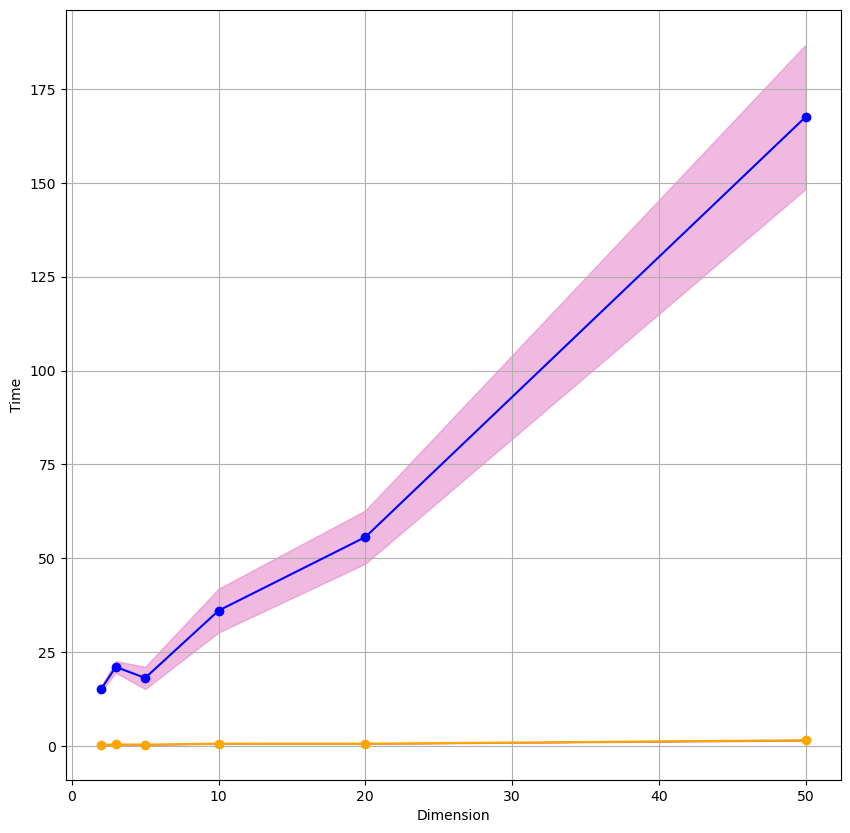

In [181]:
#Plotting time difference

rn_dims = jnp.array(dims)

rn_score_tmean = jnp.array([time.average for time in time_score])
rn_score_tstd = jnp.array([time.stdev for time in time_score])

rn_bridge_tmean = jnp.array([time.average for time in time_bridge])
rn_bridge_tstd = jnp.array([time.stdev for time in time_bridge])

print("The score diffusion compute time:")
for i in range(len(rn_score_tmean)):
    print(f"{rn_score_tmean[i]:.5f} \pm {rn_score_tstd[i]:.5f}")
print("The bridge diffusion compute time:")
for i in range(len(rn_score_tmean)):
    print(f"{rn_bridge_tmean[i]:.5f} \pm {rn_bridge_tstd[i]:.5f}")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rn_dims, rn_score_tmean, '-o',color='orange')
ax.plot(rn_dims, rn_bridge_tmean, '-o',color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time')
ax.fill_between(
    rn_dims,
    jnp.maximum(rn_score_tmean - 1.96 * rn_score_tstd, jnp.zeros_like(rn_score_tmean)),
    jnp.maximum(rn_score_tmean + 1.96 * rn_score_tstd, jnp.zeros_like(rn_score_tmean)),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    dims,
    jnp.maximum(rn_bridge_tmean - 1.96 * rn_bridge_tstd, jnp.zeros_like(rn_bridge_tmean)),
    jnp.maximum(rn_bridge_tmean + 1.96 * rn_bridge_tstd, jnp.zeros_like(rn_bridge_tmean)),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)



## Estimating Frechet Mean

### Error Estimate

In [175]:
dims = [2,3,5,10,20,50]
rn_score_frechet_error = []
T = 0.01

for N in dims:
    M = Euclidean(N=N)
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    Frechet_mean(M)
    x0 = (jnp.zeros(N), jnp.zeros(1))
    
    file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/R'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
        s2_val = ggrady_log(x,y,t)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

        return ggrad

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))

    diffusion_mean(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")
    mu_sm, gradx_sm = M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([T]), \
                                           step_size=0.01, max_iter=100)
    
    mufrechet,loss,iterations,vs = M.Frechet_mean(zip(X_obs[0], X_obs[1]),x0)
    
    rn_score_frechet_error.append(jnp.linalg.norm(mufrechet[0]-mu_sm[0][-1])/N)
    

using M.Exp for Logarithm
Step 0 | T: 0.000000e+00 | T: 1.441706e+01
Step 10 | T: 8.783063e-01 | T: 5.866452e+00
Step 20 | T: 1.237958e+00 | T: 1.049006e+00
Step 30 | T: 1.086591e+00 | T: 2.875869e-01
Step 40 | T: 9.710429e-01 | T: 2.403771e-01
Step 50 | T: 9.648421e-01 | T: 8.902320e-02
Step 60 | T: 9.988828e-01 | T: 1.012582e-01
Step 70 | T: 9.888478e-01 | T: 4.759527e-02
Step 80 | T: 9.666764e-01 | T: 5.144543e-02
Step 90 | T: 9.905755e-01 | T: 2.749886e-02
Step 100 | T: 9.793591e-01 | T: 3.034479e-02
Step 110 | T: 9.804666e-01 | T: 1.827945e-02
Step 120 | T: 9.679438e-01 | T: 1.687225e-02
Step 130 | T: 9.735911e-01 | T: 1.258720e-02
Step 140 | T: 9.737440e-01 | T: 8.199047e-03
Step 150 | T: 9.728827e-01 | T: 8.137047e-03
Step 160 | T: 9.703205e-01 | T: 4.205616e-03
Step 170 | T: 9.689420e-01 | T: 4.212169e-03
Step 180 | T: 9.706668e-01 | T: 1.954067e-03
Step 190 | T: 9.708456e-01 | T: 1.827400e-03
Step 199 | T: 9.704811e-01 | T: 1.432131e-03 
using M.Exp for Logarithm
Step 0 | T: 0

The score diffusion frechet error:
0.24968
0.11896
0.13128
0.08129
0.05959
0.03536


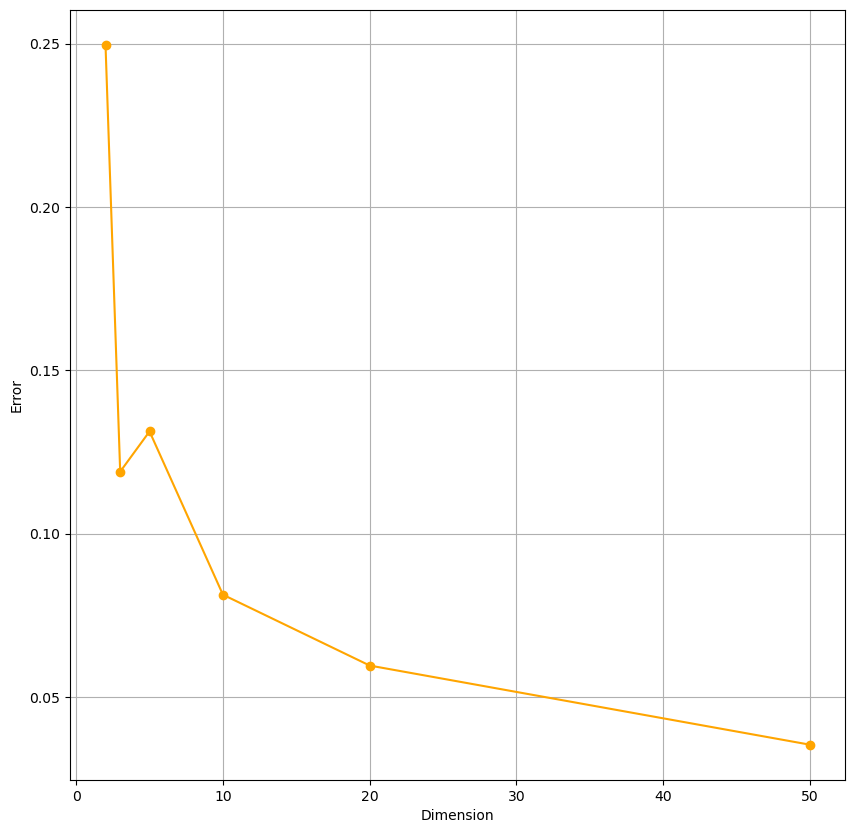

In [177]:
#Plotting time difference

rn_dims = jnp.array(dims)

rn_score_frechet_error = jnp.array(rn_score_frechet_error)

print("The score diffusion frechet error:")
for i in range(len(rn_score_frechet_error)):
    print(f"{rn_score_frechet_error[i]:.5f}")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rn_dims, rn_score_frechet_error, '-o',color='orange')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Error')
ax.grid(True)


### Time Estimate

In [178]:
dims = [2,3,5,10,20,50]
rn_score_frechet_time = []
rn_grad_frechet_time = []
T = 0.01

for N in dims:
    M = Euclidean(N=N)
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    Frechet_mean(M)
    x0 = (jnp.zeros(N), jnp.zeros(1))
    
    file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/R'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
        s2_val = ggrady_log(x,y,t)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

        return ggrad

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))

    diffusion_mean(M, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")
    result = %timeit -o M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([T]), \
                                           step_size=0.01, max_iter=100)
    rn_score_frechet_time.append(result)
    
    result = %timeit -o M.Frechet_mean(zip(X_obs[0], X_obs[1]),x0)
    rn_grad_frechet_time.append(result)

using M.Exp for Logarithm
113 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Step 0 | T: 0.000000e+00 | T: 1.441706e+01
Step 10 | T: 8.783063e-01 | T: 5.866452e+00
Step 20 | T: 1.237958e+00 | T: 1.049006e+00
Step 30 | T: 1.086591e+00 | T: 2.875869e-01
Step 40 | T: 9.710429e-01 | T: 2.403771e-01
Step 50 | T: 9.648421e-01 | T: 8.902320e-02
Step 60 | T: 9.988828e-01 | T: 1.012582e-01
Step 70 | T: 9.888478e-01 | T: 4.759527e-02
Step 80 | T: 9.666764e-01 | T: 5.144543e-02
Step 90 | T: 9.905755e-01 | T: 2.749886e-02
Step 100 | T: 9.793591e-01 | T: 3.034479e-02
Step 110 | T: 9.804666e-01 | T: 1.827945e-02
Step 120 | T: 9.679438e-01 | T: 1.687225e-02
Step 130 | T: 9.735911e-01 | T: 1.258720e-02
Step 140 | T: 9.737440e-01 | T: 8.199047e-03
Step 150 | T: 9.728827e-01 | T: 8.137047e-03
Step 160 | T: 9.703205e-01 | T: 4.205616e-03
Step 170 | T: 9.689420e-01 | T: 4.212169e-03
Step 180 | T: 9.706668e-01 | T: 1.954067e-03
Step 190 | T: 9.708456e-01 | T: 1.827400e-03
Step 199 | T: 9

Step 150 | T: 1.543360e+00 | T: 1.477575e-02
Step 160 | T: 1.547260e+00 | T: 1.414187e-02
Step 170 | T: 1.549044e+00 | T: 8.761883e-03
Step 180 | T: 1.547513e+00 | T: 6.483817e-03
Step 190 | T: 1.544079e+00 | T: 4.398781e-03
Step 199 | T: 1.544036e+00 | T: 2.654587e-03 
Step 0 | T: 0.000000e+00 | T: 2.576492e+01
Step 10 | T: 1.347146e+00 | T: 8.758061e+00
Step 20 | T: 1.968939e+00 | T: 2.760988e+00
Step 30 | T: 1.732900e+00 | T: 5.884030e-01
Step 40 | T: 1.562124e+00 | T: 4.019210e-01
Step 50 | T: 1.552685e+00 | T: 2.610998e-01
Step 60 | T: 1.560663e+00 | T: 1.976317e-01
Step 70 | T: 1.566595e+00 | T: 1.129348e-01
Step 80 | T: 1.569874e+00 | T: 1.193321e-01
Step 90 | T: 1.579190e+00 | T: 7.309930e-02
Step 100 | T: 1.551669e+00 | T: 7.888246e-02
Step 110 | T: 1.552753e+00 | T: 3.725193e-02
Step 120 | T: 1.553783e+00 | T: 4.422773e-02
Step 130 | T: 1.558614e+00 | T: 2.417435e-02
Step 140 | T: 1.550077e+00 | T: 2.688207e-02
Step 150 | T: 1.543360e+00 | T: 1.477575e-02
Step 160 | T: 1.5472

Step 180 | T: 2.512515e+00 | T: 1.527073e-02
Step 190 | T: 2.515456e+00 | T: 6.987067e-03
Step 199 | T: 2.515391e+00 | T: 7.501429e-03 
Step 0 | T: 0.000000e+00 | T: 6.114460e+01
Step 10 | T: 2.245684e+00 | T: 2.183126e+01
Step 20 | T: 3.241586e+00 | T: 7.136747e+00
Step 30 | T: 2.844831e+00 | T: 1.362506e+00
Step 40 | T: 2.519737e+00 | T: 8.983672e-01
Step 50 | T: 2.483498e+00 | T: 4.394127e-01
Step 60 | T: 2.565299e+00 | T: 3.753835e-01
Step 70 | T: 2.567822e+00 | T: 2.290439e-01
Step 80 | T: 2.541361e+00 | T: 1.868458e-01
Step 90 | T: 2.543293e+00 | T: 1.517273e-01
Step 100 | T: 2.536878e+00 | T: 1.183980e-01
Step 110 | T: 2.537683e+00 | T: 8.212416e-02
Step 120 | T: 2.528153e+00 | T: 7.691342e-02
Step 130 | T: 2.515903e+00 | T: 5.715868e-02
Step 140 | T: 2.520331e+00 | T: 5.319374e-02
Step 150 | T: 2.521282e+00 | T: 3.239695e-02
Step 160 | T: 2.518248e+00 | T: 3.076804e-02
Step 170 | T: 2.512928e+00 | T: 1.634388e-02
Step 180 | T: 2.512515e+00 | T: 1.527073e-02
Step 190 | T: 2.5154

Step 160 | T: 5.149267e+00 | T: 5.829394e-02
Step 170 | T: 5.149682e+00 | T: 4.935365e-02
Step 180 | T: 5.154837e+00 | T: 2.932854e-02
Step 190 | T: 5.152236e+00 | T: 2.367263e-02
Step 199 | T: 5.149276e+00 | T: 1.922562e-02 
Step 0 | T: 0.000000e+00 | T: 1.424336e+02
Step 10 | T: 4.479343e+00 | T: 4.168643e+01
Step 20 | T: 6.520981e+00 | T: 1.089582e+01
Step 30 | T: 5.827559e+00 | T: 3.226791e+00
Step 40 | T: 5.173358e+00 | T: 2.608706e+00
Step 50 | T: 5.144290e+00 | T: 1.132871e+00
Step 60 | T: 5.288039e+00 | T: 9.838946e-01
Step 70 | T: 5.204485e+00 | T: 6.754260e-01
Step 80 | T: 5.174974e+00 | T: 5.291795e-01
Step 90 | T: 5.243334e+00 | T: 4.430125e-01
Step 100 | T: 5.211963e+00 | T: 3.510033e-01
Step 110 | T: 5.178980e+00 | T: 2.502196e-01
Step 120 | T: 5.157988e+00 | T: 2.238096e-01
Step 130 | T: 5.169717e+00 | T: 1.280960e-01
Step 140 | T: 5.173322e+00 | T: 1.216361e-01
Step 150 | T: 5.159413e+00 | T: 8.757065e-02
Step 160 | T: 5.149267e+00 | T: 5.829394e-02
Step 170 | T: 5.1496

Step 140 | T: 1.005115e+01 | T: 2.709063e-01
Step 150 | T: 1.002577e+01 | T: 2.125773e-01
Step 160 | T: 1.002346e+01 | T: 1.480759e-01
Step 170 | T: 1.002455e+01 | T: 9.830578e-02
Step 180 | T: 1.002459e+01 | T: 7.330701e-02
Step 190 | T: 1.001744e+01 | T: 4.295430e-02
Step 199 | T: 1.001455e+01 | T: 3.578348e-02 
Step 0 | T: 0.000000e+00 | T: 4.364434e+02
Step 10 | T: 8.848406e+00 | T: 1.177507e+02
Step 20 | T: 1.269644e+01 | T: 5.000116e+01
Step 30 | T: 1.125799e+01 | T: 1.457987e+01
Step 40 | T: 1.010842e+01 | T: 6.199791e+00
Step 50 | T: 1.000686e+01 | T: 3.351354e+00
Step 60 | T: 1.024848e+01 | T: 2.990553e+00
Step 70 | T: 1.013146e+01 | T: 2.024435e+00
Step 80 | T: 1.011636e+01 | T: 1.470219e+00
Step 90 | T: 1.018513e+01 | T: 1.290155e+00
Step 100 | T: 1.010441e+01 | T: 9.373164e-01
Step 110 | T: 1.006908e+01 | T: 6.823754e-01
Step 120 | T: 1.005570e+01 | T: 5.125706e-01
Step 130 | T: 1.005933e+01 | T: 4.079744e-01
Step 140 | T: 1.005115e+01 | T: 2.709063e-01
Step 150 | T: 1.0025

Step 70 | T: 2.521897e+01 | T: 9.879374e+00
Step 80 | T: 2.502827e+01 | T: 7.168887e+00
Step 90 | T: 2.520834e+01 | T: 5.837609e+00
Step 100 | T: 2.507111e+01 | T: 4.601028e+00
Step 110 | T: 2.501217e+01 | T: 2.910069e+00
Step 120 | T: 2.489272e+01 | T: 2.589749e+00
Step 130 | T: 2.492672e+01 | T: 1.549213e+00
Step 140 | T: 2.491209e+01 | T: 1.410919e+00
Step 150 | T: 2.488444e+01 | T: 7.450535e-01
Step 160 | T: 2.484750e+01 | T: 7.036123e-01
Step 170 | T: 2.484101e+01 | T: 3.548934e-01
Step 180 | T: 2.484943e+01 | T: 3.075957e-01
Step 190 | T: 2.484456e+01 | T: 1.727803e-01
Step 199 | T: 2.483862e+01 | T: 1.555239e-01 
Step 0 | T: 0.000000e+00 | T: 2.137983e+03
Step 10 | T: 2.199317e+01 | T: 4.188426e+02
Step 20 | T: 3.167968e+01 | T: 1.415601e+02
Step 30 | T: 2.800653e+01 | T: 4.662005e+01
Step 40 | T: 2.500988e+01 | T: 2.578262e+01
Step 50 | T: 2.475183e+01 | T: 1.557704e+01
Step 60 | T: 2.536700e+01 | T: 1.200468e+01
Step 70 | T: 2.521897e+01 | T: 9.879374e+00
Step 80 | T: 2.502827

The score diffusion compute time:
0.11251 \pm 0.00209
0.11297 \pm 0.00161
0.10356 \pm 0.00044
0.16040 \pm 0.00083
0.16711 \pm 0.00460
0.29103 \pm 0.00480
The grad diffusion compute time:
0.39861 \pm 0.00869
0.40173 \pm 0.00323
0.40187 \pm 0.00489
0.41677 \pm 0.00987
0.42285 \pm 0.00544
0.83652 \pm 0.01213


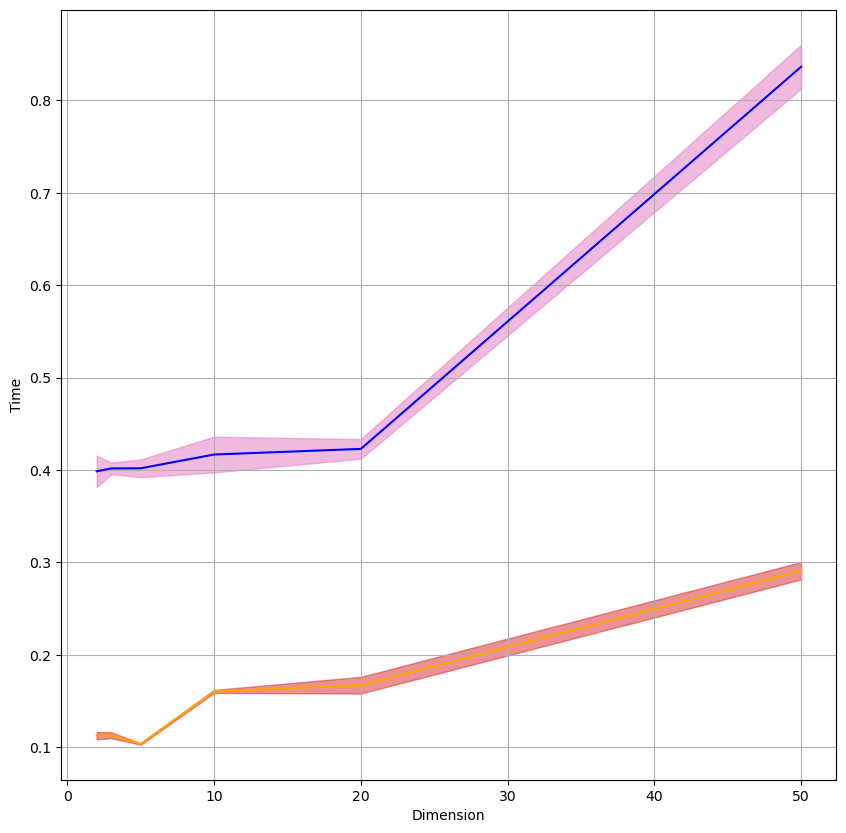

In [180]:
#Plotting time difference

rn_dims = jnp.array(dims)

rn_score_frechet_tmean = jnp.array([time.average for time in rn_score_frechet_time])
rn_score_frechet_tstd = jnp.array([time.stdev for time in rn_score_frechet_time])

rn_grad_frechet_tmean = jnp.array([time.average for time in rn_grad_frechet_time])
rn_grad_frechet_tstd = jnp.array([time.stdev for time in rn_grad_frechet_time])

print("The score diffusion compute time:")
for i in range(len(rn_score_frechet_tmean)):
    print(f"{rn_score_frechet_tmean[i]:.5f} \pm {rn_score_frechet_tstd[i]:.5f}")
print("The grad diffusion compute time:")
for i in range(len(rn_grad_frechet_tmean)):
    print(f"{rn_grad_frechet_tmean[i]:.5f} \pm {rn_grad_frechet_tstd[i]:.5f}")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rn_dims, rn_score_frechet_tmean, color='orange')
ax.plot(rn_dims, rn_grad_frechet_tmean, color='blue')
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time')
ax.fill_between(
    rn_dims,
    jnp.maximum(rn_score_frechet_tmean - 1.96 * rn_score_frechet_tstd, jnp.zeros_like(rn_score_frechet_tstd)),
    jnp.maximum(rn_score_frechet_tmean + 1.96 * rn_score_frechet_tstd, jnp.zeros_like(rn_score_frechet_tstd)),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    dims,
    jnp.maximum(rn_grad_frechet_tmean - 1.96 * rn_grad_frechet_tstd, jnp.zeros_like(rn_grad_frechet_tstd)),
    jnp.maximum(rn_grad_frechet_tmean + 1.96 * rn_grad_frechet_tstd, jnp.zeros_like(rn_grad_frechet_tstd)),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)



# Circle

## Defining Manifold and Loading Score

In [183]:
M = S1()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.])

using M.Exp for Logarithm


In [198]:
file_path = 'scores/S1/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/S1/s2/'
state_s2 = model_loader.load_model(file_path_s2)

layers = [50,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):

    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)

    return ggrad

def ggrady_log_score(x,y,t):

    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))

    return ggrad

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

FileNotFoundError: [Errno 2] No such file or directory: 'scores/S1/s2/tree.pkl'

## Loading Loss

In [185]:
loss = jnp.load('scores/S1/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


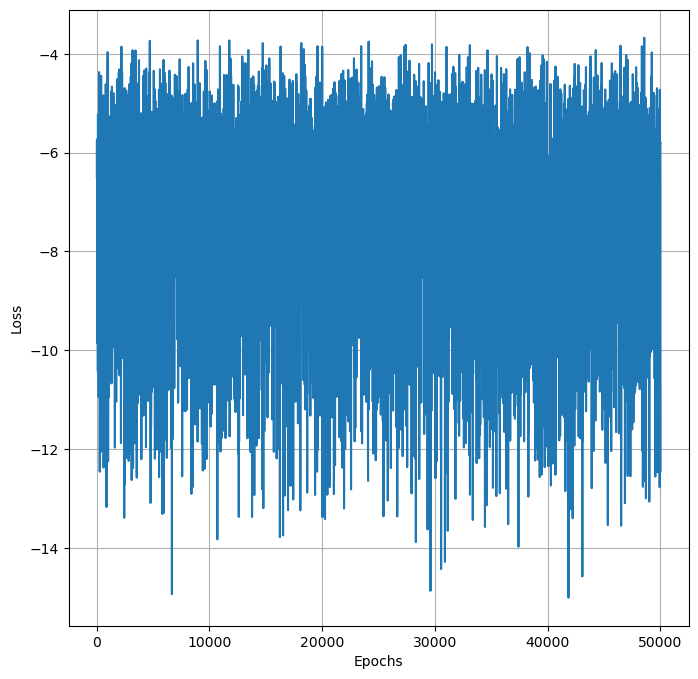

In [186]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [187]:
loss = jnp.load('scores/S1/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

FileNotFoundError: [Errno 2] No such file or directory: 'scores/S1/s2/loss_arrays.npy'

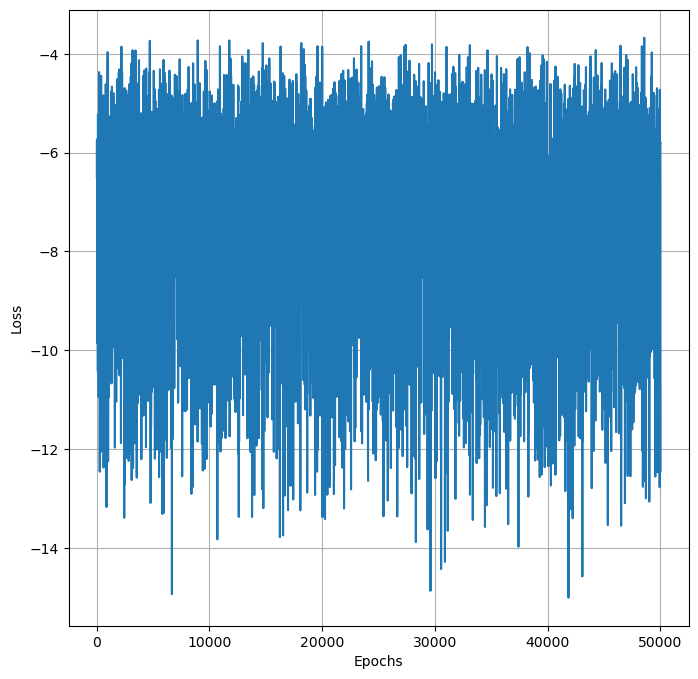

In [188]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [189]:
xs = pd.read_csv('Data/S1/xs.csv', header=None)
charts = pd.read_csv('Data/S1/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

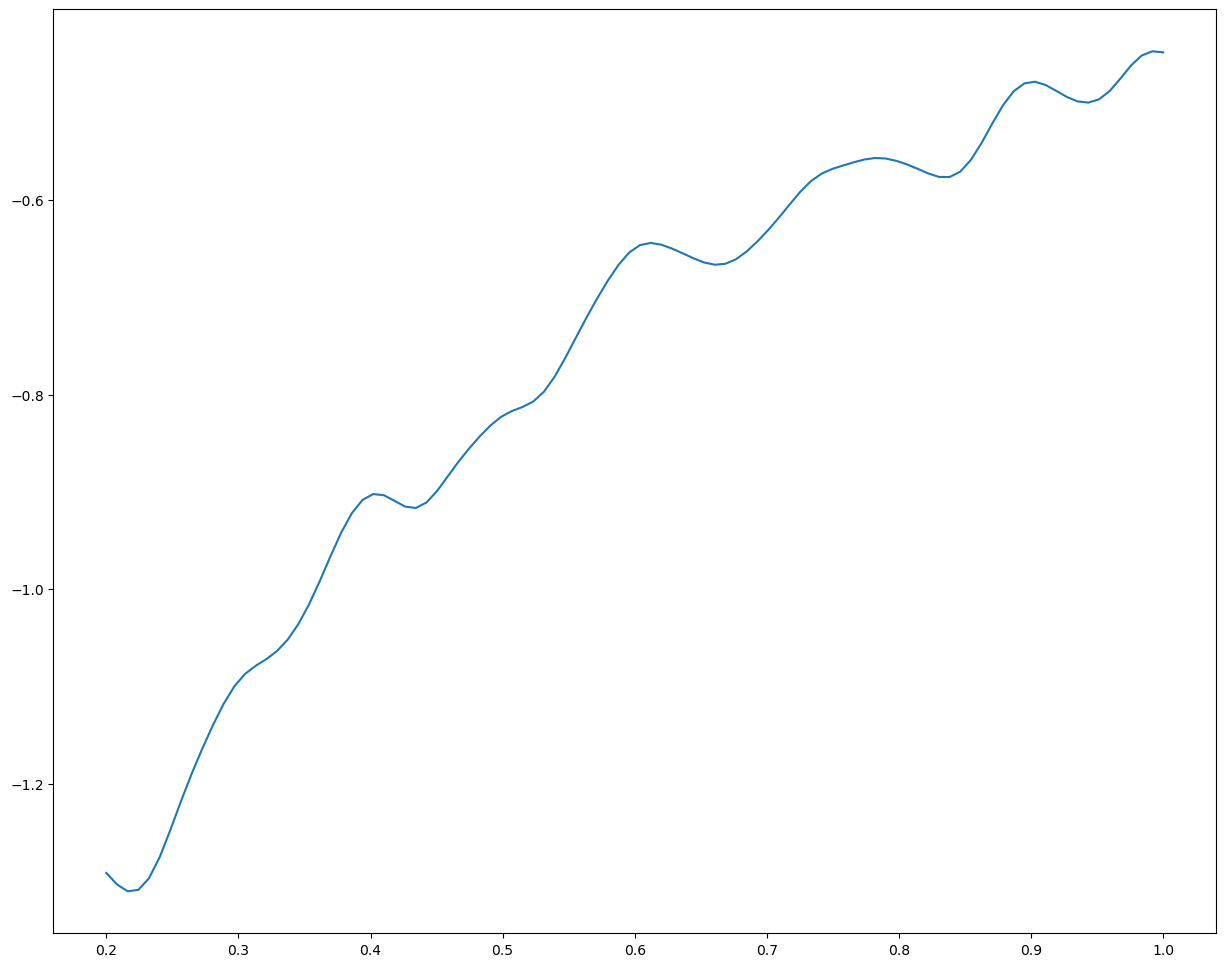

In [190]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [191]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[0][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=100)

In [192]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean((X_obs[0],X_obs[0]),num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean((X_obs[0],X_obs[0]),num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.923353e+02 | T: ((Array([0.03014468], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.764227e+02 | T: ((Array([0.04011173], dtype=float32), Array(0.21994194, dtype=float32)), Array([0.], dtype=float32))
Final 1 | T: 1.764227e+02 | T: (Array([0.04011173], dtype=float32), Array(0.21994194, dtype=float32))
Step 0 | T: 1.923353e+02 | T: ((Array([0.03014468], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.764227e+02 | T: ((Array([0.04011173], dtype=float32), Array(0.21994194, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 1.614058e+02 | T: ((Array([0.05002367], dtype=float32), Array(0.22978848, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 1.498936e+02 | T: ((Array([0.05986768], dtype=float32), Array(0.23951702, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 1.384526e+02 | T: ((Array([0.06962617], dtype=float32), Array(0.24909961, dtype=float32)), Array([0.

Step 63 | T: 3.429570e+01 | T: ((Array([0.46247542], dtype=float32), Array(0.54329985, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 3.403510e+01 | T: ((Array([0.46742195], dtype=float32), Array(0.5459572, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 3.371496e+01 | T: ((Array([0.4723503], dtype=float32), Array(0.54858994, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 3.340269e+01 | T: ((Array([0.47726047], dtype=float32), Array(0.55119854, dtype=float32)), Array([0.], dtype=float32))
Step 67 | T: 3.309794e+01 | T: ((Array([0.4821525], dtype=float32), Array(0.5537835, dtype=float32)), Array([0.], dtype=float32))
Step 68 | T: 3.280041e+01 | T: ((Array([0.48702642], dtype=float32), Array(0.5563452, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 3.257366e+01 | T: ((Array([0.49188307], dtype=float32), Array(0.5588847, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 3.228918e+01 | T: ((Array([0.4967225], dtype=float32), Array(0.561402

In [193]:
def gradt_log_opt(x,y,t):
    
    s1_val = M.grady_log_hk(x,y,t)
    s2_val = jacfwdx(lambda y: M.grady_log_hk(x,y,t))(y)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div).squeeze()

In [194]:
def gradt_log_opt(x,y,t):
    
    ggrad = jacfwdx(lambda y: M.grady_log_hk(x,y,t))(y)
    
    return ggrad.squeeze()

In [195]:
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t).squeeze(), s2_model = gradt_log_opt, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[0][0]), jnp.array([0.2]))

In [196]:
mu_opt = x0
T_opt = jnp.array([0.5]).reshape(1,1)

In [197]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0143 )
T = 0.0982


In [59]:
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1]):.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.5f}")

Score Diffusion mean: 
 -mean error = 0.01786 
 -T error = 0.40000


In [60]:
mu_bridge = M.F((mu_bridgex[-1], mu_bridgechart[-1]))

In [61]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridge), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.5124 )
T = 0.6345


In [63]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0000 )
T = 0.5000


In [64]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1]-mu_sm[1][-1]):.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1]-mu_bridgechart[-1]):.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.01786 
 -T error = 0.40000
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.13449


In [66]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[0][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

183 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

Step 0 | T: 1.852988e+01 | T: ((Array([-0.23001227], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.651170e+01 | T: ((Array([-0.22005376], dtype=float32), Array(0.21992284, dtype=float32)), Array([1., 0.], dtype=float32))
Step 2 | T: 1.479264e+01 | T: ((Array([-0.2101603], dtype=float32), Array(0.22972557, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.332320e+01 | T: ((Array([-0.20035248], dtype=float32), Array(0.23937148, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557

Step 61 | T: 1.765231e+00 | T: ((Array([0.15533094], dtype=float32), Array(0.4775787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 62 | T: 1.743972e+00 | T: ((Array([0.15936193], dtype=float32), Array(0.47891006, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.723262e+00 | T: ((Array([0.16336693], dtype=float32), Array(0.48021078, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.703075e+00 | T: ((Array([0.16734692], dtype=float32), Array(0.481482, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.683385e+00 | T: ((Array([0.17130281], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664172e+00 | T: ((Array([0.17523544], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.1791456], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.18303408], 

Step 21 | T: 4.075386e+00 | T: ((Array([-0.04890837], dtype=float32), Array(0.37125227, dtype=float32)), Array([1., 0.], dtype=float32))
Step 22 | T: 3.919297e+00 | T: ((Array([-0.04200172], dtype=float32), Array(0.3762729, dtype=float32)), Array([1., 0.], dtype=float32))
Step 23 | T: 3.775929e+00 | T: ((Array([-0.03523772], dtype=float32), Array(0.3810926, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 3.643910e+00 | T: ((Array([-0.02861202], dtype=float32), Array(0.3857195, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 3.522033e+00 | T: ((Array([-0.02212016], dtype=float32), Array(0.39016163, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409250e+00 | T: ((Array([-0.01575764], dtype=float32), Array(0.39442685, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304638e+00 | T: ((Array([-0.00951992], dtype=float32), Array(0.39852297, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207382e+00 | T: ((Array([-0.0

Step 82 | T: 1.407408e+00 | T: ((Array([0.23552549], dtype=float32), Array(0.50028527, dtype=float32)), Array([1., 0.], dtype=float32))
Step 83 | T: 1.393872e+00 | T: ((Array([0.23915423], dtype=float32), Array(0.5011429, dtype=float32)), Array([1., 0.], dtype=float32))
Step 84 | T: 1.380572e+00 | T: ((Array([0.2427688], dtype=float32), Array(0.501984, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.367503e+00 | T: ((Array([0.24636945], dtype=float32), Array(0.5028088, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.354655e+00 | T: ((Array([0.24995646], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353009], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.25709054], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.26063803], 

Step 42 | T: 2.330246e+00 | T: ((Array([0.07200319], dtype=float32), Array(0.44426972, dtype=float32)), Array([1., 0.], dtype=float32))
Step 43 | T: 2.289187e+00 | T: ((Array([0.07681054], dtype=float32), Array(0.44653004, dtype=float32)), Array([1., 0.], dtype=float32))
Step 44 | T: 2.249915e+00 | T: ((Array([0.08155822], dtype=float32), Array(0.44871762, dtype=float32)), Array([1., 0.], dtype=float32))
Step 45 | T: 2.212302e+00 | T: ((Array([0.08624896], dtype=float32), Array(0.45083603, dtype=float32)), Array([1., 0.], dtype=float32))
Step 46 | T: 2.176231e+00 | T: ((Array([0.09088535], dtype=float32), Array(0.45288864, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 2.141595e+00 | T: ((Array([0.09546988], dtype=float32), Array(0.45487866, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 2.108297e+00 | T: ((Array([0.1000049], dtype=float32), Array(0.4568091, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 2.076249e+00 | T: ((Array([0.10449263

Step 2 | T: 1.479264e+01 | T: ((Array([-0.2101603], dtype=float32), Array(0.22972557, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.332320e+01 | T: ((Array([-0.20035248], dtype=float32), Array(0.23937148, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557], dtype=float32), Array(0.27585956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 8 | T: 8.507276e+00 | T: ((Array([-0.15313306], dtype=float32), Array(0.28437072, dtype=float32)), Array([1., 0.], dtype=float32))
Step 9 | T: 7.883114e+00 | T: ((Array([-0.14412718

Step 63 | T: 1.723261e+00 | T: ((Array([0.16336696], dtype=float32), Array(0.48021078, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.703075e+00 | T: ((Array([0.16734695], dtype=float32), Array(0.481482, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.683385e+00 | T: ((Array([0.17130284], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664171e+00 | T: ((Array([0.17523547], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.17914563], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.1830341], dtype=float32), Array(0.48629236, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.609175e+00 | T: ((Array([0.18690158], dtype=float32), Array(0.48743093, dtype=float32)), Array([1., 0.], dtype=float32))
Step 70 | T: 1.591661e+00 | T: ((Array([0.19074874],

Step 23 | T: 3.775930e+00 | T: ((Array([-0.03523771], dtype=float32), Array(0.38109258, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 3.643910e+00 | T: ((Array([-0.02861201], dtype=float32), Array(0.38571948, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 3.522034e+00 | T: ((Array([-0.02212015], dtype=float32), Array(0.3901616, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409251e+00 | T: ((Array([-0.01575763], dtype=float32), Array(0.39442682, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304639e+00 | T: ((Array([-0.00951991], dtype=float32), Array(0.39852294, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207383e+00 | T: ((Array([-0.00340244], dtype=float32), Array(0.4024575, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 3.116768e+00 | T: ((Array([0.00259931], dtype=float32), Array(0.40623787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 3.032159e+00 | T: ((Array([0.00

Step 84 | T: 1.380572e+00 | T: ((Array([0.24276878], dtype=float32), Array(0.501984, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.367503e+00 | T: ((Array([0.24636944], dtype=float32), Array(0.5028088, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.354656e+00 | T: ((Array([0.24995644], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353006], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.2570905], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.260638], dtype=float32), Array(0.5059516, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.305366e+00 | T: ((Array([0.26417276], dtype=float32), Array(0.50669956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.293538e+00 | T: ((Array([0.26769498], dt

Step 44 | T: 2.249915e+00 | T: ((Array([0.08155822], dtype=float32), Array(0.44871762, dtype=float32)), Array([1., 0.], dtype=float32))
Step 45 | T: 2.212302e+00 | T: ((Array([0.08624896], dtype=float32), Array(0.45083603, dtype=float32)), Array([1., 0.], dtype=float32))
Step 46 | T: 2.176231e+00 | T: ((Array([0.09088535], dtype=float32), Array(0.45288864, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 2.141595e+00 | T: ((Array([0.09546988], dtype=float32), Array(0.45487866, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 2.108297e+00 | T: ((Array([0.1000049], dtype=float32), Array(0.4568091, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 2.076249e+00 | T: ((Array([0.10449263], dtype=float32), Array(0.4586828, dtype=float32)), Array([1., 0.], dtype=float32))
Step 50 | T: 2.045369e+00 | T: ((Array([0.10893523], dtype=float32), Array(0.46050248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 51 | T: 2.015582e+00 | T: ((Array([0.11333469]

Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557], dtype=float32), Array(0.27585956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 8 | T: 8.507276e+00 | T: ((Array([-0.15313306], dtype=float32), Array(0.28437072, dtype=float32)), Array([1., 0.], dtype=float32))
Step 9 | T: 7.883113e+00 | T: ((Array([-0.14412718], dtype=float32), Array(0.29261747, dtype=float32)), Array([1., 0.], dtype=float32))
Step 10 | T: 7.334003e+00 | T: ((Array([-0.13528283], dtype=float32), Array(0.3005955, dtype=float32)), Array([1., 0.], dtype=float32))
Step 11 | T: 6.848979e+00 | T: ((Array([-0.126603

Step 65 | T: 1.683385e+00 | T: ((Array([0.17130286], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664171e+00 | T: ((Array([0.17523548], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.17914565], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.18303412], dtype=float32), Array(0.48629236, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.609175e+00 | T: ((Array([0.1869016], dtype=float32), Array(0.48743093, dtype=float32)), Array([1., 0.], dtype=float32))
Step 70 | T: 1.591661e+00 | T: ((Array([0.19074875], dtype=float32), Array(0.48854554, dtype=float32)), Array([1., 0.], dtype=float32))
Step 71 | T: 1.574529e+00 | T: ((Array([0.19457622], dtype=float32), Array(0.48963696, dtype=float32)), Array([1., 0.], dtype=float32))
Step 72 | T: 1.557763e+00 | T: ((Array([0.19838458

Step 25 | T: 3.522034e+00 | T: ((Array([-0.02212015], dtype=float32), Array(0.3901616, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409251e+00 | T: ((Array([-0.01575763], dtype=float32), Array(0.39442682, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304639e+00 | T: ((Array([-0.00951991], dtype=float32), Array(0.39852294, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207383e+00 | T: ((Array([-0.00340244], dtype=float32), Array(0.4024575, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 3.116768e+00 | T: ((Array([0.00259931], dtype=float32), Array(0.40623787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 3.032159e+00 | T: ((Array([0.00848979], dtype=float32), Array(0.40987122, dtype=float32)), Array([1., 0.], dtype=float32))
Step 31 | T: 2.952994e+00 | T: ((Array([0.01427342], dtype=float32), Array(0.41336444, dtype=float32)), Array([1., 0.], dtype=float32))
Step 32 | T: 2.878774e+00 | T: ((Array([0.0199

Step 86 | T: 1.354656e+00 | T: ((Array([0.24995644], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353006], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.2570905], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.260638], dtype=float32), Array(0.5059516, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.305366e+00 | T: ((Array([0.26417276], dtype=float32), Array(0.50669956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.293538e+00 | T: ((Array([0.26769498], dtype=float32), Array(0.507433, dtype=float32)), Array([1., 0.], dtype=float32))
Step 92 | T: 1.281898e+00 | T: ((Array([0.27120483], dtype=float32), Array(0.5081521, dtype=float32)), Array([1., 0.], dtype=float32))
Step 93 | T: 1.270439e+00 | T: ((Array([0.27470252], dt

# n-Sphere

## Defining Manifold and Loading Score

In [119]:
N = 2 #Change this for S2, S3, S5, S10, S20
s2_approximation = True

In [120]:
M = nSphere(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [121]:
file_path = 'scores/S'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/S'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score2(x,y,t):
    
    grad = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return hess_TM(M, M.F(y), grad, ggrad)

def ggrady_log_score(x,y,t):
    
    Fx = M.F(x)
    Fy = M.F(y)
    
    grad = M.proj(Fx, s1.apply(state.params,rng_key, jnp.hstack((Fx, Fy, t))))
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((Fx,Fy,t)))
    
    val1 = M.proj(Fx, ggrad)
    val2 = grad-M.proj(Fx, grad)
    val3 = jacfwd(lambda x: M.proj(x, val2))(Fx)
        
    return hess_TM(M,Fx,grad,ggrad) #val1+val3

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

In [122]:
def invF(x):
    
    x0 = x[0]
    
    val = vmap(lambda xi: xi/(1+x0))(x[1:])

    return val

from jax import jacfwd
invJF = lambda x: jacfwd(invF)(x)

In [123]:
def hess_TM(M, Fx, v, h):
    x = get_coords(M, Fx)

    val1 = jacfwdx(lambda x: M.invJF((x[1],M.F(x))))(x)
    val2 = M.invJF((M.F(x), M.F(x)))
    val3 = M.JF(x)
    
    term1 = jnp.einsum('ijk,j->ik', val1, v)
    term2 = val2.dot(h).dot(val3)
    
    return term1+term2
    

In [124]:
s2.apply(state_s2.params, rng_key, jnp.hstack((x0[1],x0[1],0.5)))

Array([[-0.88343954,  0.        ,  0.        ],
       [ 0.        , -3.8987532 ,  0.        ],
       [ 0.        ,  0.        ,  2.3286252 ]], dtype=float32)

In [125]:
M.proj(x0[1], s2.apply(state_s2.params, rng_key, jnp.hstack((x0[1],x0[1],0.5))))

Array([[-0.88343954,  0.        ,  0.        ],
       [ 0.        , -3.8987532 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [110]:
grad = s1.apply(state.params, rng_key, jnp.hstack((x0[1],x0[1],0.5)))
jacfwd(lambda x: M.proj(x, grad-M.proj(x0[1], grad)))(x0[1])

Array([[-0.093422,  0.      ,  0.      ],
       [ 0.      , -0.093422,  0.      ],
       [ 0.      ,  0.      , -0.186844]], dtype=float32)

In [111]:
ggrady_log(x0,x0,0.5)

Array([[-0.15615785,  0.        ],
       [ 0.        , -3.6824226 ]], dtype=float32)

In [112]:
ggrady_log_ad(x0,x0,0.5)

Array([[-2.0492196 , -0.00339369],
       [-0.00624015, -2.056141  ]], dtype=float32)

## Loading Loss

In [113]:
loss = jnp.load('scores/S'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


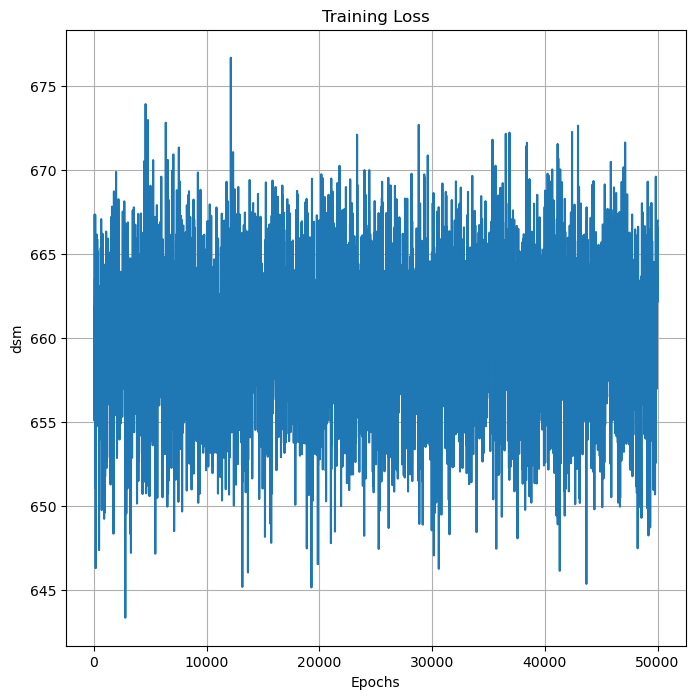

In [114]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

In [115]:
loss = jnp.load('scores/S'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  4130


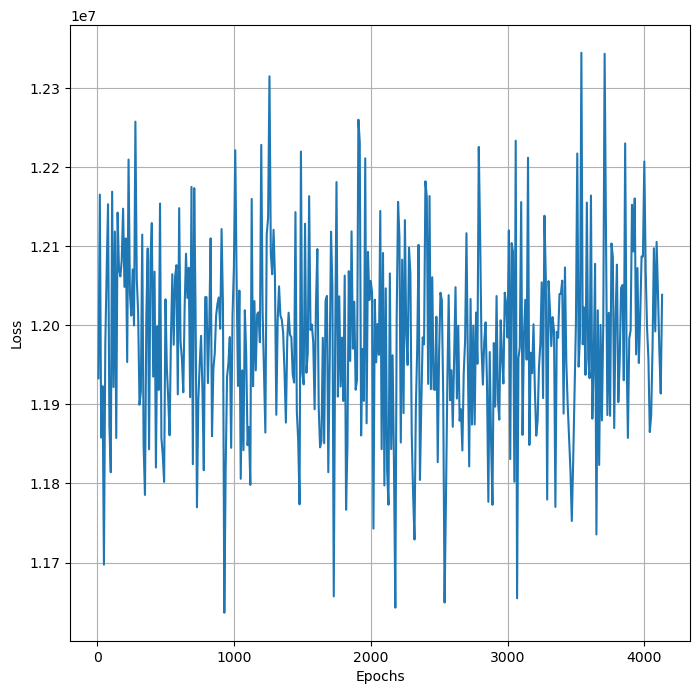

In [116]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [117]:
xs = pd.read_csv('Data/S'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/S'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

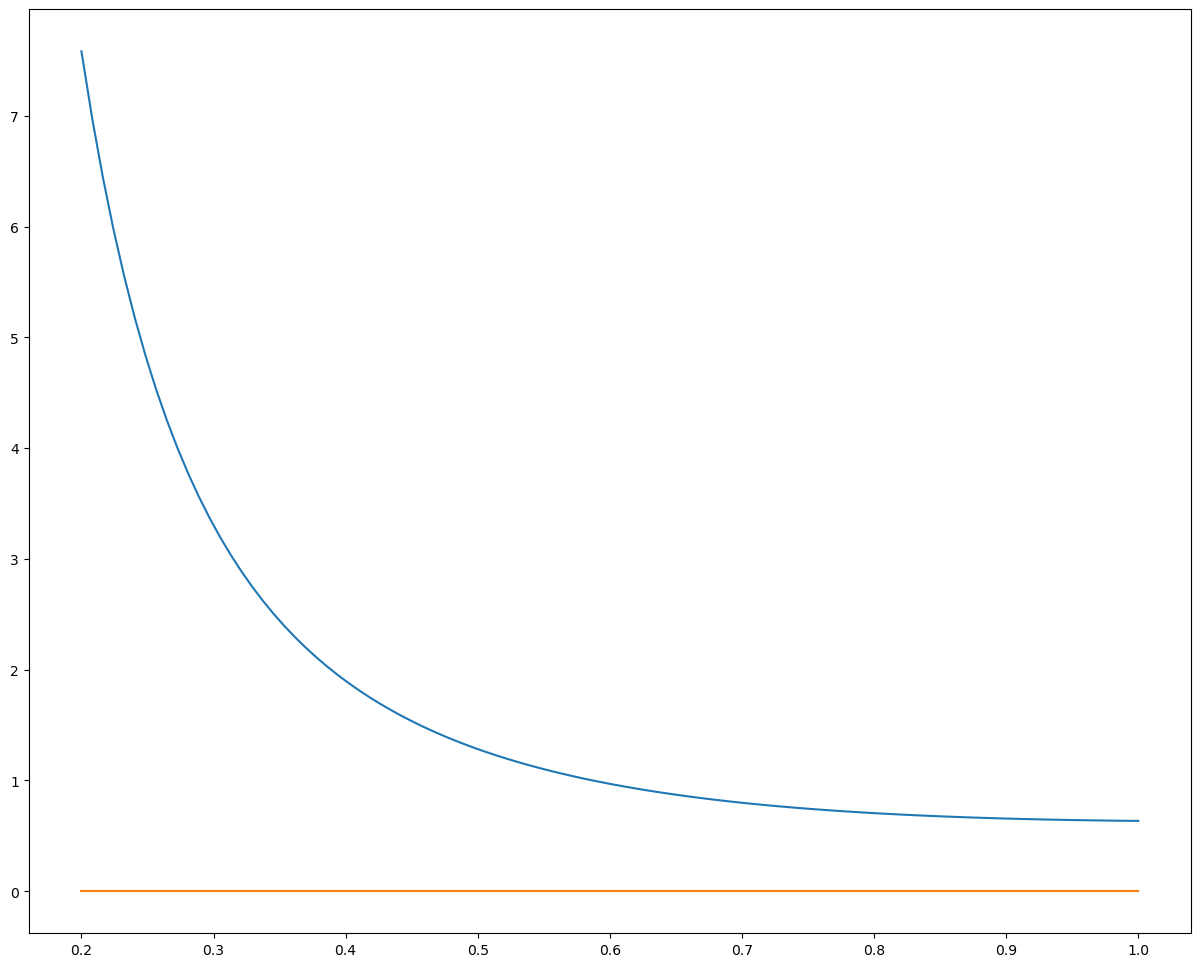

In [118]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)
plt.plot(jnp.linspace(0.2,1,100), val*0)

In [85]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [86]:
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=1000)

In [83]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 8.976685e+00 | T: ((Array([-0.02520598, -0.00380903], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.923673e+00 | T: ((Array([-0.01540402,  0.00585367], dtype=float32), Array(0.21992537, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Final 1 | T: 7.923673e+00 | T: (Array([-0.01540402,  0.00585367], dtype=float32), Array(0.21992537, dtype=float32))
Step 0 | T: 8.977785e+00 | T: ((Array([-0.02520598, -0.00380903], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.921535e+00 | T: ((Array([-0.01540381,  0.00585261], dtype=float32), Array(0.21992518, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 7.041299e+00 | T: ((Array([-0.00596572,  0.01482596], dtype=float32), Array(0.22973523, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 6.302914e+00 | T: ((Array([0.00291946, 0.02270061], dtype=float32), Array(0.23939635, dtype=float32)), Arra

Step 52 | T: 1.015457e+00 | T: ((Array([0.01562257, 0.01684638], dtype=float32), Array(0.47659957, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 53 | T: 1.006200e+00 | T: ((Array([0.01587409, 0.01635323], dtype=float32), Array(0.47862488, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 54 | T: 9.968107e-01 | T: ((Array([0.01604982, 0.01591403], dtype=float32), Array(0.48060745, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: 9.889687e-01 | T: ((Array([0.01614955, 0.01553664], dtype=float32), Array(0.48254937, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: 9.807022e-01 | T: ((Array([0.01617895, 0.01522653], dtype=float32), Array(0.48445246, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: 9.730220e-01 | T: ((Array([0.01614438, 0.01498457], dtype=float32), Array(0.4863186, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: 9.655988e-01 | T: ((Array([0.01605329, 0.01481055], dtype=float32), Array(0.

In [493]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]))

In [549]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0198 0.0127 0.9993 )
T = 0.4868


In [307]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgechart' is not defined

In [98]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0567 0.0145 0.1066 0.0924 -0.0552 -0.0367 0.0101 -0.0443 0.0050 -0.0209 0.9848 )
T = 0.5000


In [99]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.4588 
 -T error = 0.0317


In [308]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.01517 
 -T error = 0.0414


NameError: name 'mu_bridgechart' is not defined

## Timing Score

In [103]:
dims = [2,3,5,10]
time_score = []
time_bridge = []

for N in dims:
    print(N)
    M = nSphere(N=N)
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    x0 = M.coords([0.]*N)

    file_path = 'scores/S'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/S'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.emb_dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
        s2_val = ggrady_log(x,y,t)
        s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))

        return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/S'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/S'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))
    
    diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
    result = %timeit -o M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), \
                                           step_size=0.01, max_iter=100)
    time_score.append(result)
    result = %timeit -o M.diffusion_mean(X_obs,num_steps=100, N=1)
    time_bridge.append(result)

2
using M.Exp for Logarithm
914 ms ± 9.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Step 0 | T: 9.045785e+00 | T: ((Array([ 0.01163083, -0.0434425 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.991252e+00 | T: ((Array([ 0.01245216, -0.03357188], dtype=float32), Array(0.21992584, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 7.101362e+00 | T: ((Array([ 0.0160122 , -0.02392925], dtype=float32), Array(0.22973661, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 6.349108e+00 | T: ((Array([ 0.01915262, -0.01461921], dtype=float32), Array(0.2393977, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 4 | T: 5.710273e+00 | T: ((Array([ 0.02020616, -0.00574349], dtype=float32), Array(0.2488805, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166684e+00 | T: ((Array([0.01926227, 0.00260007], dtype=float32), Array(0.25816208, dtype=float32)), Array([0., 0., 1.], dtype=

Step 64 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 66 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 67 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 68 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 69 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 70 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: nan | T: ((

Step 25 | T: 1.628686e+00 | T: ((Array([0.01294184, 0.03626966], dtype=float32), Array(0.3937581, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578584e+00 | T: ((Array([0.01356781, 0.03414906], dtype=float32), Array(0.3983018, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.532483e+00 | T: ((Array([0.01421534, 0.03199829], dtype=float32), Array(0.40268132, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490357e+00 | T: ((Array([0.01475554, 0.02984851], dtype=float32), Array(0.40690377, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.450842e+00 | T: ((Array([0.0151051 , 0.02772752], dtype=float32), Array(0.41097602, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415187e+00 | T: ((Array([0.01520836, 0.02566148], dtype=float32), Array(0.41490492, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382138e+00 | T: ((Array([0.01506971, 0.02367251], dtype=float32), Array(0.4

Step 80 | T: 8.526035e-01 | T: ((Array([0.01261372, 0.01755135], dtype=float32), Array(0.52148575, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.493322e-01 | T: ((Array([0.01260655, 0.01741161], dtype=float32), Array(0.5227987, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.456793e-01 | T: ((Array([0.01259632, 0.0172654 ], dtype=float32), Array(0.524097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.416598e-01 | T: ((Array([0.0125951 , 0.01711522], dtype=float32), Array(0.52538097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386741e-01 | T: ((Array([0.01258443, 0.0169617 ], dtype=float32), Array(0.5266509, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.350921e-01 | T: ((Array([0.01258632, 0.01680811], dtype=float32), Array(0.52790713, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323963e-01 | T: ((Array([0.01258634, 0.01665593], dtype=float32), Array(0.529

Step 38 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 39 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 40 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 41 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 42 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 43 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 44 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 45 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 46 | T: nan | T: ((

Step 4 | T: 5.711473e+00 | T: ((Array([ 0.02016209, -0.00573971], dtype=float32), Array(0.24888098, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166816e+00 | T: ((Array([0.01922329, 0.0026055 ], dtype=float32), Array(0.2581626, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 6 | T: 4.701509e+00 | T: ((Array([0.01714822, 0.01033262], dtype=float32), Array(0.26722497, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 7 | T: 4.300499e+00 | T: ((Array([0.01478965, 0.01736988], dtype=float32), Array(0.2760544, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 8 | T: 3.955084e+00 | T: ((Array([0.01288747, 0.02366466], dtype=float32), Array(0.28464112, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 9 | T: 3.655872e+00 | T: ((Array([0.01190002, 0.02918439], dtype=float32), Array(0.29297855, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 10 | T: 3.393794e+00 | T: ((Array([0.0119092 , 0.03391863], dtype=float32), Array(0.30106

Step 59 | T: 9.597480e-01 | T: ((Array([0.01335757, 0.01459817], dtype=float32), Array(0.48954654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: 9.532180e-01 | T: ((Array([0.01332889, 0.01506102], dtype=float32), Array(0.49131104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 61 | T: 9.462790e-01 | T: ((Array([0.01324594, 0.01549778], dtype=float32), Array(0.49304473, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: 9.399000e-01 | T: ((Array([0.01313908, 0.01590524], dtype=float32), Array(0.49474895, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 63 | T: 9.334344e-01 | T: ((Array([0.01302965, 0.01628076], dtype=float32), Array(0.49642488, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 64 | T: 9.274523e-01 | T: ((Array([0.01291892, 0.01662284], dtype=float32), Array(0.4980737, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: 9.219731e-01 | T: ((Array([0.01283034, 0.01692861], dtype=float32), Array(0.

Step 16 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 22 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 23 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 24 | T: nan | T: ((

Step 84 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 87 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 88 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 89 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 90 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 91 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 92 | T: nan | T: ((

Step 51 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 52 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 53 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 54 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 59 | T: nan | T: ((

Step 15 | T: 2.483171e+00 | T: ((Array([0.01686817, 0.04654293], dtype=float32), Array(0.33768317, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 16 | T: 2.354946e+00 | T: ((Array([0.01693961, 0.0471529 ], dtype=float32), Array(0.34426856, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: 2.239385e+00 | T: ((Array([0.01649255, 0.04725169], dtype=float32), Array(0.35061872, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: 2.135923e+00 | T: ((Array([0.01567659, 0.04689742], dtype=float32), Array(0.35673988, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: 2.041491e+00 | T: ((Array([0.01466813, 0.04614703], dtype=float32), Array(0.3626386, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: 1.956218e+00 | T: ((Array([0.01367999, 0.04505685], dtype=float32), Array(0.36832184, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: 1.877450e+00 | T: ((Array([0.01287332, 0.04367841], dtype=float32), Array(0.

Step 70 | T: 8.955953e-01 | T: ((Array([0.01285   , 0.01794191], dtype=float32), Array(0.50745, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: 8.904602e-01 | T: ((Array([0.01288277, 0.01802357], dtype=float32), Array(0.50893635, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: 8.860428e-01 | T: ((Array([0.01291974, 0.01807266], dtype=float32), Array(0.5104028, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 73 | T: 8.811446e-01 | T: ((Array([0.01293461, 0.01808997], dtype=float32), Array(0.51184994, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 74 | T: 8.766546e-01 | T: ((Array([0.0129155 , 0.01807828], dtype=float32), Array(0.5132784, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 75 | T: 8.727586e-01 | T: ((Array([0.01287149, 0.01804045], dtype=float32), Array(0.5146889, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 76 | T: 8.682425e-01 | T: ((Array([0.0128057, 0.0179783], dtype=float32), Array(0.5160819

Step 25 | T: 1.628514e+00 | T: ((Array([0.013002 , 0.0362714], dtype=float32), Array(0.3937595, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578343e+00 | T: ((Array([0.0136104 , 0.03415186], dtype=float32), Array(0.39830318, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.531988e+00 | T: ((Array([0.01422564, 0.03200113], dtype=float32), Array(0.40268257, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490155e+00 | T: ((Array([0.01473398, 0.02985139], dtype=float32), Array(0.4069049, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.451111e+00 | T: ((Array([0.01504014, 0.02773125], dtype=float32), Array(0.4109771, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415330e+00 | T: ((Array([0.01511728, 0.02566602], dtype=float32), Array(0.414906, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382319e+00 | T: ((Array([0.01497632, 0.02367731], dtype=float32), Array(0.418698

Step 80 | T: 8.528425e-01 | T: ((Array([0.01258389, 0.01757165], dtype=float32), Array(0.52148867, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.492763e-01 | T: ((Array([0.01256143, 0.01743128], dtype=float32), Array(0.52280164, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.455395e-01 | T: ((Array([0.01255391, 0.01728428], dtype=float32), Array(0.52409995, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.422064e-01 | T: ((Array([0.0125618 , 0.01713132], dtype=float32), Array(0.52538395, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386081e-01 | T: ((Array([0.01258198, 0.01697478], dtype=float32), Array(0.526654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.354800e-01 | T: ((Array([0.0126243 , 0.01681809], dtype=float32), Array(0.5279104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323006e-01 | T: ((Array([0.01266598, 0.01666282], dtype=float32), Array(0.52

Step 24 | T: 2.180932e+00 | T: ((Array([-0.07632288,  0.01397538,  0.03365638], dtype=float32), Array(0.38671273, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 25 | T: 2.110601e+00 | T: ((Array([-0.07807811,  0.01305317,  0.03199854], dtype=float32), Array(0.39128554, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 26 | T: 2.046082e+00 | T: ((Array([-0.07953563,  0.01205928,  0.03016413], dtype=float32), Array(0.3956882, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 27 | T: 1.986766e+00 | T: ((Array([-0.08071133,  0.01104077,  0.02818881], dtype=float32), Array(0.39992818, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 28 | T: 1.932590e+00 | T: ((Array([-0.08162117,  0.0100344 ,  0.02610647], dtype=float32), Array(0.40401283, dtype=float32)), Array([-0.03674259,  0.18040879,  0.003065

Step 64 | T: 1.195142e+00 | T: ((Array([-0.05150324,  0.00725415, -0.00202238], dtype=float32), Array(0.4912967, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 65 | T: 1.187531e+00 | T: ((Array([-0.05086002,  0.00718176, -0.00153639], dtype=float32), Array(0.49283504, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 66 | T: 1.179862e+00 | T: ((Array([-0.05026503,  0.00714597, -0.00105861], dtype=float32), Array(0.49434927, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 67 | T: 1.173751e+00 | T: ((Array([-0.04971831,  0.00713644, -0.000595  ], dtype=float32), Array(0.49584037, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 68 | T: 1.166327e+00 | T: ((Array([-0.04921651,  0.00715526, -0.00014741], dtype=float32), Array(0.4973092, dtype=float32)), Array([-0.03674259,  0.18040879,  0.0030658

Step 4 | T: 7.920360e+00 | T: ((Array([-0.03754917, -0.02907104,  0.03917426], dtype=float32), Array(0.24882035, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114683e+00 | T: ((Array([-0.04628538, -0.03226851,  0.04847256], dtype=float32), Array(0.2580634, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428734e+00 | T: ((Array([-0.0546921 , -0.03381805,  0.0573892 ], dtype=float32), Array(0.26707602, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843668e+00 | T: ((Array([-0.06273833, -0.03397847,  0.06585204], dtype=float32), Array(0.2758443, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341877e+00 | T: ((Array([ 9.5814601e-10,  1.0832047e-10, -1.8833879e-09], dtype=float32), Array(0.28435847, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899

Step 44 | T: 1.430257e+00 | T: ((Array([-0.07306666,  0.0079308 , -0.0026878 ], dtype=float32), Array(0.45334113, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 45 | T: 1.413023e+00 | T: ((Array([-0.07180492,  0.00830906, -0.00354675], dtype=float32), Array(0.45568585, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 46 | T: 1.395797e+00 | T: ((Array([-0.07052713,  0.00864812, -0.00427345], dtype=float32), Array(0.45796838, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 47 | T: 1.379908e+00 | T: ((Array([-0.06924219,  0.00893948, -0.00487144], dtype=float32), Array(0.46019188, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 48 | T: 1.365347e+00 | T: ((Array([-0.06795681,  0.00917245, -0.00534546], dtype=float32), Array(0.46235937, dtype=float32)), Array([-0.03673254,  0.18041973,  0.00300

Step 84 | T: 1.083288e+00 | T: ((Array([-0.0458579 ,  0.00777991,  0.00319078], dtype=float32), Array(0.5183311, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 85 | T: 1.078878e+00 | T: ((Array([-0.04584624,  0.00773207,  0.00317659], dtype=float32), Array(0.5195156, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 86 | T: 1.074768e+00 | T: ((Array([-0.04584648,  0.00767833,  0.00314449], dtype=float32), Array(0.5206871, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 87 | T: 1.070988e+00 | T: ((Array([-0.0458559 ,  0.00762035,  0.00309489], dtype=float32), Array(0.521846, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 88 | T: 1.067153e+00 | T: ((Array([-0.04587323,  0.00756016,  0.00302863], dtype=float32), Array(0.52299255, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  , 

Step 24 | T: 2.181210e+00 | T: ((Array([-0.07632178,  0.01395577,  0.03366904], dtype=float32), Array(0.386712, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 25 | T: 2.110474e+00 | T: ((Array([-0.07807846,  0.01302865,  0.03200902], dtype=float32), Array(0.39128482, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 26 | T: 2.046990e+00 | T: ((Array([-0.07953769,  0.01203413,  0.03017149], dtype=float32), Array(0.39568758, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 27 | T: 1.987230e+00 | T: ((Array([-0.08071557,  0.01101506,  0.02819367], dtype=float32), Array(0.39992768, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 28 | T: 1.932219e+00 | T: ((Array([-0.08162772,  0.01001132,  0.02610901], dtype=float32), Array(0.40401235, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 64 | T: 1.195109e+00 | T: ((Array([-0.0514839 ,  0.00729262, -0.00203124], dtype=float32), Array(0.4912951, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 65 | T: 1.187732e+00 | T: ((Array([-0.05083869,  0.00720299, -0.00154877], dtype=float32), Array(0.4928334, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 66 | T: 1.179949e+00 | T: ((Array([-0.05024233,  0.00714788, -0.00107492], dtype=float32), Array(0.49434757, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 67 | T: 1.173604e+00 | T: ((Array([-0.04969326,  0.00712425, -0.00061408], dtype=float32), Array(0.49583858, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 68 | T: 1.167078e+00 | T: ((Array([-0.04918887,  0.00713048, -0.00016838], dtype=float32), Array(0.49730736, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 4 | T: 7.919983e+00 | T: ((Array([-0.03755009, -0.02908238,  0.03917663], dtype=float32), Array(0.24881986, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114481e+00 | T: ((Array([-0.04628715, -0.03228177,  0.04847465], dtype=float32), Array(0.25806257, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428839e+00 | T: ((Array([-0.05469453, -0.03383695,  0.05739053], dtype=float32), Array(0.26707485, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843569e+00 | T: ((Array([-0.06274144, -0.03399646,  0.0658535 ], dtype=float32), Array(0.27584288, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.340868e+00 | T: ((Array([ 2.4467806e-09,  2.1462701e-11, -1.8297976e-09], dtype=float32), Array(0.2843566, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.98290

Step 44 | T: 1.430719e+00 | T: ((Array([-0.07304336,  0.0079729 , -0.00270865], dtype=float32), Array(0.45333236, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 45 | T: 1.413223e+00 | T: ((Array([-0.0717819 ,  0.00834753, -0.00356317], dtype=float32), Array(0.45567712, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 46 | T: 1.396348e+00 | T: ((Array([-0.07050394,  0.00868422, -0.00428509], dtype=float32), Array(0.4579597, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 47 | T: 1.379564e+00 | T: ((Array([-0.06921791,  0.00897365, -0.00487857], dtype=float32), Array(0.46018326, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 48 | T: 1.364959e+00 | T: ((Array([-0.06793229,  0.00920542, -0.00534849], dtype=float32), Array(0.46235082, dtype=float32)), Array([-0.03672874,  0.18041234,  0.002953

Step 84 | T: 1.082973e+00 | T: ((Array([-0.0458329 ,  0.00785341,  0.00318827], dtype=float32), Array(0.5183209, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 85 | T: 1.078416e+00 | T: ((Array([-0.04582181,  0.00780332,  0.00316793], dtype=float32), Array(0.5195053, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 86 | T: 1.075073e+00 | T: ((Array([-0.04582163,  0.00774661,  0.00312912], dtype=float32), Array(0.52067685, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 87 | T: 1.071362e+00 | T: ((Array([-0.04583264,  0.00768042,  0.00307471], dtype=float32), Array(0.52183574, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 88 | T: 1.066998e+00 | T: ((Array([-0.04585174,  0.00761448,  0.00300694], dtype=float32), Array(0.5229823, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366

Step 24 | T: 2.181390e+00 | T: ((Array([-0.07634588,  0.01393291,  0.03365735], dtype=float32), Array(0.38670892, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 25 | T: 2.111240e+00 | T: ((Array([-0.07810432,  0.01299793,  0.0319964 ], dtype=float32), Array(0.3912816, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 26 | T: 2.047206e+00 | T: ((Array([-0.07956445,  0.01199939,  0.03015795], dtype=float32), Array(0.39568427, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 27 | T: 1.987495e+00 | T: ((Array([-0.08074307,  0.01097715,  0.02817926], dtype=float32), Array(0.3999243, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 28 | T: 1.932657e+00 | T: ((Array([-0.08165558,  0.00997228,  0.02609472], dtype=float32), Array(0.40400898, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 64 | T: 1.194899e+00 | T: ((Array([-0.05150449,  0.00730229, -0.00203192], dtype=float32), Array(0.4912919, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 65 | T: 1.187667e+00 | T: ((Array([-0.0508603 ,  0.00721967, -0.00154921], dtype=float32), Array(0.4928303, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 66 | T: 1.180626e+00 | T: ((Array([-0.05026455,  0.00716641, -0.00107522], dtype=float32), Array(0.49434465, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 67 | T: 1.173752e+00 | T: ((Array([-0.04971559,  0.00714746, -0.00061294], dtype=float32), Array(0.49583587, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 68 | T: 1.166353e+00 | T: ((Array([-0.04921364,  0.0071597 , -0.00016939], dtype=float32), Array(0.49730483, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 4 | T: 7.921003e+00 | T: ((Array([-0.03754768, -0.02905001,  0.03917802], dtype=float32), Array(0.24882077, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114496e+00 | T: ((Array([-0.0462841 , -0.03224456,  0.04847597], dtype=float32), Array(0.2580638, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.430240e+00 | T: ((Array([-0.05469113, -0.03378661,  0.05739272], dtype=float32), Array(0.26707646, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.844712e+00 | T: ((Array([-0.06273765, -0.03394192,  0.06585623], dtype=float32), Array(0.2758449, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341676e+00 | T: ((Array([-6.4139853e-09, -2.8468812e-11,  1.6161046e-09], dtype=float32), Array(0.28435913, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.982898

Step 44 | T: 1.430168e+00 | T: ((Array([-0.07303432,  0.00793134, -0.00264969], dtype=float32), Array(0.4533359, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 45 | T: 1.412456e+00 | T: ((Array([-0.07177364,  0.00830642, -0.00350672], dtype=float32), Array(0.45568043, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 46 | T: 1.395867e+00 | T: ((Array([-0.0704971 ,  0.00864153, -0.00423124], dtype=float32), Array(0.45796278, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 47 | T: 1.380344e+00 | T: ((Array([-0.06921256,  0.00892865, -0.00482781], dtype=float32), Array(0.46018618, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 48 | T: 1.365081e+00 | T: ((Array([-0.06792774,  0.009156  , -0.00530044], dtype=float32), Array(0.46235362, dtype=float32)), Array([-0.03674645,  0.18041795,  0.003067

Step 84 | T: 1.083711e+00 | T: ((Array([-0.04587873,  0.00781169,  0.00318143], dtype=float32), Array(0.518325, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 85 | T: 1.078781e+00 | T: ((Array([-0.04586844,  0.00775813,  0.00316301], dtype=float32), Array(0.5195095, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 86 | T: 1.074830e+00 | T: ((Array([-0.04586916,  0.00769546,  0.00312654], dtype=float32), Array(0.5206811, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 87 | T: 1.071238e+00 | T: ((Array([-0.04587795,  0.00762757,  0.00307468], dtype=float32), Array(0.52184004, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 88 | T: 1.067188e+00 | T: ((Array([-0.04589515,  0.00756099,  0.00300977], dtype=float32), Array(0.52298665, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,

Step 24 | T: 2.181361e+00 | T: ((Array([-0.07632068,  0.01407506,  0.03363745], dtype=float32), Array(0.38670778, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 25 | T: 2.110771e+00 | T: ((Array([-0.07807758,  0.01315674,  0.031977  ], dtype=float32), Array(0.39128044, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 26 | T: 2.045927e+00 | T: ((Array([-0.07953639,  0.01216731,  0.03013863], dtype=float32), Array(0.395683, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 27 | T: 1.986577e+00 | T: ((Array([-0.08071247,  0.01114905,  0.02816003], dtype=float32), Array(0.39992285, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 28 | T: 1.932618e+00 | T: ((Array([-0.0816227 ,  0.01014393,  0.02607611], dtype=float32), Array(0.40400738, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

Step 64 | T: 1.195366e+00 | T: ((Array([-0.05145447,  0.00732757, -0.0020245 ], dtype=float32), Array(0.49129108, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 65 | T: 1.187483e+00 | T: ((Array([-0.05081154,  0.00723342, -0.00154079], dtype=float32), Array(0.49282944, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 66 | T: 1.181040e+00 | T: ((Array([-0.05021778,  0.00717502, -0.00106521], dtype=float32), Array(0.4943438, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 67 | T: 1.173500e+00 | T: ((Array([-0.04967105,  0.00713686, -0.00060252], dtype=float32), Array(0.49583498, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 68 | T: 1.166558e+00 | T: ((Array([-0.04917051,  0.0071291 , -0.0001573 ], dtype=float32), Array(0.4973039, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (2,)

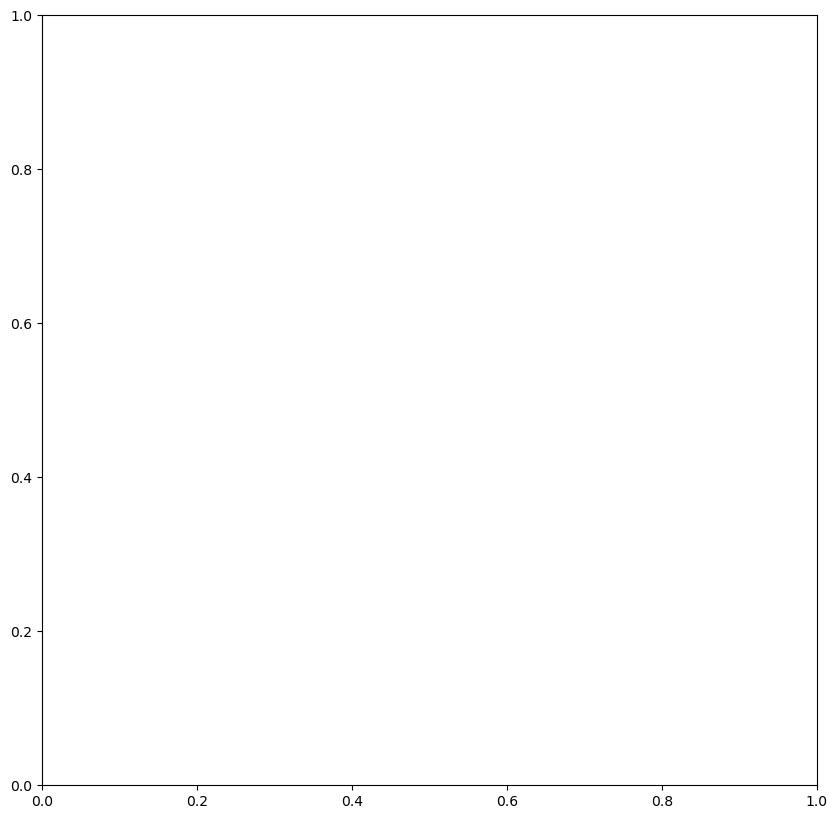

In [104]:
#Plotting time difference

sn_dims = jnp.array(dims)

sn_score_tmean = jnp.array([time.average for time in time_score])
sn_score_tstd = jnp.array([time.stdev for time in time_bridge])

sn_bridge_tmean = jnp.array([time.average for time in time_bridge])
sn_bridge_tstd = jnp.array([time.stdev for time in time_bridge])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(sn_dims, sn_score_tmean, color='orange')
ax.plot(sn_dims, sn_bridge_tmean, color='blue')
ax.set_xlabel(f'$N$')
ax.set_ylabel(f'$Time$')
ax.grid(True)
ax.fill_between(
    rn_dims,
    jnp.maximum(sn_score_tmean - 1.96 * sn_score_tstd, jnp.zeros_like(sn_score_tmean)),
    jnp.maximum(sn_score_tmean + 1.96 * sn_score_tstd, jnp.zeros_like(sn_score_tmean)),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    dims,
    jnp.maximum(sn_bridge_tmean - 1.96 * sn_bridge_tstd, jnp.zeros_like(sn_bridge_tmean)),
    jnp.maximum(sn_bridge_tmean + 1.96 * sn_bridge_tstd, jnp.zeros_like(sn_bridge_tmean)),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)



# n-Ellipsoid

## Defining Manifold and Loading Score

In [141]:
N = 2 #Change this for Ellipsoid2, Ellipsoid3, Ellipsoid5, Ellipsoid10, Ellipsoid20
s2_approximation = True

In [142]:
M = nEllipsoid(N=N, params = jnp.linspace(0.5,1.0,N+1))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [143]:
file_path = 'scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Ellipsoid'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,200,200,100,50]
elif N<50:
    layers = [50,100,200,400,400,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [144]:
loss = jnp.load('scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


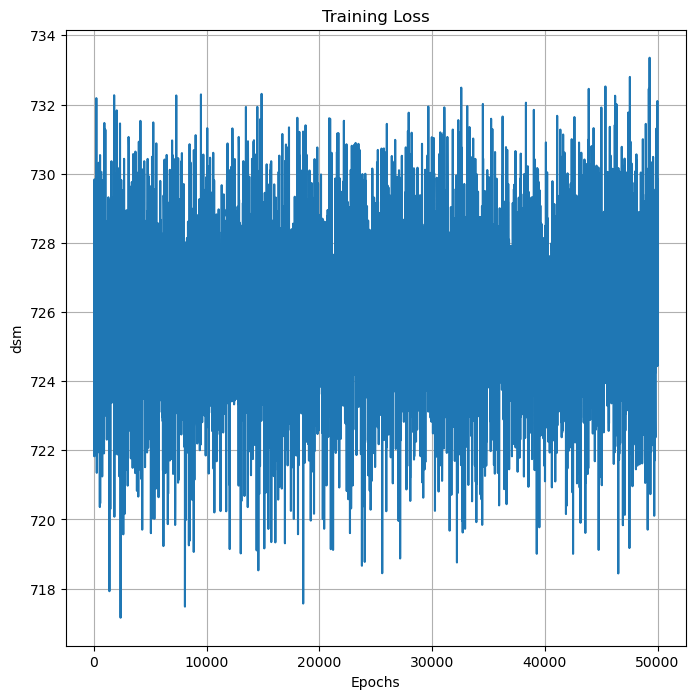

In [145]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

In [146]:
loss = jnp.load('scores/Ellipsoid'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  17960


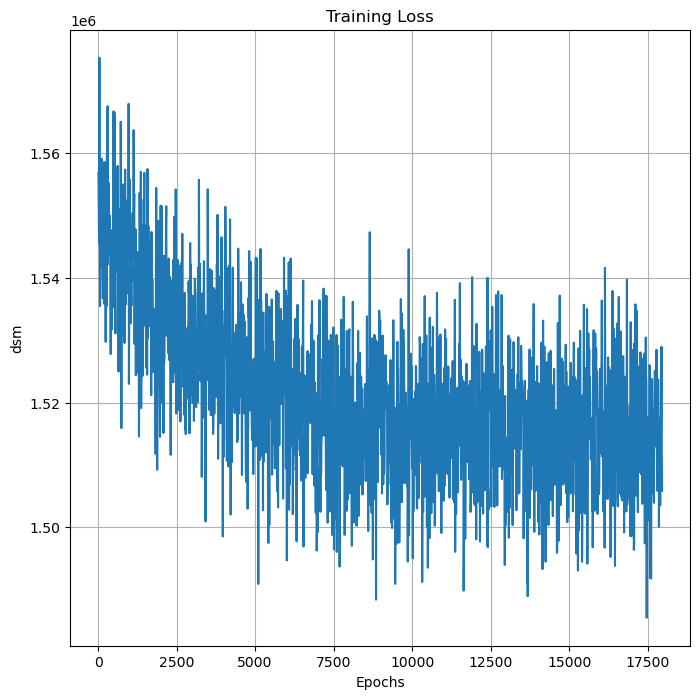

In [147]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [148]:
xs = pd.read_csv('Data/Ellipsoid'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Ellipsoid'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

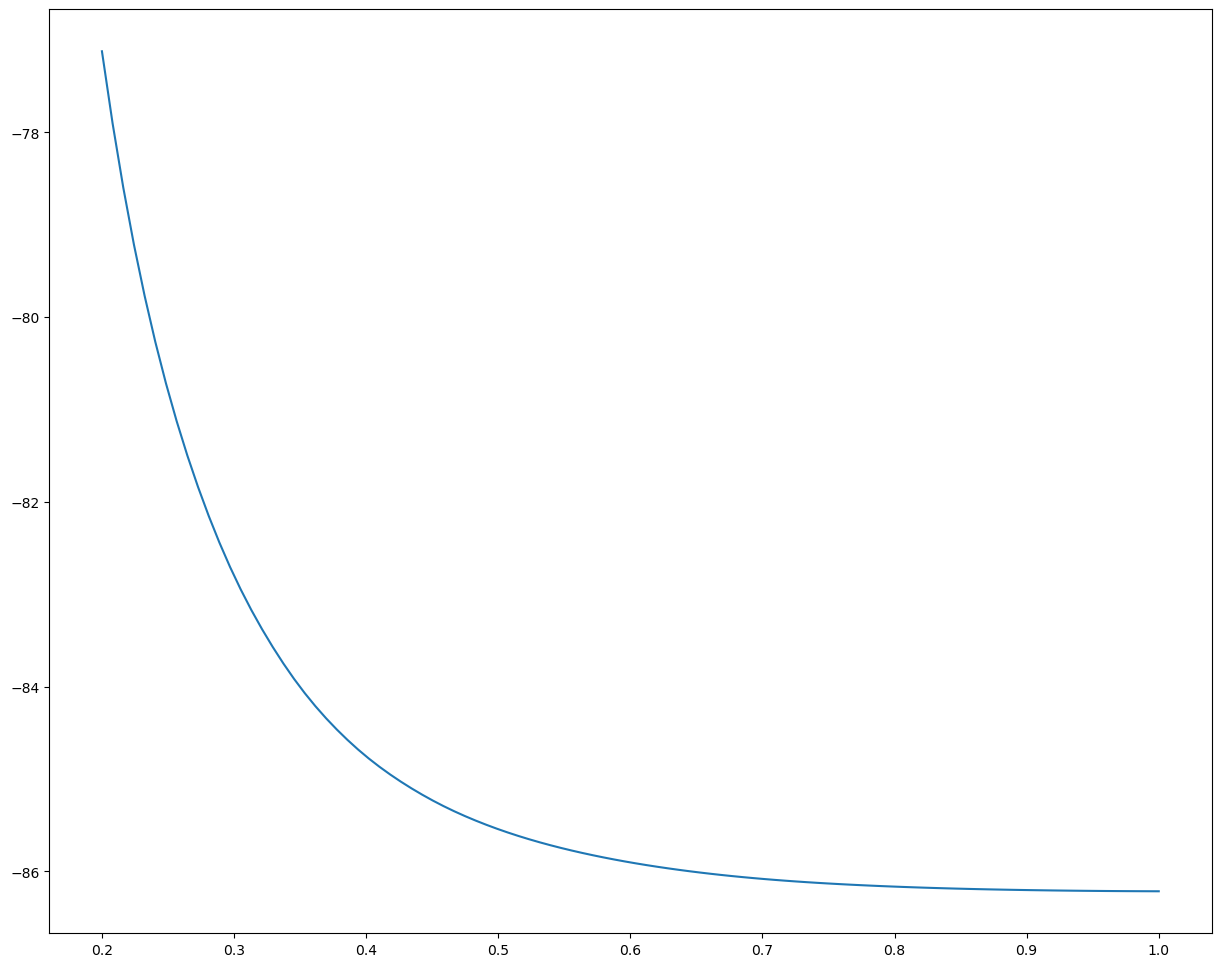

In [149]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [69]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [70]:
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=1000)

In [13]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 7.988443e+00 | T: ((Array([ 7.304285e-10,  7.072030e-09, -7.675185e-10,  0.000000e+00,
       -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 1 | T: 6.308940e+00 | T: ((Array([ 0.00267503, -0.00850208,  0.00732838, -0.00878681,  0.0043459 ],      dtype=float32), Array(0.21986869, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Final 1 | T: 6.308940e+00 | T: (Array([ 0.00267503, -0.00850208,  0.00732838, -0.00878681,  0.0043459 ],      dtype=float32), Array(0.21986869, dtype=float32))
Step 0 | T: 7.988943e+00 | T: ((Array([ 7.304285e-10,  7.072030e-09, -7.675185e-10,  0.000000e+00,
       -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 1

Step 28 | T: 1.443838e+00 | T: ((Array([-0.00113742, -0.01998527,  0.00696823, -0.0085279 , -0.05336267],      dtype=float32), Array(0.39043367, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 29 | T: 1.431378e+00 | T: ((Array([-0.00105809, -0.01812041,  0.00690034, -0.00997708, -0.0531062 ],      dtype=float32), Array(0.39342338, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 30 | T: 1.419907e+00 | T: ((Array([-0.00059141, -0.01643053,  0.00661477, -0.01143166, -0.05278644],      dtype=float32), Array(0.3962499, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 31 | T: 1.411155e+00 | T: ((Array([ 7.74780638e-05, -1.49261085e-02,  6.13748934e-03, -1.28165698e-02,
       -5.24291657e-02], dtype=float32), Array(0.39892128, dtype=float32)), Arra

Step 58 | T: 1.340508e+00 | T: ((Array([ 0.00017663, -0.01796327,  0.00326702, -0.01182691, -0.05704661],      dtype=float32), Array(0.43422815, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 59 | T: 1.341329e+00 | T: ((Array([ 0.0004388 , -0.01813338,  0.00306873, -0.01221958, -0.05729782],      dtype=float32), Array(0.4347436, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 60 | T: 1.338729e+00 | T: ((Array([ 0.0006343 , -0.01824311,  0.00288849, -0.01259238, -0.05749977],      dtype=float32), Array(0.43522942, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 61 | T: 1.340548e+00 | T: ((Array([ 0.00075199, -0.0182962 ,  0.00273261, -0.01292981, -0.05765264],      dtype=float32), Array(0.43568757, dtype=float32)), Array([ 0.13723479,  0.020

Step 89 | T: 1.336584e+00 | T: ((Array([ 0.00036709, -0.01503757,  0.0029117 , -0.01270778, -0.05757137],      dtype=float32), Array(0.44176534, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 90 | T: 1.337759e+00 | T: ((Array([ 0.0001713 , -0.01509787,  0.00297327, -0.01272994, -0.05764845],      dtype=float32), Array(0.44184697, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 91 | T: 1.337981e+00 | T: ((Array([ 0.00021848, -0.01516283,  0.00303546, -0.0127139 , -0.05772037],      dtype=float32), Array(0.44192395, dtype=float32)), Array([ 0.13723479,  0.0201403 ,  0.19753148, -0.0797253 ,  0.09387902,
        0.9625865 ], dtype=float32))
Step 92 | T: 1.337053e+00 | T: ((Array([ 0.00053351, -0.01523165,  0.00308997, -0.01266958, -0.05778564],      dtype=float32), Array(0.44199648, dtype=float32)), Array([ 0.13723479,  0.02

In [71]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0030 -0.0057 0.1005 )
T = 0.2184


In [72]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgechart' is not defined

In [251]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0024 
 -T error = 0.1271


In [289]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.47992 
 -T error = 0.3787


NameError: name 'mu_bridgechart' is not defined

## Timing Score

In [103]:
dims = [2,3,5,10]
time_score = []
time_bridge = []

for N in dims:
    print(N)
    M = nEllipsoid(N=N, params = jnp.linspace(0.5,1.0,N+1))
    jstoch.Brownian_coords(M)
    jstat.diffusion_mean(M)
    x0 = M.coords([0.]*N)

    file_path = 'scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/'
    state = model_loader.load_model(file_path)

    file_path_s2 = 'scores/Ellipsoid'+str(N)+'/s2/'
    state_s2 = model_loader.load_model(file_path_s2)
    if N<10:
        layers = [50,100,100,50]
    elif N<50:
        layers = [50,100,200,200,100,50]
    else:
        layers = [50,100,200,400,400,200,100,50]
    s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
    s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                    dim=M.emb_dim, r = max(M.dim//2,1))(x))
    rng_key = jax.random.PRNGKey(2712)
    def grady_log(x,y,t):

        return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

    def gradt_log(x,y,t):

        s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
        s2_val = ggrady_log(x,y,t)
        s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)

        div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())

        return 0.5*(jnp.dot(s1_val, s1_val)+div)

    def ggrady_log_ad(x,y,t):

        ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)

        return ggrad

    def ggrady_log_score(x,y,t):

        ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))

        return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

    if s2_approximation:
        ggrady_log = ggrady_log_score
    else:
        ggrady_log = ggrady_log_ad
        
    xs = pd.read_csv('Data/Ellipsoid'+str(N)+'/xs.csv', header=None)
    charts = pd.read_csv('Data/Ellipsoid'+str(N)+'/chart.csv', header=None)
    X_obs = (jnp.array(xs.values), jnp.array(charts.values))
    
    diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
    result = %timeit -o M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), \
                                           step_size=0.01, max_iter=100)
    time_score.append(result)
    result = %timeit -o M.diffusion_mean(X_obs,num_steps=100, N=1)
    time_bridge.append(result)

2
using M.Exp for Logarithm
914 ms ± 9.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Step 0 | T: 9.045785e+00 | T: ((Array([ 0.01163083, -0.0434425 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 7.991252e+00 | T: ((Array([ 0.01245216, -0.03357188], dtype=float32), Array(0.21992584, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 7.101362e+00 | T: ((Array([ 0.0160122 , -0.02392925], dtype=float32), Array(0.22973661, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 6.349108e+00 | T: ((Array([ 0.01915262, -0.01461921], dtype=float32), Array(0.2393977, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 4 | T: 5.710273e+00 | T: ((Array([ 0.02020616, -0.00574349], dtype=float32), Array(0.2488805, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166684e+00 | T: ((Array([0.01926227, 0.00260007], dtype=float32), Array(0.25816208, dtype=float32)), Array([0., 0., 1.], dtype=

Step 64 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 66 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 67 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 68 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 69 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 70 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: nan | T: ((

Step 25 | T: 1.628686e+00 | T: ((Array([0.01294184, 0.03626966], dtype=float32), Array(0.3937581, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578584e+00 | T: ((Array([0.01356781, 0.03414906], dtype=float32), Array(0.3983018, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.532483e+00 | T: ((Array([0.01421534, 0.03199829], dtype=float32), Array(0.40268132, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490357e+00 | T: ((Array([0.01475554, 0.02984851], dtype=float32), Array(0.40690377, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.450842e+00 | T: ((Array([0.0151051 , 0.02772752], dtype=float32), Array(0.41097602, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415187e+00 | T: ((Array([0.01520836, 0.02566148], dtype=float32), Array(0.41490492, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382138e+00 | T: ((Array([0.01506971, 0.02367251], dtype=float32), Array(0.4

Step 80 | T: 8.526035e-01 | T: ((Array([0.01261372, 0.01755135], dtype=float32), Array(0.52148575, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.493322e-01 | T: ((Array([0.01260655, 0.01741161], dtype=float32), Array(0.5227987, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.456793e-01 | T: ((Array([0.01259632, 0.0172654 ], dtype=float32), Array(0.524097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.416598e-01 | T: ((Array([0.0125951 , 0.01711522], dtype=float32), Array(0.52538097, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386741e-01 | T: ((Array([0.01258443, 0.0169617 ], dtype=float32), Array(0.5266509, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.350921e-01 | T: ((Array([0.01258632, 0.01680811], dtype=float32), Array(0.52790713, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323963e-01 | T: ((Array([0.01258634, 0.01665593], dtype=float32), Array(0.529

Step 38 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 39 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 40 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 41 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 42 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 43 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 44 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 45 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 46 | T: nan | T: ((

Step 4 | T: 5.711473e+00 | T: ((Array([ 0.02016209, -0.00573971], dtype=float32), Array(0.24888098, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 5.166816e+00 | T: ((Array([0.01922329, 0.0026055 ], dtype=float32), Array(0.2581626, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 6 | T: 4.701509e+00 | T: ((Array([0.01714822, 0.01033262], dtype=float32), Array(0.26722497, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 7 | T: 4.300499e+00 | T: ((Array([0.01478965, 0.01736988], dtype=float32), Array(0.2760544, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 8 | T: 3.955084e+00 | T: ((Array([0.01288747, 0.02366466], dtype=float32), Array(0.28464112, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 9 | T: 3.655872e+00 | T: ((Array([0.01190002, 0.02918439], dtype=float32), Array(0.29297855, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 10 | T: 3.393794e+00 | T: ((Array([0.0119092 , 0.03391863], dtype=float32), Array(0.30106

Step 59 | T: 9.597480e-01 | T: ((Array([0.01335757, 0.01459817], dtype=float32), Array(0.48954654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: 9.532180e-01 | T: ((Array([0.01332889, 0.01506102], dtype=float32), Array(0.49131104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 61 | T: 9.462790e-01 | T: ((Array([0.01324594, 0.01549778], dtype=float32), Array(0.49304473, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: 9.399000e-01 | T: ((Array([0.01313908, 0.01590524], dtype=float32), Array(0.49474895, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 63 | T: 9.334344e-01 | T: ((Array([0.01302965, 0.01628076], dtype=float32), Array(0.49642488, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 64 | T: 9.274523e-01 | T: ((Array([0.01291892, 0.01662284], dtype=float32), Array(0.4980737, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: 9.219731e-01 | T: ((Array([0.01283034, 0.01692861], dtype=float32), Array(0.

Step 16 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 22 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 23 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 24 | T: nan | T: ((

Step 84 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 87 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 88 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 89 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 90 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 91 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 92 | T: nan | T: ((

Step 51 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 52 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 53 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 54 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 59 | T: nan | T: ((

Step 15 | T: 2.483171e+00 | T: ((Array([0.01686817, 0.04654293], dtype=float32), Array(0.33768317, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 16 | T: 2.354946e+00 | T: ((Array([0.01693961, 0.0471529 ], dtype=float32), Array(0.34426856, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 17 | T: 2.239385e+00 | T: ((Array([0.01649255, 0.04725169], dtype=float32), Array(0.35061872, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: 2.135923e+00 | T: ((Array([0.01567659, 0.04689742], dtype=float32), Array(0.35673988, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: 2.041491e+00 | T: ((Array([0.01466813, 0.04614703], dtype=float32), Array(0.3626386, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: 1.956218e+00 | T: ((Array([0.01367999, 0.04505685], dtype=float32), Array(0.36832184, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: 1.877450e+00 | T: ((Array([0.01287332, 0.04367841], dtype=float32), Array(0.

Step 70 | T: 8.955953e-01 | T: ((Array([0.01285   , 0.01794191], dtype=float32), Array(0.50745, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 71 | T: 8.904602e-01 | T: ((Array([0.01288277, 0.01802357], dtype=float32), Array(0.50893635, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 72 | T: 8.860428e-01 | T: ((Array([0.01291974, 0.01807266], dtype=float32), Array(0.5104028, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 73 | T: 8.811446e-01 | T: ((Array([0.01293461, 0.01808997], dtype=float32), Array(0.51184994, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 74 | T: 8.766546e-01 | T: ((Array([0.0129155 , 0.01807828], dtype=float32), Array(0.5132784, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 75 | T: 8.727586e-01 | T: ((Array([0.01287149, 0.01804045], dtype=float32), Array(0.5146889, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 76 | T: 8.682425e-01 | T: ((Array([0.0128057, 0.0179783], dtype=float32), Array(0.5160819

Step 25 | T: 1.628514e+00 | T: ((Array([0.013002 , 0.0362714], dtype=float32), Array(0.3937595, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.578343e+00 | T: ((Array([0.0136104 , 0.03415186], dtype=float32), Array(0.39830318, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.531988e+00 | T: ((Array([0.01422564, 0.03200113], dtype=float32), Array(0.40268257, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.490155e+00 | T: ((Array([0.01473398, 0.02985139], dtype=float32), Array(0.4069049, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 29 | T: 1.451111e+00 | T: ((Array([0.01504014, 0.02773125], dtype=float32), Array(0.4109771, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.415330e+00 | T: ((Array([0.01511728, 0.02566602], dtype=float32), Array(0.414906, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.382319e+00 | T: ((Array([0.01497632, 0.02367731], dtype=float32), Array(0.418698

Step 80 | T: 8.528425e-01 | T: ((Array([0.01258389, 0.01757165], dtype=float32), Array(0.52148867, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 8.492763e-01 | T: ((Array([0.01256143, 0.01743128], dtype=float32), Array(0.52280164, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 8.455395e-01 | T: ((Array([0.01255391, 0.01728428], dtype=float32), Array(0.52409995, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: 8.422064e-01 | T: ((Array([0.0125618 , 0.01713132], dtype=float32), Array(0.52538395, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 8.386081e-01 | T: ((Array([0.01258198, 0.01697478], dtype=float32), Array(0.526654, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 8.354800e-01 | T: ((Array([0.0126243 , 0.01681809], dtype=float32), Array(0.5279104, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 8.323006e-01 | T: ((Array([0.01266598, 0.01666282], dtype=float32), Array(0.52

Step 24 | T: 2.180932e+00 | T: ((Array([-0.07632288,  0.01397538,  0.03365638], dtype=float32), Array(0.38671273, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 25 | T: 2.110601e+00 | T: ((Array([-0.07807811,  0.01305317,  0.03199854], dtype=float32), Array(0.39128554, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 26 | T: 2.046082e+00 | T: ((Array([-0.07953563,  0.01205928,  0.03016413], dtype=float32), Array(0.3956882, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 27 | T: 1.986766e+00 | T: ((Array([-0.08071133,  0.01104077,  0.02818881], dtype=float32), Array(0.39992818, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 28 | T: 1.932590e+00 | T: ((Array([-0.08162117,  0.0100344 ,  0.02610647], dtype=float32), Array(0.40401283, dtype=float32)), Array([-0.03674259,  0.18040879,  0.003065

Step 64 | T: 1.195142e+00 | T: ((Array([-0.05150324,  0.00725415, -0.00202238], dtype=float32), Array(0.4912967, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 65 | T: 1.187531e+00 | T: ((Array([-0.05086002,  0.00718176, -0.00153639], dtype=float32), Array(0.49283504, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 66 | T: 1.179862e+00 | T: ((Array([-0.05026503,  0.00714597, -0.00105861], dtype=float32), Array(0.49434927, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 67 | T: 1.173751e+00 | T: ((Array([-0.04971831,  0.00713644, -0.000595  ], dtype=float32), Array(0.49584037, dtype=float32)), Array([-0.03674259,  0.18040879,  0.00306588,  0.9829004 ], dtype=float32))
Step 68 | T: 1.166327e+00 | T: ((Array([-0.04921651,  0.00715526, -0.00014741], dtype=float32), Array(0.4973092, dtype=float32)), Array([-0.03674259,  0.18040879,  0.0030658

Step 4 | T: 7.920360e+00 | T: ((Array([-0.03754917, -0.02907104,  0.03917426], dtype=float32), Array(0.24882035, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114683e+00 | T: ((Array([-0.04628538, -0.03226851,  0.04847256], dtype=float32), Array(0.2580634, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428734e+00 | T: ((Array([-0.0546921 , -0.03381805,  0.0573892 ], dtype=float32), Array(0.26707602, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843668e+00 | T: ((Array([-0.06273833, -0.03397847,  0.06585204], dtype=float32), Array(0.2758443, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593223, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341877e+00 | T: ((Array([ 9.5814601e-10,  1.0832047e-10, -1.8833879e-09], dtype=float32), Array(0.28435847, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899

Step 44 | T: 1.430257e+00 | T: ((Array([-0.07306666,  0.0079308 , -0.0026878 ], dtype=float32), Array(0.45334113, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 45 | T: 1.413023e+00 | T: ((Array([-0.07180492,  0.00830906, -0.00354675], dtype=float32), Array(0.45568585, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 46 | T: 1.395797e+00 | T: ((Array([-0.07052713,  0.00864812, -0.00427345], dtype=float32), Array(0.45796838, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 47 | T: 1.379908e+00 | T: ((Array([-0.06924219,  0.00893948, -0.00487144], dtype=float32), Array(0.46019188, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 48 | T: 1.365347e+00 | T: ((Array([-0.06795681,  0.00917245, -0.00534546], dtype=float32), Array(0.46235937, dtype=float32)), Array([-0.03673254,  0.18041973,  0.00300

Step 84 | T: 1.083288e+00 | T: ((Array([-0.0458579 ,  0.00777991,  0.00319078], dtype=float32), Array(0.5183311, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 85 | T: 1.078878e+00 | T: ((Array([-0.04584624,  0.00773207,  0.00317659], dtype=float32), Array(0.5195156, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 86 | T: 1.074768e+00 | T: ((Array([-0.04584648,  0.00767833,  0.00314449], dtype=float32), Array(0.5206871, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 87 | T: 1.070988e+00 | T: ((Array([-0.0458559 ,  0.00762035,  0.00309489], dtype=float32), Array(0.521846, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  ,  0.982899  ], dtype=float32))
Step 88 | T: 1.067153e+00 | T: ((Array([-0.04587323,  0.00756016,  0.00302863], dtype=float32), Array(0.52299255, dtype=float32)), Array([-0.03673254,  0.18041973,  0.003002  , 

Step 24 | T: 2.181210e+00 | T: ((Array([-0.07632178,  0.01395577,  0.03366904], dtype=float32), Array(0.386712, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 25 | T: 2.110474e+00 | T: ((Array([-0.07807846,  0.01302865,  0.03200902], dtype=float32), Array(0.39128482, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 26 | T: 2.046990e+00 | T: ((Array([-0.07953769,  0.01203413,  0.03017149], dtype=float32), Array(0.39568758, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 27 | T: 1.987230e+00 | T: ((Array([-0.08071557,  0.01101506,  0.02819367], dtype=float32), Array(0.39992768, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 28 | T: 1.932219e+00 | T: ((Array([-0.08162772,  0.01001132,  0.02610901], dtype=float32), Array(0.40401235, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 64 | T: 1.195109e+00 | T: ((Array([-0.0514839 ,  0.00729262, -0.00203124], dtype=float32), Array(0.4912951, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 65 | T: 1.187732e+00 | T: ((Array([-0.05083869,  0.00720299, -0.00154877], dtype=float32), Array(0.4928334, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 66 | T: 1.179949e+00 | T: ((Array([-0.05024233,  0.00714788, -0.00107492], dtype=float32), Array(0.49434757, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 67 | T: 1.173604e+00 | T: ((Array([-0.04969326,  0.00712425, -0.00061408], dtype=float32), Array(0.49583858, dtype=float32)), Array([-0.03674789,  0.18041676,  0.00301229,  0.9828989 ], dtype=float32))
Step 68 | T: 1.167078e+00 | T: ((Array([-0.04918887,  0.00713048, -0.00016838], dtype=float32), Array(0.49730736, dtype=float32)), Array([-0.03674789,  0.18041676,  0.0030122

Step 4 | T: 7.919983e+00 | T: ((Array([-0.03755009, -0.02908238,  0.03917663], dtype=float32), Array(0.24881986, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114481e+00 | T: ((Array([-0.04628715, -0.03228177,  0.04847465], dtype=float32), Array(0.25806257, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.428839e+00 | T: ((Array([-0.05469453, -0.03383695,  0.05739053], dtype=float32), Array(0.26707485, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.843569e+00 | T: ((Array([-0.06274144, -0.03399646,  0.0658535 ], dtype=float32), Array(0.27584288, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.340868e+00 | T: ((Array([ 2.4467806e-09,  2.1462701e-11, -1.8297976e-09], dtype=float32), Array(0.2843566, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.98290

Step 44 | T: 1.430719e+00 | T: ((Array([-0.07304336,  0.0079729 , -0.00270865], dtype=float32), Array(0.45333236, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 45 | T: 1.413223e+00 | T: ((Array([-0.0717819 ,  0.00834753, -0.00356317], dtype=float32), Array(0.45567712, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 46 | T: 1.396348e+00 | T: ((Array([-0.07050394,  0.00868422, -0.00428509], dtype=float32), Array(0.4579597, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 47 | T: 1.379564e+00 | T: ((Array([-0.06921791,  0.00897365, -0.00487857], dtype=float32), Array(0.46018326, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 48 | T: 1.364959e+00 | T: ((Array([-0.06793229,  0.00920542, -0.00534849], dtype=float32), Array(0.46235082, dtype=float32)), Array([-0.03672874,  0.18041234,  0.002953

Step 84 | T: 1.082973e+00 | T: ((Array([-0.0458329 ,  0.00785341,  0.00318827], dtype=float32), Array(0.5183209, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 85 | T: 1.078416e+00 | T: ((Array([-0.04582181,  0.00780332,  0.00316793], dtype=float32), Array(0.5195053, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 86 | T: 1.075073e+00 | T: ((Array([-0.04582163,  0.00774661,  0.00312912], dtype=float32), Array(0.52067685, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 87 | T: 1.071362e+00 | T: ((Array([-0.04583264,  0.00768042,  0.00307471], dtype=float32), Array(0.52183574, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366,  0.9829006 ], dtype=float32))
Step 88 | T: 1.066998e+00 | T: ((Array([-0.04585174,  0.00761448,  0.00300694], dtype=float32), Array(0.5229823, dtype=float32)), Array([-0.03672874,  0.18041234,  0.00295366

Step 24 | T: 2.181390e+00 | T: ((Array([-0.07634588,  0.01393291,  0.03365735], dtype=float32), Array(0.38670892, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 25 | T: 2.111240e+00 | T: ((Array([-0.07810432,  0.01299793,  0.0319964 ], dtype=float32), Array(0.3912816, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 26 | T: 2.047206e+00 | T: ((Array([-0.07956445,  0.01199939,  0.03015795], dtype=float32), Array(0.39568427, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 27 | T: 1.987495e+00 | T: ((Array([-0.08074307,  0.01097715,  0.02817926], dtype=float32), Array(0.3999243, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 28 | T: 1.932657e+00 | T: ((Array([-0.08165558,  0.00997228,  0.02609472], dtype=float32), Array(0.40400898, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 64 | T: 1.194899e+00 | T: ((Array([-0.05150449,  0.00730229, -0.00203192], dtype=float32), Array(0.4912919, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 65 | T: 1.187667e+00 | T: ((Array([-0.0508603 ,  0.00721967, -0.00154921], dtype=float32), Array(0.4928303, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 66 | T: 1.180626e+00 | T: ((Array([-0.05026455,  0.00716641, -0.00107522], dtype=float32), Array(0.49434465, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 67 | T: 1.173752e+00 | T: ((Array([-0.04971559,  0.00714746, -0.00061294], dtype=float32), Array(0.49583587, dtype=float32)), Array([-0.03674502,  0.18041939,  0.00303383,  0.9828985 ], dtype=float32))
Step 68 | T: 1.166353e+00 | T: ((Array([-0.04921364,  0.0071597 , -0.00016939], dtype=float32), Array(0.49730483, dtype=float32)), Array([-0.03674502,  0.18041939,  0.0030338

Step 4 | T: 7.921003e+00 | T: ((Array([-0.03754768, -0.02905001,  0.03917802], dtype=float32), Array(0.24882077, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 5 | T: 7.114496e+00 | T: ((Array([-0.0462841 , -0.03224456,  0.04847597], dtype=float32), Array(0.2580638, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 6 | T: 6.430240e+00 | T: ((Array([-0.05469113, -0.03378661,  0.05739272], dtype=float32), Array(0.26707646, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 7 | T: 5.844712e+00 | T: ((Array([-0.06273765, -0.03394192,  0.06585623], dtype=float32), Array(0.2758449, dtype=float32)), Array([0.04567189, 0.35533902, 0.07593224, 0.9305281 ], dtype=float32))
Step 8 | T: 5.341676e+00 | T: ((Array([-6.4139853e-09, -2.8468812e-11,  1.6161046e-09], dtype=float32), Array(0.28435913, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.982898

Step 44 | T: 1.430168e+00 | T: ((Array([-0.07303432,  0.00793134, -0.00264969], dtype=float32), Array(0.4533359, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 45 | T: 1.412456e+00 | T: ((Array([-0.07177364,  0.00830642, -0.00350672], dtype=float32), Array(0.45568043, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 46 | T: 1.395867e+00 | T: ((Array([-0.0704971 ,  0.00864153, -0.00423124], dtype=float32), Array(0.45796278, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 47 | T: 1.380344e+00 | T: ((Array([-0.06921256,  0.00892865, -0.00482781], dtype=float32), Array(0.46018618, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 48 | T: 1.365081e+00 | T: ((Array([-0.06792774,  0.009156  , -0.00530044], dtype=float32), Array(0.46235362, dtype=float32)), Array([-0.03674645,  0.18041795,  0.003067

Step 84 | T: 1.083711e+00 | T: ((Array([-0.04587873,  0.00781169,  0.00318143], dtype=float32), Array(0.518325, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 85 | T: 1.078781e+00 | T: ((Array([-0.04586844,  0.00775813,  0.00316301], dtype=float32), Array(0.5195095, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 86 | T: 1.074830e+00 | T: ((Array([-0.04586916,  0.00769546,  0.00312654], dtype=float32), Array(0.5206811, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 87 | T: 1.071238e+00 | T: ((Array([-0.04587795,  0.00762757,  0.00307468], dtype=float32), Array(0.52184004, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,  0.98289853], dtype=float32))
Step 88 | T: 1.067188e+00 | T: ((Array([-0.04589515,  0.00756099,  0.00300977], dtype=float32), Array(0.52298665, dtype=float32)), Array([-0.03674645,  0.18041795,  0.00306786,

Step 24 | T: 2.181361e+00 | T: ((Array([-0.07632068,  0.01407506,  0.03363745], dtype=float32), Array(0.38670778, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 25 | T: 2.110771e+00 | T: ((Array([-0.07807758,  0.01315674,  0.031977  ], dtype=float32), Array(0.39128044, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 26 | T: 2.045927e+00 | T: ((Array([-0.07953639,  0.01216731,  0.03013863], dtype=float32), Array(0.395683, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 27 | T: 1.986577e+00 | T: ((Array([-0.08071247,  0.01114905,  0.02816003], dtype=float32), Array(0.39992285, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 28 | T: 1.932618e+00 | T: ((Array([-0.0816227 ,  0.01014393,  0.02607611], dtype=float32), Array(0.40400738, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

Step 64 | T: 1.195366e+00 | T: ((Array([-0.05145447,  0.00732757, -0.0020245 ], dtype=float32), Array(0.49129108, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 65 | T: 1.187483e+00 | T: ((Array([-0.05081154,  0.00723342, -0.00154079], dtype=float32), Array(0.49282944, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 66 | T: 1.181040e+00 | T: ((Array([-0.05021778,  0.00717502, -0.00106521], dtype=float32), Array(0.4943438, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 67 | T: 1.173500e+00 | T: ((Array([-0.04967105,  0.00713686, -0.00060252], dtype=float32), Array(0.49583498, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318 ,  0.9829007 ], dtype=float32))
Step 68 | T: 1.166558e+00 | T: ((Array([-0.04917051,  0.0071291 , -0.0001573 ], dtype=float32), Array(0.4973039, dtype=float32)), Array([-0.03672745,  0.18041287,  0.0029318

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (2,)

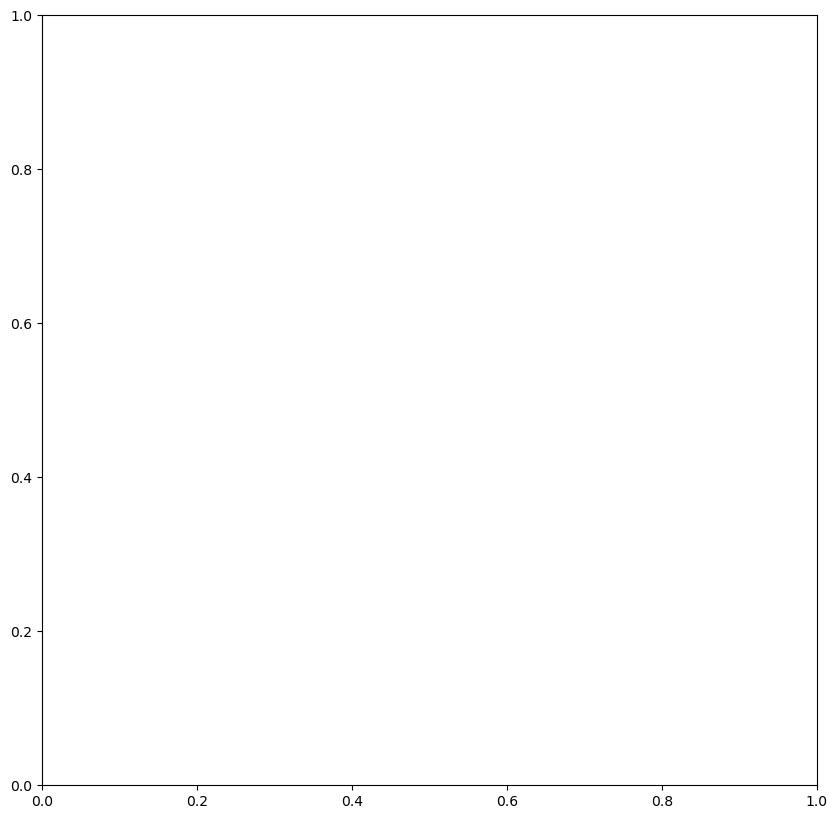

In [104]:
#Plotting time difference

ellipsoidn_dims = jnp.array(dims)

ellipsoidn_score_tmean = jnp.array([time.average for time in time_score])
ellipsoidn_score_tstd = jnp.array([time.stdev for time in time_bridge])

ellipsoidn_bridge_tmean = jnp.array([time.average for time in time_bridge])
ellipsoidn_bridge_tstd = jnp.array([time.stdev for time in time_bridge])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(sn_dims, ellipsoidn_score_tmean, color='orange')
ax.plot(sn_dims, ellipsoidn_bridge_tmean, color='blue')
ax.set_xlabel(f'$N$')
ax.set_ylabel(f'$Time$')
ax.grid(True)
ax.fill_between(
    rn_dims,
    jnp.maximum(ellipsoidn_score_tmean - 1.96 * ellipsoidn_score_tstd, jnp.zeros_like(ellipsoidn_score_tmean)),
    jnp.maximum(ellipsoidn_score_tmean + 1.96 * ellipsoidn_score_tstd, jnp.zeros_like(ellipsoidn_score_tmean)),
    color="tab:red",
    alpha=0.5,
)
ax.fill_between(
    dims,
    jnp.maximum(ellipsoidn_bridge_tmean - 1.96 * ellipsoidn_bridge_tstd, jnp.zeros_like(ellipsoidn_bridge_tmean)),
    jnp.maximum(ellipsoidn_bridge_tmean + 1.96 * ellipsoidn_bridge_tstd, jnp.zeros_like(ellipsoidn_bridge_tmean)),
    color="tab:pink",
    alpha=0.5,
)
ax.grid(True)



# Cylinder

## Defining Manifold and Loading Score

In [72]:
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [74]:
file_path = 'scores/Cylinder/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

#file_path_s2 = 'scores/Cylinder/s2/'
#state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if False:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [75]:
loss = jnp.load('scores/Cylinder/s1_' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  6800


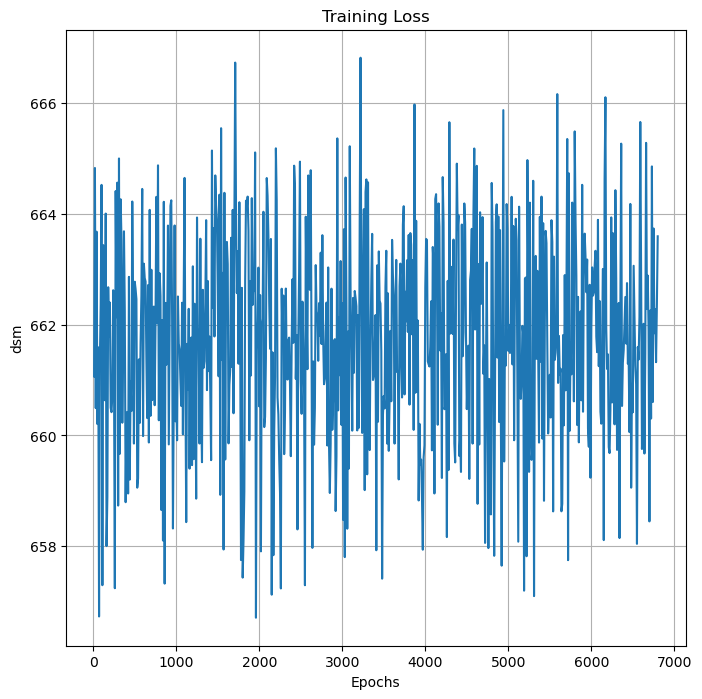

In [76]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [85]:
xs = pd.read_csv('Data/Cylinder/xs.csv', header=None)
charts = pd.read_csv('Data/Cylinder/chart.csv', header=None)
X_obs = (jnp.array(xs.values), vmap(lambda x,y: M.F((x,y)))(jnp.array(xs.values),jnp.array(charts.values)))

In [89]:
x0

(Array([0., 0.], dtype=float32), Array([0., 0.], dtype=float32))

In [87]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=1000)

ValueError: Incompatible shapes for broadcasting: shapes=[(), (2,), (3,)]

In [146]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.135751e+01 | T: ((Array([-0.05872891, -0.04805093], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.024655e+01 | T: ((Array([-0.04898103, -0.03818516], dtype=float32), Array(0.2199283, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.024655e+01 | T: (Array([-0.04898103, -0.03818516], dtype=float32), Array(0.2199283, dtype=float32))
Step 0 | T: 1.135751e+01 | T: ((Array([-0.05872891, -0.04805093], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.024655e+01 | T: ((Array([-0.04898103, -0.03818516], dtype=float32), Array(0.2199283, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 9.303733e+00 | T: ((Array([-0.03971378, -0.02855165], dtype=float32), Array(0.22974525, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 8.501101e+00 | T: ((Array([-0.03118584, -0.01925099], dtype=float32), Array(0.23941708, dtype=float32)), Array([0., 0.], dtype=flo

Step 53 | T: 2.570148e+00 | T: ((Array([-0.02293508,  0.0101991 ], dtype=float32), Array(0.48120186, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 2.559716e+00 | T: ((Array([-0.02304988,  0.01049353], dtype=float32), Array(0.48325464, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 2.549699e+00 | T: ((Array([-0.02321837,  0.01082371], dtype=float32), Array(0.4852669, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 2.540071e+00 | T: ((Array([-0.02343213,  0.01118275], dtype=float32), Array(0.48724052, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 2.530809e+00 | T: ((Array([-0.0236826 ,  0.01156408], dtype=float32), Array(0.48917726, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 2.521894e+00 | T: ((Array([-0.02396121,  0.01196148], dtype=float32), Array(0.4910788, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 2.513302e+00 | T: ((Array([-0.0242596 ,  0.01236912], dtype=float32), Array(0.4929467, dt

In [151]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0270 0.0392 )
T = 0.5400


In [152]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5505


In [153]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0475 
 -T error = 0.0105


In [154]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02377 
 -T error = 0.0400
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0505


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Torus

## Defining Manifold and Loading Score

In [155]:
M = Torus()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
x0[1]

using M.Exp for Logarithm


Array([0., 0.], dtype=float32)

In [169]:
file_path = 'scores/Torus/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Torus/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[1],y[1],t)))
    
    return jnp.dot(M.invJF((M.F(y), y[1])), ggrad)

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

FileNotFoundError: [Errno 2] No such file or directory: 'scores/Torus/s1_dsm/tree.pkl'

## Loading Loss

In [120]:
loss = jnp.load('scores/Torus/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


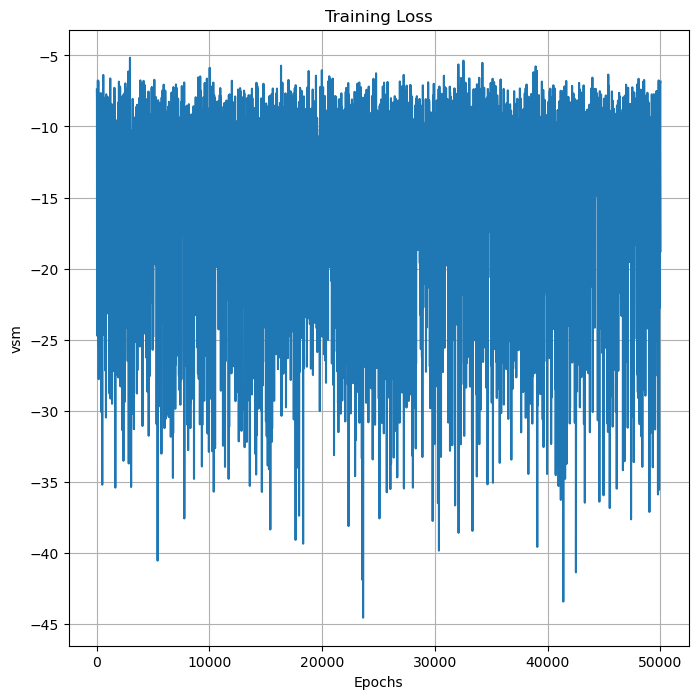

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [94]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [95]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [96]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.453338e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265824e+01 | T: ((Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.265824e+01 | T: (Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32))
Step 0 | T: 1.453340e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265763e+01 | T: ((Array([-0.17184542, -0.015028  ], dtype=float32), Array(0.21991298, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 1.108802e+01 | T: ((Array([-0.16201945, -0.02065388], dtype=float32), Array(0.22969085, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 9.771928e+00 | T: ((Array([-0.15233807, -0.02273714], dtype=float32), Array(0.2392931, dtype=float32)), Array([0., 0.], dtype=float

Step 53 | T: 1.572088e+00 | T: ((Array([ 0.01941139, -0.01369051], dtype=float32), Array(0.46345207, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 1.560797e+00 | T: ((Array([ 0.01918913, -0.0135701 ], dtype=float32), Array(0.4653291, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 1.549640e+00 | T: ((Array([ 0.01893759, -0.01354981], dtype=float32), Array(0.46717286, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 1.538876e+00 | T: ((Array([ 0.01866033, -0.0136252 ], dtype=float32), Array(0.4689849, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 1.528749e+00 | T: ((Array([ 0.01836071, -0.01377137], dtype=float32), Array(0.4707667, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 1.518717e+00 | T: ((Array([ 0.01804182, -0.01395113], dtype=float32), Array(0.47251964, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 1.508847e+00 | T: ((Array([ 0.01770659, -0.01414127], dtype=float32), Array(0.47424498, dt

In [97]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0266 -0.0372 )
T = 0.5016


In [98]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5290


In [99]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0457 
 -T error = 0.0274


In [101]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02286 
 -T error = 0.0016
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0290


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Hyperbolic Parabolid

## Defining Manifold and Loading Score

In [149]:
M = HypParaboloid()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
s2_approximation = False

using M.Exp for Logarithm


In [150]:
file_path = 'scores/HypParaboloid/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/HypParaboloid/s2/'
state_s2 = model_loader.load_model(file_path_s2)
layers = [50,100,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

if True:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [151]:
loss = jnp.load('scores/HypParaboloid/s1_' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  1330


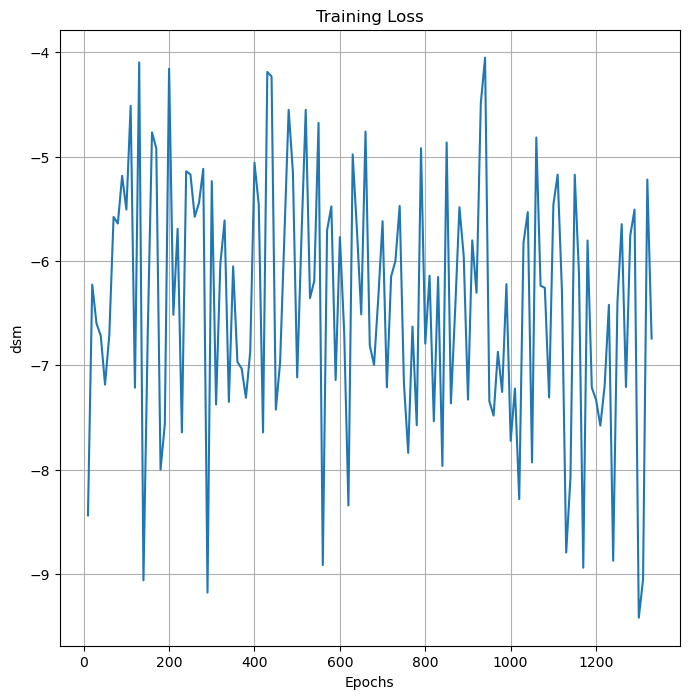

In [152]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [153]:
xs = pd.read_csv('Data/HypParaboloid/xs.csv', header=None)
charts = pd.read_csv('Data/HypParaboloid/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [154]:
grady_log((x0[0],jnp.zeros(3)),(x0[0],jnp.zeros(3)),0.5)

Array([0.25690737, 0.70860606], dtype=float32)

In [155]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.001, max_iter=1000)

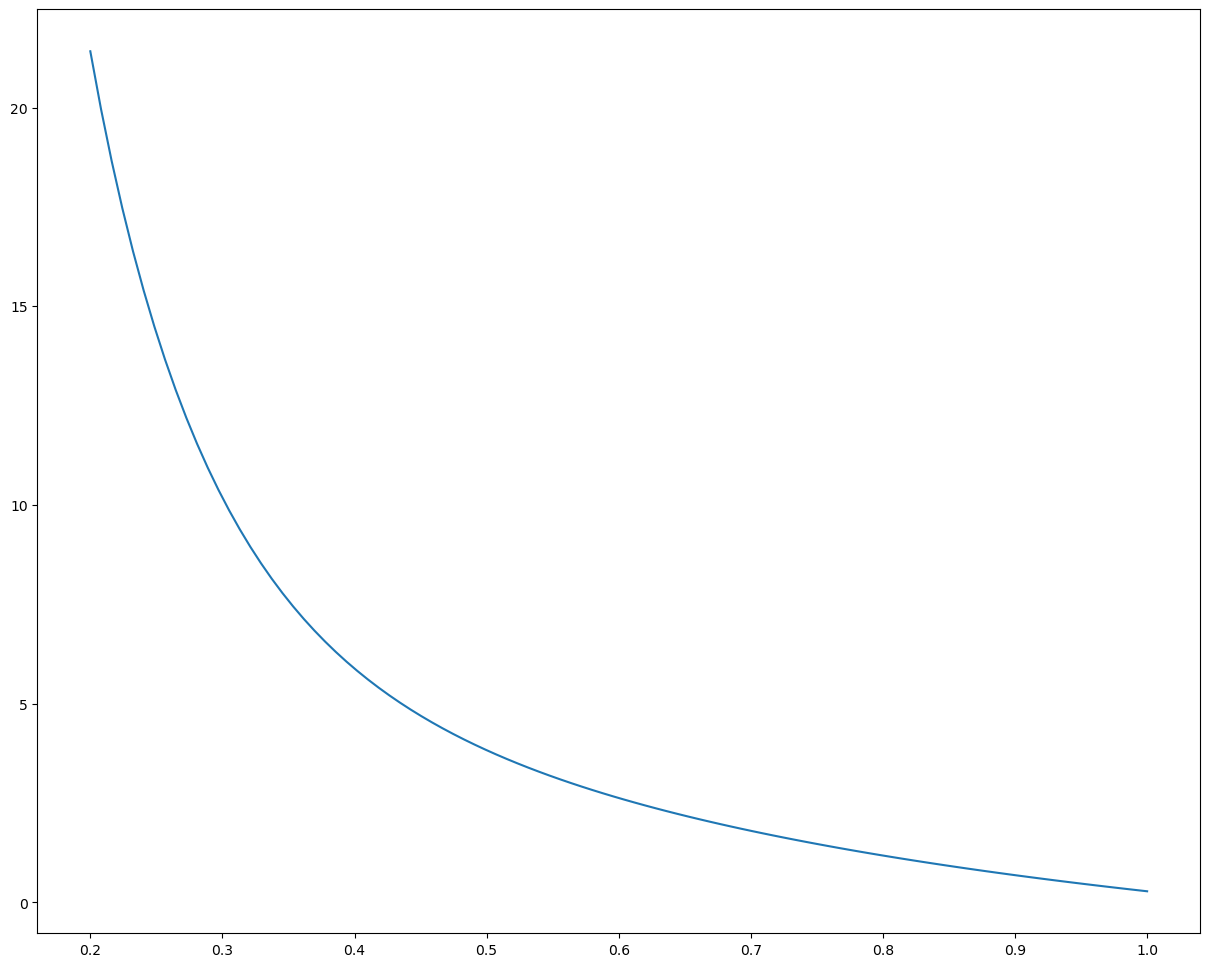

In [156]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log((mu_sm[0][-1], mu_sm[1][-1]), (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [126]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [157]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.1465 0.1171 )
T = 0.9504


In [158]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgechart' is not defined

In [100]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:


NameError: name 'mu_bridgechart' is not defined

In [101]:
M.F((mu_sm[0][-1], mu_sm[1][-1]))

Array([ 0.12422046,  0.13736227, -0.00343767], dtype=float32)

In [102]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.1852 
 -T error = 0.2719


NameError: name 'mu_bridgechart' is not defined

In [253]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

426 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# SPDN

## Defining Manifold and Loading Score

In [49]:
N = 2

In [50]:
M = SPDN(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [51]:
M.g(x0)

Array([[600., 200.,   0.],
       [200., 600., 400.],
       [  0., 400., 400.]], dtype=float32)

In [52]:
M.gsharp(x0)

Array([[ 0.0025, -0.0025,  0.0025],
       [-0.0025,  0.0075, -0.0075],
       [ 0.0025, -0.0075,  0.01  ]], dtype=float32)

In [53]:
M.gsharp(x0).dot(M.g(x0))

Array([[ 1.0000000e+00,  3.7252903e-08, -2.2351742e-08],
       [-5.9604645e-08,  9.9999988e-01, -1.1920929e-07],
       [ 3.3527613e-08, -8.9406967e-08,  9.9999988e-01]], dtype=float32)

In [54]:
file_path = 'scores/SPDN'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
file_path_s2 = 'scores/SPDN'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
from jax import jacfwd
if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

## Loading Loss

In [55]:
loss = jnp.load('scores/SPDN'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  380


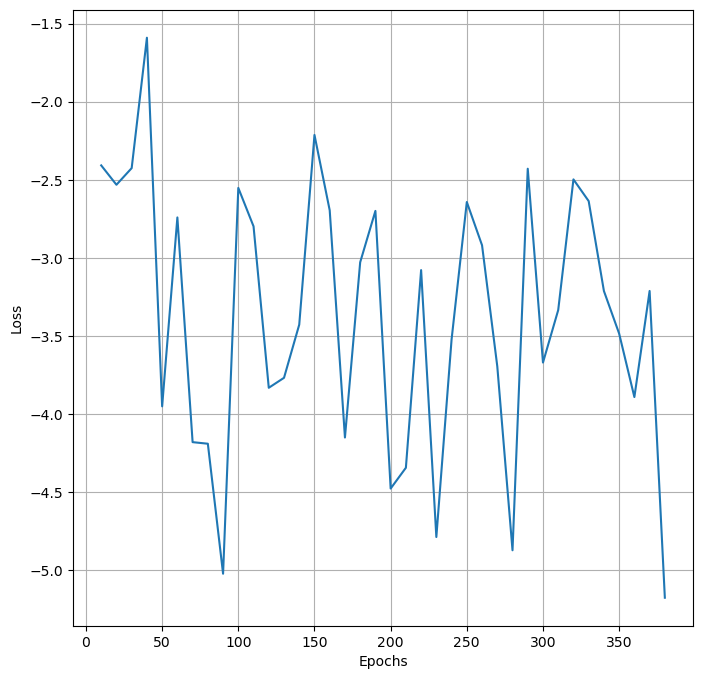

In [56]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [57]:
xs = pd.read_csv('Data/SPDN'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/SPDN'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values)[~jnp.isnan(xs.values).any(axis=1)], jnp.array(charts.values)[~jnp.isnan(xs.values).any(axis=1)])

In [58]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.01, max_iter=1000)

/home/fmry/anaconda3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


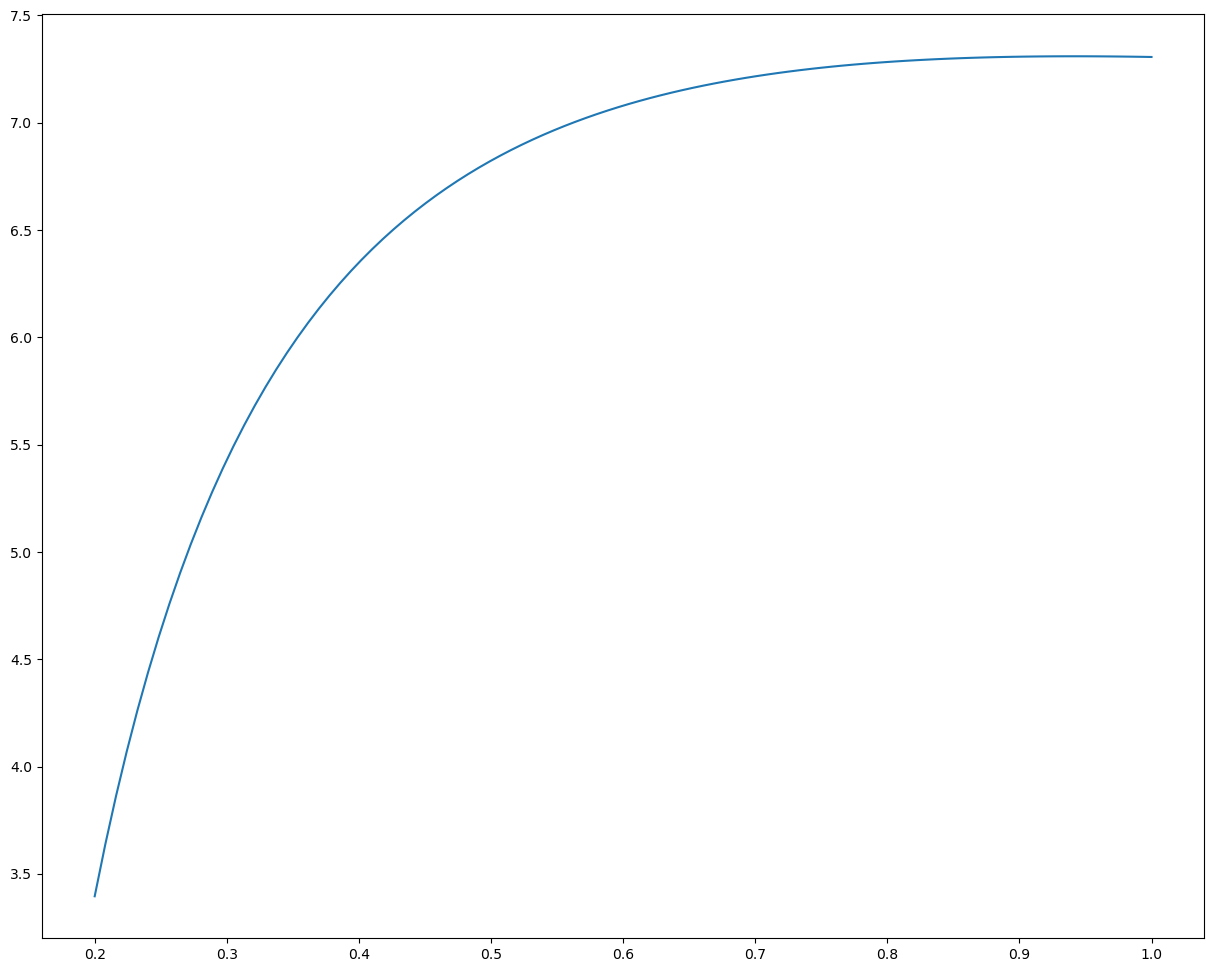

In [59]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [37]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

NotImplementedError: The differentiation rules for the Schur factorization have not been implemented.

In [60]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.1540 
 -T error = 0.5000


In [41]:
mu_sm[0][-1]

Array([10.058286,  9.929167,  9.997537], dtype=float32)

In [42]:
X_obs[0][0]

Array([10.026602,  9.953604, 10.052825], dtype=float32)

In [31]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

978 ms ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Sym

## Defining Manifold and Loading Score

In [73]:
N = 2

In [74]:
M = Sym(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [75]:
file_path = 'scores/Sym'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Sym'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)

if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

In [76]:
grady_log(x0,x0,0.5)

Array([-0.03716446, -0.20655638, -0.02187187], dtype=float32)

## Loading Loss

In [77]:
loss = jnp.load('scores/Sym'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  850


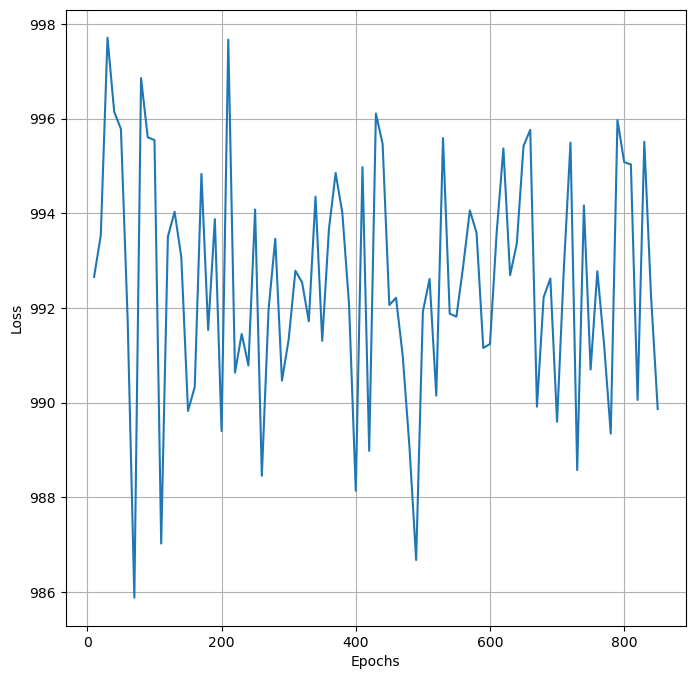

In [78]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [79]:
xs = pd.read_csv('Data/Sym'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Sym'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values)[~jnp.isnan(xs.values).any(axis=1)], jnp.array(charts.values)[~jnp.isnan(xs.values).any(axis=1)])

In [80]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.01, max_iter=1000)
print(mu_sm[0][-1])

[ 9.989129  9.972029 10.0045  ]


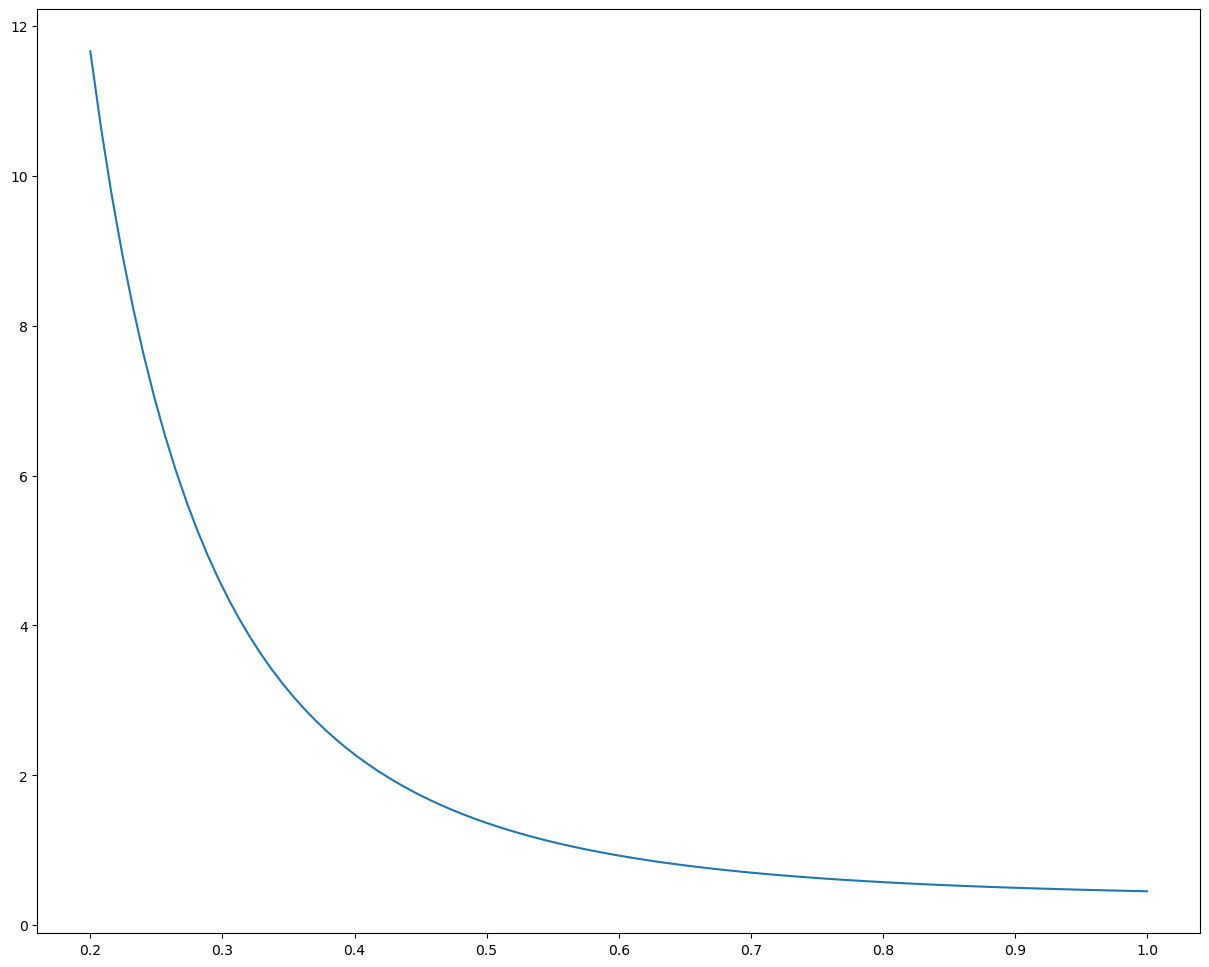

In [81]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [40]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [82]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0303 
 -T error = 0.5000


In [36]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

KeyboardInterrupt: 

# Landmarks

## Defining Manifold and Loading Score

In [488]:
N = 2

In [489]:
M = Landmarks(N=N,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())
if N >=10:
    with open('../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]

        x1 = jnp.array([float(x) for x in all_data[0].split()[2:]])
        x2 = jnp.array([float(x) for x in all_data[1].split()[2:]])

        x0 = M.coords(jnp.vstack((x1[::len(x1)//N],x2[::len(x2)//N])).T.flatten())

using M.Exp for Logarithm


In [490]:
x0[0].reshape(-1,2)

Array([[-5.,  0.],
       [ 5.,  0.]], dtype=float32)

In [491]:
file_path = 'scores/Landmarks'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Landmarks'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if 2*N<10:
    layers = [50,100,100,50]
elif 2*N<50:
    layers = [50,100,200,400,400,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    ggrad = s2.apply(state_s2.params,rng_key, jnp.hstack((x[0], y[0], t)))
    
    return ggrad

## Loading Loss

In [492]:
loss = jnp.load('scores/Landmarks'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  210


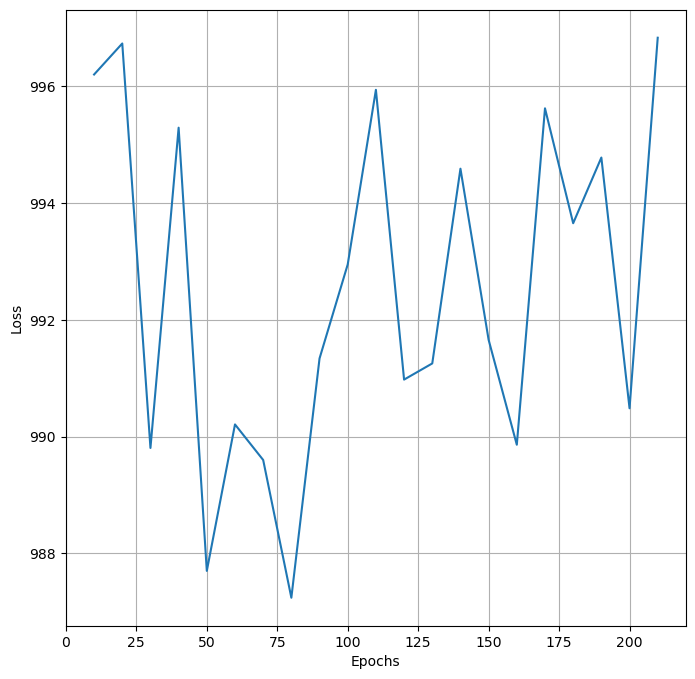

In [493]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [494]:
loss = jnp.load('scores/Landmarks'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  200


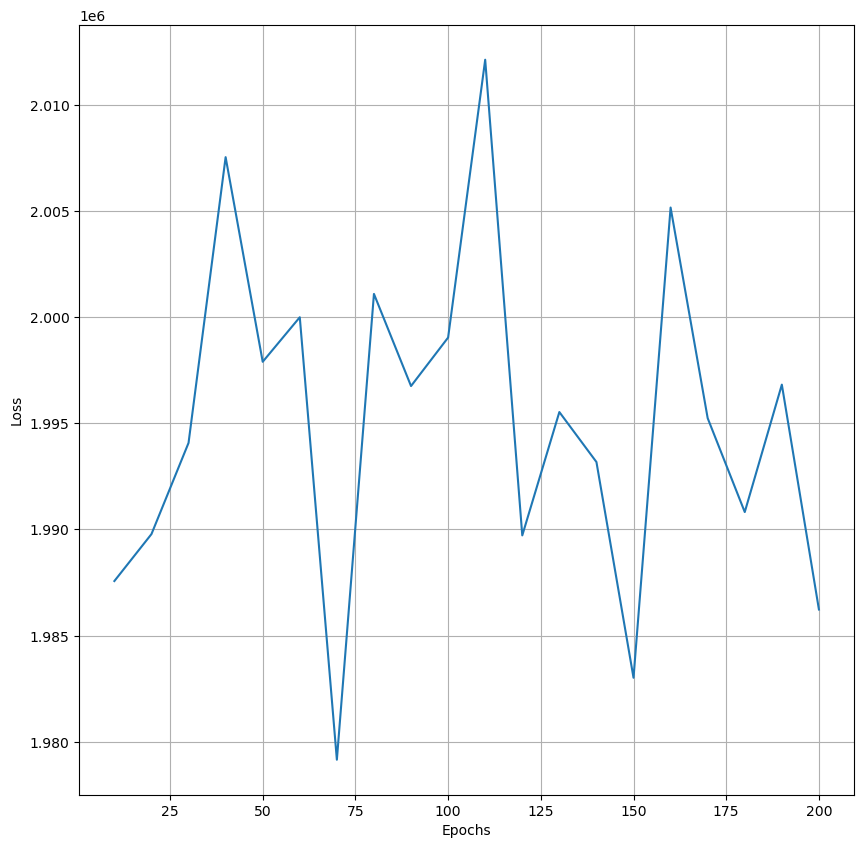

In [495]:
fig = plt.figure(figsize=(10,10))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [496]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

ValueError: 'mlp_s1/~model/linear/w' with retrieved shape (9, 50) does not match shape=[15, 50] dtype=dtype('float32')

## Estimating Diffusion t-Mean

In [497]:
xs = pd.read_csv('Data/Landmarks'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [498]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                    step_size=0.01, max_iter=100)

In [16]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

AttributeError: 'tuple' object has no attribute 'flatten'

In [499]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -5.1123 -0.0682 4.8874 0.1186 )
T = 0.4618


In [500]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.2097 
 -T error = 0.0382


In [334]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

10.1 s ± 2.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
